In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [1]:
import os 
import pandas as pd

file_path = '../HW2/HW2_MNIST_train/'

# 讀取所有 txt 檔案，建立 DataFrame
data_list = []
for txt_file in os.listdir(file_path):
    if txt_file.endswith(".txt"):
        img_name = txt_file.replace(".txt", ".png")  
        img_path = os.path.join(file_path, img_name)
        txt_path = os.path.join(file_path, txt_file)
        
        with open(txt_path, "r") as f:
            label = f.read().strip().split('\t')  # 讀取標籤
            label.insert(0, img_path)
            data_list.append(label)
        

# 轉成 DataFrame
df = pd.DataFrame(data_list, columns=["img_path", "label", "upper_left_x", "upper_left_y", "h", "w"])

In [7]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 定義 PyTorch Dataset
class ImageDataset(Dataset):
    # fetch information form the dataframe and transform the image
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.dataframe.iloc[idx, 1])

        # image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # grayscale
        # h, w = image.shape[:2]
        # # get the bounding box
        # bbox = (
        #     float(self.dataframe.iloc[idx, 2]),
        #     float(self.dataframe.iloc[idx, 3]),
        #     float(self.dataframe.iloc[idx, 4]),
        #     float(self.dataframe.iloc[idx, 5])
        # )
        # image = move_bounding_box_to_center(image, bbox)

        # convert to PIL image
        image = Image.open(img_path).convert('L')  # convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

# 定義transform
transform = transforms.Compose([
    transforms.ToTensor(),           # a kind of normalization and transform to tensor
    transforms.Normalize((0.5,), (0.5,)),  # normalize the image
])

In [46]:
print(df['label'].value_counts())

1    10835
0    10785
7    10007
3     9812
2     9531
9     9524
6     9474
8     9427
4     9314
5     8687
Name: label, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split
import cv2
# Split the dataset into training and validation sets with stratification to ensure even label distribution
train_df, val_df = train_test_split(df, test_size=0.3, random_state=3, stratify=df['label'])

# Define the batch size
batch_size = 32

# create dataset and dataloader
train_dset = ImageDataset(dataframe=train_df, transform=transform)
train_dataloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
val_dset = ImageDataset(dataframe=val_df, transform=transform)
val_dataloader = DataLoader(val_dset, batch_size=batch_size, shuffle=False)

# 測試資料加載
for images, labels in train_dataloader:
    print(images.shape)  # 輸出: (batch_size, channels, height, width)
    print(labels.shape)  # 輸出: (batch_size,)
    break

torch.Size([32, 1, 128, 128])
torch.Size([32])


In [11]:
class simpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
            input_size: 每個時間步的輸入特徵數量
            hidden_size: RNN 隱藏層維度大小
            num_layers: RNN 堆疊層數
            num_classes: 最後輸出類別數量
        """
        super(simpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.CNN_feature_extractor = CNN_Model()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x: (batch_size, channels, height, width)
        batch_size = x.size(0)

        # CNN 特徵抽取
        cnn_features = self.CNN_feature_extractor(x)  # (batch_size, 64, 4, 4)
        cnn_features = cnn_features.view(batch_size, 64, -1)  # -> (batch_size, 64, 16)

        # 初始化 hidden state：雙向所以是 2 * num_layers
        h0 = torch.zeros(2 * self.num_layers, batch_size, self.hidden_size).to(x.device)

        # RNN 前向傳播
        out, _ = self.rnn(cnn_features, h0)  # (batch_size, 64, hidden_size * 2)

        # 取最後一個時間步的輸出，送進全連接層分類
        out = self.fc(out[:, -1, :])  # (batch_size, num_classes)

        return out

# Create CNN feature selector
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(1, 128, 128)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1), # (8,124,124)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (8,62,62)
            nn.Conv2d(8, 8, kernel_size=3, stride=1), # (8,60,60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (8,30,30)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=5, stride=1), # (32,26,26)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), # (32,24,24)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # (32,12,12)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1), # (64,10,10)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # (64,8,8)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (64,4,4)
        )
        
    def forward(self, x):
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out


In [12]:
import torch.optim as optim
# 設定超參數
input_size = 16   # 每個時間步的輸入特徵數量
hidden_size = 64  # LSTM 隱藏層大小
num_layers = 2     # LSTM 堆疊層數
num_classes = 10   # 分類數量，請根據你的問題調整
model = simpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [7]:
import torchinfo
model = simpleRNN(input_size, hidden_size, num_layers, num_classes).to('cpu')
print(f"Model's structure:\n {torchinfo.summary(model)}")

Model's structure:
Layer (type:depth-idx)                   Param #
simpleRNN                                --
├─CNN_Model: 1-1                         --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  208
│    │    └─ReLU: 3-2                    --
│    │    └─MaxPool2d: 3-3               --
│    │    └─Conv2d: 3-4                  584
│    │    └─ReLU: 3-5                    --
│    │    └─MaxPool2d: 3-6               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-7                  6,432
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  9,248
│    │    └─ReLU: 3-10                   --
│    │    └─MaxPool2d: 3-11              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-12                 18,496
│    │    └─ReLU: 3-13                   --
│    │    └─Conv2d: 3-14                 36,928
│    │    └─ReLU: 3-15                   --
│    │    └─MaxPool2d: 3-16         

In [50]:
from matplotlib import pyplot as plt
Epoch = 10
learning_rate = 1e-4

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
valid_loss_values = []
train_accuracy_values = []
valid_accuracy_values = []
best_val_acc = 0

for epoch in range(1, Epoch+1):
    model.train()
    accuracy = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        # move data to device
        X_train = images.to(device)
        Y_train = labels.to(device).long()
        
        # X_train = X_train.squeeze(1)
        # zero gradients
        optimizer.zero_grad()
        # forward pass
        Y_pred = model(X_train)
        # compute loss
        l = loss(Y_pred, Y_train)
        # backward pass
        l.backward()
        # update weights
        optimizer.step()
        # calculate accuracy
        predictions = Y_pred.argmax(dim=1)  # Get the predicted class index
        accuracy += (predictions == Y_train).sum().item()
        # update the training "total" loss
        train_loss += (l.item() * Y_train.size(0))  # accumulate loss
        # print the loss and accuracy for every batch
        # print every batch_size batches
        print(f"In Epoch {epoch}: Batch {(i+1)*batch_size}/{len(train_dataloader.dataset)}: Loss: {l.item():.4f}, Accuracy: {(predictions == Y_train).sum().item()/Y_train.size(0):.4f}")
        
    # average the loss and accuracy
    accuracy /= len(train_dataloader.dataset)
    train_loss /= len(train_dataloader.dataset)
    print(f"Epoch {epoch}: Accuracy: {accuracy:.4f}, Train Loss: {train_loss:.4f}")

    # store the loss and accuracy
    loss_values.append(train_loss)
    train_accuracy_values.append(accuracy)

    # evaluate the model
    model.eval()
    valid_acc = 0.0
    valid_loss = 0.0
    # iterate through the validation set
    for images, labels in val_dataloader:
        # move data to device
        X_test = images.to(device).float()
        Y_test = labels.to(device).long()
        # X_test = X_test.squeeze(1)
        Y_pred = model(X_test)
        # compute loss
        l = loss(Y_pred, Y_test)
        # calculate accuracy
        predictions = Y_pred.argmax(dim=1)  # Get the predicted class index
        valid_acc += (predictions == Y_test).sum().item()
        # update the validation "total" loss
        valid_loss += l.item() * X_test.size(0)  # accumulate loss
        
    # store the loss and accuracy
    valid_acc /= len(val_dataloader.dataset)
    valid_loss /= len(val_dataloader.dataset)
    valid_loss_values.append(valid_loss)
    valid_accuracy_values.append(valid_acc)
    
    if best_val_acc < valid_acc:
        # update the best validation accuracy
        best_val_acc = valid_acc
        # save the model if the validation loss is the best so far
        torch.save(model.state_dict(), 'RNN.pth')

    # print the loss and accuracy for every 5 epochs
    print(f"Epoch {epoch}: Validation Accuracy: {valid_acc:.4f}, Validation Loss: {valid_loss:.4f}")

In Epoch 1: Batch 32/68177: Loss: 2.3023, Accuracy: 0.1250
In Epoch 1: Batch 64/68177: Loss: 2.3264, Accuracy: 0.0938
In Epoch 1: Batch 96/68177: Loss: 2.3137, Accuracy: 0.0625
In Epoch 1: Batch 128/68177: Loss: 2.3335, Accuracy: 0.0938
In Epoch 1: Batch 160/68177: Loss: 2.3234, Accuracy: 0.0625
In Epoch 1: Batch 192/68177: Loss: 2.3091, Accuracy: 0.1562
In Epoch 1: Batch 224/68177: Loss: 2.3071, Accuracy: 0.0312
In Epoch 1: Batch 256/68177: Loss: 2.3055, Accuracy: 0.1250
In Epoch 1: Batch 288/68177: Loss: 2.3082, Accuracy: 0.0938
In Epoch 1: Batch 320/68177: Loss: 2.3050, Accuracy: 0.1562
In Epoch 1: Batch 352/68177: Loss: 2.2997, Accuracy: 0.0312
In Epoch 1: Batch 384/68177: Loss: 2.3199, Accuracy: 0.1250
In Epoch 1: Batch 416/68177: Loss: 2.3087, Accuracy: 0.1250
In Epoch 1: Batch 448/68177: Loss: 2.2991, Accuracy: 0.0625
In Epoch 1: Batch 480/68177: Loss: 2.3124, Accuracy: 0.0938
In Epoch 1: Batch 512/68177: Loss: 2.2838, Accuracy: 0.1875
In Epoch 1: Batch 544/68177: Loss: 2.3341, 

In Epoch 1: Batch 4384/68177: Loss: 2.2984, Accuracy: 0.1562
In Epoch 1: Batch 4416/68177: Loss: 2.3045, Accuracy: 0.1562
In Epoch 1: Batch 4448/68177: Loss: 2.2920, Accuracy: 0.2188
In Epoch 1: Batch 4480/68177: Loss: 2.2886, Accuracy: 0.0938
In Epoch 1: Batch 4512/68177: Loss: 2.2955, Accuracy: 0.0625
In Epoch 1: Batch 4544/68177: Loss: 2.3033, Accuracy: 0.0625
In Epoch 1: Batch 4576/68177: Loss: 2.2883, Accuracy: 0.1875
In Epoch 1: Batch 4608/68177: Loss: 2.3095, Accuracy: 0.0000
In Epoch 1: Batch 4640/68177: Loss: 2.3108, Accuracy: 0.0938
In Epoch 1: Batch 4672/68177: Loss: 2.3029, Accuracy: 0.0625
In Epoch 1: Batch 4704/68177: Loss: 2.2893, Accuracy: 0.0938
In Epoch 1: Batch 4736/68177: Loss: 2.3135, Accuracy: 0.0000
In Epoch 1: Batch 4768/68177: Loss: 2.3000, Accuracy: 0.1562
In Epoch 1: Batch 4800/68177: Loss: 2.3067, Accuracy: 0.0312
In Epoch 1: Batch 4832/68177: Loss: 2.3104, Accuracy: 0.0938
In Epoch 1: Batch 4864/68177: Loss: 2.3158, Accuracy: 0.0625
In Epoch 1: Batch 4896/6

In Epoch 1: Batch 8736/68177: Loss: 2.3073, Accuracy: 0.0625
In Epoch 1: Batch 8768/68177: Loss: 2.3122, Accuracy: 0.0625
In Epoch 1: Batch 8800/68177: Loss: 2.2993, Accuracy: 0.0625
In Epoch 1: Batch 8832/68177: Loss: 2.3095, Accuracy: 0.1250
In Epoch 1: Batch 8864/68177: Loss: 2.2768, Accuracy: 0.1562
In Epoch 1: Batch 8896/68177: Loss: 2.2895, Accuracy: 0.1250
In Epoch 1: Batch 8928/68177: Loss: 2.3088, Accuracy: 0.1250
In Epoch 1: Batch 8960/68177: Loss: 2.3124, Accuracy: 0.1562
In Epoch 1: Batch 8992/68177: Loss: 2.3126, Accuracy: 0.0625
In Epoch 1: Batch 9024/68177: Loss: 2.2920, Accuracy: 0.1875
In Epoch 1: Batch 9056/68177: Loss: 2.3206, Accuracy: 0.0625
In Epoch 1: Batch 9088/68177: Loss: 2.3233, Accuracy: 0.0312
In Epoch 1: Batch 9120/68177: Loss: 2.2864, Accuracy: 0.1875
In Epoch 1: Batch 9152/68177: Loss: 2.3032, Accuracy: 0.0625
In Epoch 1: Batch 9184/68177: Loss: 2.2658, Accuracy: 0.1875
In Epoch 1: Batch 9216/68177: Loss: 2.3078, Accuracy: 0.0938
In Epoch 1: Batch 9248/6

In Epoch 1: Batch 13024/68177: Loss: 2.3002, Accuracy: 0.1562
In Epoch 1: Batch 13056/68177: Loss: 2.3116, Accuracy: 0.0625
In Epoch 1: Batch 13088/68177: Loss: 2.3061, Accuracy: 0.1250
In Epoch 1: Batch 13120/68177: Loss: 2.2917, Accuracy: 0.2500
In Epoch 1: Batch 13152/68177: Loss: 2.3063, Accuracy: 0.1250
In Epoch 1: Batch 13184/68177: Loss: 2.2914, Accuracy: 0.1250
In Epoch 1: Batch 13216/68177: Loss: 2.2983, Accuracy: 0.0938
In Epoch 1: Batch 13248/68177: Loss: 2.3094, Accuracy: 0.0312
In Epoch 1: Batch 13280/68177: Loss: 2.3207, Accuracy: 0.0625
In Epoch 1: Batch 13312/68177: Loss: 2.2873, Accuracy: 0.0625
In Epoch 1: Batch 13344/68177: Loss: 2.2801, Accuracy: 0.1875
In Epoch 1: Batch 13376/68177: Loss: 2.3075, Accuracy: 0.0938
In Epoch 1: Batch 13408/68177: Loss: 2.3130, Accuracy: 0.1562
In Epoch 1: Batch 13440/68177: Loss: 2.2982, Accuracy: 0.0938
In Epoch 1: Batch 13472/68177: Loss: 2.2994, Accuracy: 0.1562
In Epoch 1: Batch 13504/68177: Loss: 2.3325, Accuracy: 0.0625
In Epoch

In Epoch 1: Batch 17312/68177: Loss: 2.2896, Accuracy: 0.0938
In Epoch 1: Batch 17344/68177: Loss: 2.3137, Accuracy: 0.0938
In Epoch 1: Batch 17376/68177: Loss: 2.2815, Accuracy: 0.1250
In Epoch 1: Batch 17408/68177: Loss: 2.2997, Accuracy: 0.1562
In Epoch 1: Batch 17440/68177: Loss: 2.2771, Accuracy: 0.2188
In Epoch 1: Batch 17472/68177: Loss: 2.3019, Accuracy: 0.1250
In Epoch 1: Batch 17504/68177: Loss: 2.3277, Accuracy: 0.0312
In Epoch 1: Batch 17536/68177: Loss: 2.2774, Accuracy: 0.1875
In Epoch 1: Batch 17568/68177: Loss: 2.2878, Accuracy: 0.0938
In Epoch 1: Batch 17600/68177: Loss: 2.2756, Accuracy: 0.3125
In Epoch 1: Batch 17632/68177: Loss: 2.2802, Accuracy: 0.1250
In Epoch 1: Batch 17664/68177: Loss: 2.3029, Accuracy: 0.0938
In Epoch 1: Batch 17696/68177: Loss: 2.3063, Accuracy: 0.1250
In Epoch 1: Batch 17728/68177: Loss: 2.3142, Accuracy: 0.1250
In Epoch 1: Batch 17760/68177: Loss: 2.2864, Accuracy: 0.1250
In Epoch 1: Batch 17792/68177: Loss: 2.3040, Accuracy: 0.0938
In Epoch

In Epoch 1: Batch 21600/68177: Loss: 2.2915, Accuracy: 0.1250
In Epoch 1: Batch 21632/68177: Loss: 2.3273, Accuracy: 0.0312
In Epoch 1: Batch 21664/68177: Loss: 2.2970, Accuracy: 0.1562
In Epoch 1: Batch 21696/68177: Loss: 2.2852, Accuracy: 0.1562
In Epoch 1: Batch 21728/68177: Loss: 2.3108, Accuracy: 0.0938
In Epoch 1: Batch 21760/68177: Loss: 2.3047, Accuracy: 0.1250
In Epoch 1: Batch 21792/68177: Loss: 2.3349, Accuracy: 0.0000
In Epoch 1: Batch 21824/68177: Loss: 2.2975, Accuracy: 0.0938
In Epoch 1: Batch 21856/68177: Loss: 2.2875, Accuracy: 0.1250
In Epoch 1: Batch 21888/68177: Loss: 2.2972, Accuracy: 0.0625
In Epoch 1: Batch 21920/68177: Loss: 2.2867, Accuracy: 0.1562
In Epoch 1: Batch 21952/68177: Loss: 2.3165, Accuracy: 0.0938
In Epoch 1: Batch 21984/68177: Loss: 2.3207, Accuracy: 0.0938
In Epoch 1: Batch 22016/68177: Loss: 2.2813, Accuracy: 0.1562
In Epoch 1: Batch 22048/68177: Loss: 2.3107, Accuracy: 0.0625
In Epoch 1: Batch 22080/68177: Loss: 2.2951, Accuracy: 0.0312
In Epoch

In Epoch 1: Batch 25888/68177: Loss: 2.2843, Accuracy: 0.1250
In Epoch 1: Batch 25920/68177: Loss: 2.3102, Accuracy: 0.1562
In Epoch 1: Batch 25952/68177: Loss: 2.2901, Accuracy: 0.1562
In Epoch 1: Batch 25984/68177: Loss: 2.3020, Accuracy: 0.0312
In Epoch 1: Batch 26016/68177: Loss: 2.3215, Accuracy: 0.0938
In Epoch 1: Batch 26048/68177: Loss: 2.3028, Accuracy: 0.0312
In Epoch 1: Batch 26080/68177: Loss: 2.2949, Accuracy: 0.1250
In Epoch 1: Batch 26112/68177: Loss: 2.2935, Accuracy: 0.1250
In Epoch 1: Batch 26144/68177: Loss: 2.2906, Accuracy: 0.0938
In Epoch 1: Batch 26176/68177: Loss: 2.3206, Accuracy: 0.0938
In Epoch 1: Batch 26208/68177: Loss: 2.2915, Accuracy: 0.1250
In Epoch 1: Batch 26240/68177: Loss: 2.3182, Accuracy: 0.0625
In Epoch 1: Batch 26272/68177: Loss: 2.2989, Accuracy: 0.0938
In Epoch 1: Batch 26304/68177: Loss: 2.2930, Accuracy: 0.1250
In Epoch 1: Batch 26336/68177: Loss: 2.3057, Accuracy: 0.1250
In Epoch 1: Batch 26368/68177: Loss: 2.3040, Accuracy: 0.0312
In Epoch

In Epoch 1: Batch 30176/68177: Loss: 2.2511, Accuracy: 0.2188
In Epoch 1: Batch 30208/68177: Loss: 2.2427, Accuracy: 0.2500
In Epoch 1: Batch 30240/68177: Loss: 2.2979, Accuracy: 0.0938
In Epoch 1: Batch 30272/68177: Loss: 2.2804, Accuracy: 0.1875
In Epoch 1: Batch 30304/68177: Loss: 2.2791, Accuracy: 0.1562
In Epoch 1: Batch 30336/68177: Loss: 2.3041, Accuracy: 0.0938
In Epoch 1: Batch 30368/68177: Loss: 2.2871, Accuracy: 0.1562
In Epoch 1: Batch 30400/68177: Loss: 2.2361, Accuracy: 0.1875
In Epoch 1: Batch 30432/68177: Loss: 2.3046, Accuracy: 0.0938
In Epoch 1: Batch 30464/68177: Loss: 2.3115, Accuracy: 0.0625
In Epoch 1: Batch 30496/68177: Loss: 2.2455, Accuracy: 0.2188
In Epoch 1: Batch 30528/68177: Loss: 2.2494, Accuracy: 0.2188
In Epoch 1: Batch 30560/68177: Loss: 2.3129, Accuracy: 0.1875
In Epoch 1: Batch 30592/68177: Loss: 2.2385, Accuracy: 0.2188
In Epoch 1: Batch 30624/68177: Loss: 2.2784, Accuracy: 0.1250
In Epoch 1: Batch 30656/68177: Loss: 2.2858, Accuracy: 0.1250
In Epoch

In Epoch 1: Batch 34464/68177: Loss: 1.9685, Accuracy: 0.2188
In Epoch 1: Batch 34496/68177: Loss: 2.1890, Accuracy: 0.1562
In Epoch 1: Batch 34528/68177: Loss: 2.1738, Accuracy: 0.2500
In Epoch 1: Batch 34560/68177: Loss: 2.1039, Accuracy: 0.2500
In Epoch 1: Batch 34592/68177: Loss: 1.8671, Accuracy: 0.2188
In Epoch 1: Batch 34624/68177: Loss: 2.0511, Accuracy: 0.1875
In Epoch 1: Batch 34656/68177: Loss: 1.9897, Accuracy: 0.1875
In Epoch 1: Batch 34688/68177: Loss: 2.0333, Accuracy: 0.0938
In Epoch 1: Batch 34720/68177: Loss: 2.1514, Accuracy: 0.0938
In Epoch 1: Batch 34752/68177: Loss: 2.0428, Accuracy: 0.2500
In Epoch 1: Batch 34784/68177: Loss: 2.0121, Accuracy: 0.2812
In Epoch 1: Batch 34816/68177: Loss: 1.9745, Accuracy: 0.2812
In Epoch 1: Batch 34848/68177: Loss: 1.9324, Accuracy: 0.2812
In Epoch 1: Batch 34880/68177: Loss: 2.1866, Accuracy: 0.3125
In Epoch 1: Batch 34912/68177: Loss: 2.1421, Accuracy: 0.1562
In Epoch 1: Batch 34944/68177: Loss: 2.1575, Accuracy: 0.1875
In Epoch

In Epoch 1: Batch 38752/68177: Loss: 2.0158, Accuracy: 0.2812
In Epoch 1: Batch 38784/68177: Loss: 1.7887, Accuracy: 0.2500
In Epoch 1: Batch 38816/68177: Loss: 1.7433, Accuracy: 0.3750
In Epoch 1: Batch 38848/68177: Loss: 2.1321, Accuracy: 0.1562
In Epoch 1: Batch 38880/68177: Loss: 1.7653, Accuracy: 0.3125
In Epoch 1: Batch 38912/68177: Loss: 1.9066, Accuracy: 0.2188
In Epoch 1: Batch 38944/68177: Loss: 2.0366, Accuracy: 0.1562
In Epoch 1: Batch 38976/68177: Loss: 2.0234, Accuracy: 0.1562
In Epoch 1: Batch 39008/68177: Loss: 1.6681, Accuracy: 0.4688
In Epoch 1: Batch 39040/68177: Loss: 1.9425, Accuracy: 0.1562
In Epoch 1: Batch 39072/68177: Loss: 1.7496, Accuracy: 0.3438
In Epoch 1: Batch 39104/68177: Loss: 2.0473, Accuracy: 0.1250
In Epoch 1: Batch 39136/68177: Loss: 1.8860, Accuracy: 0.2500
In Epoch 1: Batch 39168/68177: Loss: 2.0007, Accuracy: 0.2500
In Epoch 1: Batch 39200/68177: Loss: 1.9112, Accuracy: 0.3438
In Epoch 1: Batch 39232/68177: Loss: 1.9567, Accuracy: 0.2188
In Epoch

In Epoch 1: Batch 43040/68177: Loss: 1.8324, Accuracy: 0.3125
In Epoch 1: Batch 43072/68177: Loss: 1.7236, Accuracy: 0.3438
In Epoch 1: Batch 43104/68177: Loss: 2.0963, Accuracy: 0.0938
In Epoch 1: Batch 43136/68177: Loss: 1.9680, Accuracy: 0.1562
In Epoch 1: Batch 43168/68177: Loss: 1.9565, Accuracy: 0.1562
In Epoch 1: Batch 43200/68177: Loss: 1.6137, Accuracy: 0.3438
In Epoch 1: Batch 43232/68177: Loss: 1.7937, Accuracy: 0.3125
In Epoch 1: Batch 43264/68177: Loss: 1.7465, Accuracy: 0.3750
In Epoch 1: Batch 43296/68177: Loss: 1.8685, Accuracy: 0.2500
In Epoch 1: Batch 43328/68177: Loss: 1.9227, Accuracy: 0.2500
In Epoch 1: Batch 43360/68177: Loss: 1.8081, Accuracy: 0.2812
In Epoch 1: Batch 43392/68177: Loss: 1.7789, Accuracy: 0.2500
In Epoch 1: Batch 43424/68177: Loss: 1.7544, Accuracy: 0.3125
In Epoch 1: Batch 43456/68177: Loss: 1.8252, Accuracy: 0.3438
In Epoch 1: Batch 43488/68177: Loss: 1.8237, Accuracy: 0.1875
In Epoch 1: Batch 43520/68177: Loss: 1.8744, Accuracy: 0.3125
In Epoch

In Epoch 1: Batch 47328/68177: Loss: 1.5201, Accuracy: 0.3438
In Epoch 1: Batch 47360/68177: Loss: 1.6613, Accuracy: 0.5000
In Epoch 1: Batch 47392/68177: Loss: 1.6460, Accuracy: 0.5000
In Epoch 1: Batch 47424/68177: Loss: 1.8783, Accuracy: 0.2188
In Epoch 1: Batch 47456/68177: Loss: 1.5650, Accuracy: 0.4688
In Epoch 1: Batch 47488/68177: Loss: 1.9398, Accuracy: 0.1875
In Epoch 1: Batch 47520/68177: Loss: 1.5371, Accuracy: 0.4062
In Epoch 1: Batch 47552/68177: Loss: 1.7557, Accuracy: 0.2812
In Epoch 1: Batch 47584/68177: Loss: 1.7248, Accuracy: 0.3125
In Epoch 1: Batch 47616/68177: Loss: 1.8321, Accuracy: 0.3125
In Epoch 1: Batch 47648/68177: Loss: 1.9121, Accuracy: 0.1875
In Epoch 1: Batch 47680/68177: Loss: 1.9605, Accuracy: 0.2500
In Epoch 1: Batch 47712/68177: Loss: 1.7137, Accuracy: 0.3750
In Epoch 1: Batch 47744/68177: Loss: 1.9165, Accuracy: 0.2812
In Epoch 1: Batch 47776/68177: Loss: 1.6865, Accuracy: 0.2812
In Epoch 1: Batch 47808/68177: Loss: 1.5969, Accuracy: 0.2500
In Epoch

In Epoch 1: Batch 51616/68177: Loss: 1.9378, Accuracy: 0.3438
In Epoch 1: Batch 51648/68177: Loss: 1.7454, Accuracy: 0.1875
In Epoch 1: Batch 51680/68177: Loss: 1.7354, Accuracy: 0.2188
In Epoch 1: Batch 51712/68177: Loss: 1.7169, Accuracy: 0.2188
In Epoch 1: Batch 51744/68177: Loss: 1.6405, Accuracy: 0.3438
In Epoch 1: Batch 51776/68177: Loss: 1.5976, Accuracy: 0.3438
In Epoch 1: Batch 51808/68177: Loss: 1.6482, Accuracy: 0.3125
In Epoch 1: Batch 51840/68177: Loss: 1.9991, Accuracy: 0.1562
In Epoch 1: Batch 51872/68177: Loss: 1.6654, Accuracy: 0.3438
In Epoch 1: Batch 51904/68177: Loss: 1.9038, Accuracy: 0.2188
In Epoch 1: Batch 51936/68177: Loss: 1.7483, Accuracy: 0.2188
In Epoch 1: Batch 51968/68177: Loss: 1.8638, Accuracy: 0.2500
In Epoch 1: Batch 52000/68177: Loss: 1.7603, Accuracy: 0.3125
In Epoch 1: Batch 52032/68177: Loss: 1.5137, Accuracy: 0.3125
In Epoch 1: Batch 52064/68177: Loss: 1.6561, Accuracy: 0.2812
In Epoch 1: Batch 52096/68177: Loss: 1.9619, Accuracy: 0.1562
In Epoch

In Epoch 1: Batch 55904/68177: Loss: 1.8395, Accuracy: 0.2812
In Epoch 1: Batch 55936/68177: Loss: 1.7238, Accuracy: 0.2812
In Epoch 1: Batch 55968/68177: Loss: 1.6413, Accuracy: 0.3750
In Epoch 1: Batch 56000/68177: Loss: 1.8046, Accuracy: 0.2500
In Epoch 1: Batch 56032/68177: Loss: 1.8129, Accuracy: 0.3438
In Epoch 1: Batch 56064/68177: Loss: 1.7603, Accuracy: 0.2812
In Epoch 1: Batch 56096/68177: Loss: 1.6868, Accuracy: 0.2812
In Epoch 1: Batch 56128/68177: Loss: 1.6600, Accuracy: 0.3438
In Epoch 1: Batch 56160/68177: Loss: 1.7236, Accuracy: 0.2188
In Epoch 1: Batch 56192/68177: Loss: 1.5404, Accuracy: 0.3125
In Epoch 1: Batch 56224/68177: Loss: 1.8513, Accuracy: 0.2188
In Epoch 1: Batch 56256/68177: Loss: 1.5935, Accuracy: 0.2812
In Epoch 1: Batch 56288/68177: Loss: 1.7049, Accuracy: 0.2500
In Epoch 1: Batch 56320/68177: Loss: 1.9551, Accuracy: 0.1875
In Epoch 1: Batch 56352/68177: Loss: 1.7027, Accuracy: 0.3750
In Epoch 1: Batch 56384/68177: Loss: 2.0316, Accuracy: 0.2812
In Epoch

In Epoch 1: Batch 60160/68177: Loss: 1.5858, Accuracy: 0.3750
In Epoch 1: Batch 60192/68177: Loss: 1.4344, Accuracy: 0.4062
In Epoch 1: Batch 60224/68177: Loss: 1.7333, Accuracy: 0.4062
In Epoch 1: Batch 60256/68177: Loss: 1.7532, Accuracy: 0.3438
In Epoch 1: Batch 60288/68177: Loss: 1.6410, Accuracy: 0.4688
In Epoch 1: Batch 60320/68177: Loss: 1.7496, Accuracy: 0.1562
In Epoch 1: Batch 60352/68177: Loss: 1.8882, Accuracy: 0.1250
In Epoch 1: Batch 60384/68177: Loss: 1.5846, Accuracy: 0.4375
In Epoch 1: Batch 60416/68177: Loss: 1.6180, Accuracy: 0.2188
In Epoch 1: Batch 60448/68177: Loss: 1.7347, Accuracy: 0.2188
In Epoch 1: Batch 60480/68177: Loss: 1.5167, Accuracy: 0.3125
In Epoch 1: Batch 60512/68177: Loss: 1.4228, Accuracy: 0.5000
In Epoch 1: Batch 60544/68177: Loss: 1.6243, Accuracy: 0.4688
In Epoch 1: Batch 60576/68177: Loss: 1.6281, Accuracy: 0.1875
In Epoch 1: Batch 60608/68177: Loss: 1.7805, Accuracy: 0.2812
In Epoch 1: Batch 60640/68177: Loss: 1.7638, Accuracy: 0.2188
In Epoch

In Epoch 1: Batch 64448/68177: Loss: 1.7087, Accuracy: 0.3750
In Epoch 1: Batch 64480/68177: Loss: 1.4564, Accuracy: 0.2812
In Epoch 1: Batch 64512/68177: Loss: 1.6813, Accuracy: 0.2812
In Epoch 1: Batch 64544/68177: Loss: 1.5279, Accuracy: 0.3438
In Epoch 1: Batch 64576/68177: Loss: 1.6897, Accuracy: 0.2188
In Epoch 1: Batch 64608/68177: Loss: 1.5084, Accuracy: 0.4688
In Epoch 1: Batch 64640/68177: Loss: 1.6406, Accuracy: 0.1875
In Epoch 1: Batch 64672/68177: Loss: 1.8772, Accuracy: 0.1875
In Epoch 1: Batch 64704/68177: Loss: 1.6636, Accuracy: 0.3125
In Epoch 1: Batch 64736/68177: Loss: 1.4953, Accuracy: 0.5000
In Epoch 1: Batch 64768/68177: Loss: 1.5654, Accuracy: 0.4062
In Epoch 1: Batch 64800/68177: Loss: 1.6291, Accuracy: 0.3438
In Epoch 1: Batch 64832/68177: Loss: 1.5383, Accuracy: 0.4688
In Epoch 1: Batch 64864/68177: Loss: 1.7500, Accuracy: 0.2188
In Epoch 1: Batch 64896/68177: Loss: 1.8219, Accuracy: 0.3125
In Epoch 1: Batch 64928/68177: Loss: 1.5138, Accuracy: 0.3750
In Epoch

In Epoch 2: Batch 448/68177: Loss: 1.9305, Accuracy: 0.3438
In Epoch 2: Batch 480/68177: Loss: 1.7310, Accuracy: 0.3125
In Epoch 2: Batch 512/68177: Loss: 1.6455, Accuracy: 0.4375
In Epoch 2: Batch 544/68177: Loss: 1.8410, Accuracy: 0.2500
In Epoch 2: Batch 576/68177: Loss: 1.6199, Accuracy: 0.3125
In Epoch 2: Batch 608/68177: Loss: 1.6672, Accuracy: 0.2500
In Epoch 2: Batch 640/68177: Loss: 1.6403, Accuracy: 0.3438
In Epoch 2: Batch 672/68177: Loss: 1.5397, Accuracy: 0.4688
In Epoch 2: Batch 704/68177: Loss: 1.7108, Accuracy: 0.3750
In Epoch 2: Batch 736/68177: Loss: 1.5758, Accuracy: 0.4062
In Epoch 2: Batch 768/68177: Loss: 1.6738, Accuracy: 0.2500
In Epoch 2: Batch 800/68177: Loss: 1.9762, Accuracy: 0.4062
In Epoch 2: Batch 832/68177: Loss: 1.6336, Accuracy: 0.2188
In Epoch 2: Batch 864/68177: Loss: 1.3839, Accuracy: 0.4375
In Epoch 2: Batch 896/68177: Loss: 1.4436, Accuracy: 0.3125
In Epoch 2: Batch 928/68177: Loss: 1.5601, Accuracy: 0.2812
In Epoch 2: Batch 960/68177: Loss: 1.956

In Epoch 2: Batch 4800/68177: Loss: 1.6690, Accuracy: 0.2188
In Epoch 2: Batch 4832/68177: Loss: 1.6784, Accuracy: 0.3125
In Epoch 2: Batch 4864/68177: Loss: 1.7227, Accuracy: 0.3125
In Epoch 2: Batch 4896/68177: Loss: 1.9505, Accuracy: 0.4688
In Epoch 2: Batch 4928/68177: Loss: 1.5714, Accuracy: 0.4375
In Epoch 2: Batch 4960/68177: Loss: 1.7327, Accuracy: 0.2812
In Epoch 2: Batch 4992/68177: Loss: 1.4573, Accuracy: 0.5312
In Epoch 2: Batch 5024/68177: Loss: 1.2840, Accuracy: 0.5312
In Epoch 2: Batch 5056/68177: Loss: 1.6214, Accuracy: 0.1562
In Epoch 2: Batch 5088/68177: Loss: 1.6693, Accuracy: 0.3125
In Epoch 2: Batch 5120/68177: Loss: 1.6439, Accuracy: 0.3125
In Epoch 2: Batch 5152/68177: Loss: 1.5530, Accuracy: 0.5000
In Epoch 2: Batch 5184/68177: Loss: 1.4035, Accuracy: 0.4375
In Epoch 2: Batch 5216/68177: Loss: 1.6351, Accuracy: 0.2812
In Epoch 2: Batch 5248/68177: Loss: 1.6392, Accuracy: 0.2812
In Epoch 2: Batch 5280/68177: Loss: 1.6269, Accuracy: 0.3438
In Epoch 2: Batch 5312/6

In Epoch 2: Batch 9152/68177: Loss: 1.4656, Accuracy: 0.3750
In Epoch 2: Batch 9184/68177: Loss: 1.8400, Accuracy: 0.1250
In Epoch 2: Batch 9216/68177: Loss: 1.2438, Accuracy: 0.5312
In Epoch 2: Batch 9248/68177: Loss: 2.2026, Accuracy: 0.1875
In Epoch 2: Batch 9280/68177: Loss: 1.6129, Accuracy: 0.3438
In Epoch 2: Batch 9312/68177: Loss: 1.4908, Accuracy: 0.2500
In Epoch 2: Batch 9344/68177: Loss: 1.5686, Accuracy: 0.4688
In Epoch 2: Batch 9376/68177: Loss: 1.5767, Accuracy: 0.2812
In Epoch 2: Batch 9408/68177: Loss: 1.5372, Accuracy: 0.2812
In Epoch 2: Batch 9440/68177: Loss: 1.3124, Accuracy: 0.4062
In Epoch 2: Batch 9472/68177: Loss: 1.5924, Accuracy: 0.2812
In Epoch 2: Batch 9504/68177: Loss: 1.4760, Accuracy: 0.4688
In Epoch 2: Batch 9536/68177: Loss: 1.4407, Accuracy: 0.3750
In Epoch 2: Batch 9568/68177: Loss: 1.6440, Accuracy: 0.4688
In Epoch 2: Batch 9600/68177: Loss: 1.6660, Accuracy: 0.4375
In Epoch 2: Batch 9632/68177: Loss: 1.5118, Accuracy: 0.2812
In Epoch 2: Batch 9664/6

In Epoch 2: Batch 13440/68177: Loss: 1.6346, Accuracy: 0.3125
In Epoch 2: Batch 13472/68177: Loss: 1.6121, Accuracy: 0.2500
In Epoch 2: Batch 13504/68177: Loss: 1.3661, Accuracy: 0.4688
In Epoch 2: Batch 13536/68177: Loss: 1.4508, Accuracy: 0.3438
In Epoch 2: Batch 13568/68177: Loss: 1.6612, Accuracy: 0.3125
In Epoch 2: Batch 13600/68177: Loss: 1.6423, Accuracy: 0.3750
In Epoch 2: Batch 13632/68177: Loss: 1.3412, Accuracy: 0.5938
In Epoch 2: Batch 13664/68177: Loss: 1.6390, Accuracy: 0.3125
In Epoch 2: Batch 13696/68177: Loss: 1.9221, Accuracy: 0.3125
In Epoch 2: Batch 13728/68177: Loss: 1.7350, Accuracy: 0.2812
In Epoch 2: Batch 13760/68177: Loss: 1.5626, Accuracy: 0.4375
In Epoch 2: Batch 13792/68177: Loss: 1.5434, Accuracy: 0.3438
In Epoch 2: Batch 13824/68177: Loss: 1.4728, Accuracy: 0.3125
In Epoch 2: Batch 13856/68177: Loss: 1.6248, Accuracy: 0.3125
In Epoch 2: Batch 13888/68177: Loss: 1.8838, Accuracy: 0.3438
In Epoch 2: Batch 13920/68177: Loss: 1.3483, Accuracy: 0.4688
In Epoch

In Epoch 2: Batch 17728/68177: Loss: 1.5592, Accuracy: 0.3438
In Epoch 2: Batch 17760/68177: Loss: 1.3238, Accuracy: 0.4688
In Epoch 2: Batch 17792/68177: Loss: 1.3332, Accuracy: 0.4062
In Epoch 2: Batch 17824/68177: Loss: 1.5271, Accuracy: 0.3125
In Epoch 2: Batch 17856/68177: Loss: 1.4931, Accuracy: 0.4375
In Epoch 2: Batch 17888/68177: Loss: 1.4921, Accuracy: 0.3125
In Epoch 2: Batch 17920/68177: Loss: 1.5308, Accuracy: 0.3125
In Epoch 2: Batch 17952/68177: Loss: 1.3904, Accuracy: 0.4062
In Epoch 2: Batch 17984/68177: Loss: 1.4573, Accuracy: 0.4375
In Epoch 2: Batch 18016/68177: Loss: 1.8134, Accuracy: 0.3125
In Epoch 2: Batch 18048/68177: Loss: 1.5968, Accuracy: 0.2188
In Epoch 2: Batch 18080/68177: Loss: 1.6603, Accuracy: 0.2812
In Epoch 2: Batch 18112/68177: Loss: 1.5816, Accuracy: 0.2500
In Epoch 2: Batch 18144/68177: Loss: 1.5097, Accuracy: 0.3750
In Epoch 2: Batch 18176/68177: Loss: 1.4629, Accuracy: 0.3750
In Epoch 2: Batch 18208/68177: Loss: 1.4445, Accuracy: 0.4375
In Epoch

In Epoch 2: Batch 22016/68177: Loss: 1.6171, Accuracy: 0.2188
In Epoch 2: Batch 22048/68177: Loss: 1.4625, Accuracy: 0.4375
In Epoch 2: Batch 22080/68177: Loss: 1.3715, Accuracy: 0.5625
In Epoch 2: Batch 22112/68177: Loss: 1.4811, Accuracy: 0.4688
In Epoch 2: Batch 22144/68177: Loss: 1.5689, Accuracy: 0.4375
In Epoch 2: Batch 22176/68177: Loss: 1.4557, Accuracy: 0.4375
In Epoch 2: Batch 22208/68177: Loss: 1.5959, Accuracy: 0.2500
In Epoch 2: Batch 22240/68177: Loss: 1.6754, Accuracy: 0.2812
In Epoch 2: Batch 22272/68177: Loss: 1.6278, Accuracy: 0.4062
In Epoch 2: Batch 22304/68177: Loss: 1.2830, Accuracy: 0.4062
In Epoch 2: Batch 22336/68177: Loss: 1.3515, Accuracy: 0.3750
In Epoch 2: Batch 22368/68177: Loss: 1.8827, Accuracy: 0.2812
In Epoch 2: Batch 22400/68177: Loss: 1.4943, Accuracy: 0.2812
In Epoch 2: Batch 22432/68177: Loss: 1.5542, Accuracy: 0.4062
In Epoch 2: Batch 22464/68177: Loss: 1.6250, Accuracy: 0.3438
In Epoch 2: Batch 22496/68177: Loss: 1.5293, Accuracy: 0.3125
In Epoch

In Epoch 2: Batch 26304/68177: Loss: 1.5498, Accuracy: 0.3750
In Epoch 2: Batch 26336/68177: Loss: 1.3913, Accuracy: 0.3750
In Epoch 2: Batch 26368/68177: Loss: 1.3177, Accuracy: 0.5312
In Epoch 2: Batch 26400/68177: Loss: 1.7672, Accuracy: 0.0938
In Epoch 2: Batch 26432/68177: Loss: 1.4879, Accuracy: 0.3125
In Epoch 2: Batch 26464/68177: Loss: 1.3841, Accuracy: 0.4062
In Epoch 2: Batch 26496/68177: Loss: 1.5541, Accuracy: 0.4375
In Epoch 2: Batch 26528/68177: Loss: 1.5865, Accuracy: 0.2812
In Epoch 2: Batch 26560/68177: Loss: 1.6039, Accuracy: 0.2500
In Epoch 2: Batch 26592/68177: Loss: 1.4410, Accuracy: 0.4062
In Epoch 2: Batch 26624/68177: Loss: 1.5458, Accuracy: 0.3125
In Epoch 2: Batch 26656/68177: Loss: 1.3722, Accuracy: 0.4062
In Epoch 2: Batch 26688/68177: Loss: 1.4603, Accuracy: 0.4375
In Epoch 2: Batch 26720/68177: Loss: 1.4339, Accuracy: 0.2500
In Epoch 2: Batch 26752/68177: Loss: 1.7215, Accuracy: 0.2500
In Epoch 2: Batch 26784/68177: Loss: 1.4821, Accuracy: 0.3438
In Epoch

In Epoch 2: Batch 30592/68177: Loss: 1.3448, Accuracy: 0.2500
In Epoch 2: Batch 30624/68177: Loss: 1.6319, Accuracy: 0.3750
In Epoch 2: Batch 30656/68177: Loss: 1.5170, Accuracy: 0.4062
In Epoch 2: Batch 30688/68177: Loss: 1.5872, Accuracy: 0.2188
In Epoch 2: Batch 30720/68177: Loss: 1.5982, Accuracy: 0.4375
In Epoch 2: Batch 30752/68177: Loss: 1.4168, Accuracy: 0.5000
In Epoch 2: Batch 30784/68177: Loss: 1.4437, Accuracy: 0.3125
In Epoch 2: Batch 30816/68177: Loss: 1.3850, Accuracy: 0.4688
In Epoch 2: Batch 30848/68177: Loss: 1.3001, Accuracy: 0.5000
In Epoch 2: Batch 30880/68177: Loss: 1.5547, Accuracy: 0.2500
In Epoch 2: Batch 30912/68177: Loss: 1.4501, Accuracy: 0.4062
In Epoch 2: Batch 30944/68177: Loss: 1.6310, Accuracy: 0.2812
In Epoch 2: Batch 30976/68177: Loss: 1.6397, Accuracy: 0.3125
In Epoch 2: Batch 31008/68177: Loss: 2.1394, Accuracy: 0.1875
In Epoch 2: Batch 31040/68177: Loss: 1.4681, Accuracy: 0.3125
In Epoch 2: Batch 31072/68177: Loss: 1.3551, Accuracy: 0.4062
In Epoch

In Epoch 2: Batch 34880/68177: Loss: 1.3535, Accuracy: 0.4062
In Epoch 2: Batch 34912/68177: Loss: 1.3841, Accuracy: 0.4375
In Epoch 2: Batch 34944/68177: Loss: 1.4928, Accuracy: 0.3438
In Epoch 2: Batch 34976/68177: Loss: 1.3618, Accuracy: 0.4062
In Epoch 2: Batch 35008/68177: Loss: 1.6786, Accuracy: 0.3125
In Epoch 2: Batch 35040/68177: Loss: 1.4376, Accuracy: 0.3125
In Epoch 2: Batch 35072/68177: Loss: 1.4060, Accuracy: 0.4688
In Epoch 2: Batch 35104/68177: Loss: 1.5804, Accuracy: 0.4062
In Epoch 2: Batch 35136/68177: Loss: 1.7916, Accuracy: 0.4375
In Epoch 2: Batch 35168/68177: Loss: 1.4873, Accuracy: 0.3438
In Epoch 2: Batch 35200/68177: Loss: 1.5380, Accuracy: 0.3125
In Epoch 2: Batch 35232/68177: Loss: 1.2725, Accuracy: 0.5000
In Epoch 2: Batch 35264/68177: Loss: 1.3251, Accuracy: 0.5000
In Epoch 2: Batch 35296/68177: Loss: 1.3425, Accuracy: 0.5625
In Epoch 2: Batch 35328/68177: Loss: 1.6644, Accuracy: 0.3125
In Epoch 2: Batch 35360/68177: Loss: 1.5000, Accuracy: 0.4062
In Epoch

In Epoch 2: Batch 39168/68177: Loss: 1.6854, Accuracy: 0.3125
In Epoch 2: Batch 39200/68177: Loss: 1.6468, Accuracy: 0.2812
In Epoch 2: Batch 39232/68177: Loss: 1.4344, Accuracy: 0.3125
In Epoch 2: Batch 39264/68177: Loss: 1.2986, Accuracy: 0.5312
In Epoch 2: Batch 39296/68177: Loss: 1.6416, Accuracy: 0.3438
In Epoch 2: Batch 39328/68177: Loss: 1.2167, Accuracy: 0.4375
In Epoch 2: Batch 39360/68177: Loss: 1.4346, Accuracy: 0.4688
In Epoch 2: Batch 39392/68177: Loss: 1.3466, Accuracy: 0.5000
In Epoch 2: Batch 39424/68177: Loss: 1.7140, Accuracy: 0.3438
In Epoch 2: Batch 39456/68177: Loss: 1.3945, Accuracy: 0.4062
In Epoch 2: Batch 39488/68177: Loss: 1.4802, Accuracy: 0.3750
In Epoch 2: Batch 39520/68177: Loss: 1.5344, Accuracy: 0.4375
In Epoch 2: Batch 39552/68177: Loss: 1.5804, Accuracy: 0.3438
In Epoch 2: Batch 39584/68177: Loss: 1.5830, Accuracy: 0.3125
In Epoch 2: Batch 39616/68177: Loss: 1.4233, Accuracy: 0.4688
In Epoch 2: Batch 39648/68177: Loss: 1.5454, Accuracy: 0.4688
In Epoch

In Epoch 2: Batch 43456/68177: Loss: 1.6014, Accuracy: 0.4062
In Epoch 2: Batch 43488/68177: Loss: 1.5083, Accuracy: 0.3750
In Epoch 2: Batch 43520/68177: Loss: 1.5571, Accuracy: 0.3750
In Epoch 2: Batch 43552/68177: Loss: 1.4994, Accuracy: 0.3750
In Epoch 2: Batch 43584/68177: Loss: 1.5869, Accuracy: 0.3438
In Epoch 2: Batch 43616/68177: Loss: 1.5114, Accuracy: 0.2500
In Epoch 2: Batch 43648/68177: Loss: 1.5255, Accuracy: 0.3750
In Epoch 2: Batch 43680/68177: Loss: 1.2824, Accuracy: 0.5000
In Epoch 2: Batch 43712/68177: Loss: 1.3773, Accuracy: 0.5625
In Epoch 2: Batch 43744/68177: Loss: 1.5813, Accuracy: 0.5312
In Epoch 2: Batch 43776/68177: Loss: 1.4599, Accuracy: 0.4688
In Epoch 2: Batch 43808/68177: Loss: 1.5102, Accuracy: 0.3438
In Epoch 2: Batch 43840/68177: Loss: 1.3782, Accuracy: 0.3125
In Epoch 2: Batch 43872/68177: Loss: 1.2825, Accuracy: 0.5000
In Epoch 2: Batch 43904/68177: Loss: 1.5119, Accuracy: 0.3125
In Epoch 2: Batch 43936/68177: Loss: 1.4892, Accuracy: 0.5000
In Epoch

In Epoch 2: Batch 47744/68177: Loss: 1.5415, Accuracy: 0.5312
In Epoch 2: Batch 47776/68177: Loss: 1.5555, Accuracy: 0.5000
In Epoch 2: Batch 47808/68177: Loss: 1.4976, Accuracy: 0.4688
In Epoch 2: Batch 47840/68177: Loss: 1.3449, Accuracy: 0.4062
In Epoch 2: Batch 47872/68177: Loss: 1.4007, Accuracy: 0.3438
In Epoch 2: Batch 47904/68177: Loss: 1.5874, Accuracy: 0.4062
In Epoch 2: Batch 47936/68177: Loss: 1.5657, Accuracy: 0.3438
In Epoch 2: Batch 47968/68177: Loss: 1.4159, Accuracy: 0.4375
In Epoch 2: Batch 48000/68177: Loss: 1.2499, Accuracy: 0.3750
In Epoch 2: Batch 48032/68177: Loss: 1.3968, Accuracy: 0.5312
In Epoch 2: Batch 48064/68177: Loss: 1.2349, Accuracy: 0.5938
In Epoch 2: Batch 48096/68177: Loss: 1.4380, Accuracy: 0.3750
In Epoch 2: Batch 48128/68177: Loss: 1.3143, Accuracy: 0.4375
In Epoch 2: Batch 48160/68177: Loss: 1.2716, Accuracy: 0.3750
In Epoch 2: Batch 48192/68177: Loss: 1.3136, Accuracy: 0.4062
In Epoch 2: Batch 48224/68177: Loss: 1.6639, Accuracy: 0.4062
In Epoch

In Epoch 2: Batch 52032/68177: Loss: 1.3408, Accuracy: 0.5625
In Epoch 2: Batch 52064/68177: Loss: 1.3889, Accuracy: 0.4062
In Epoch 2: Batch 52096/68177: Loss: 1.5772, Accuracy: 0.4062
In Epoch 2: Batch 52128/68177: Loss: 1.2718, Accuracy: 0.5000
In Epoch 2: Batch 52160/68177: Loss: 1.4565, Accuracy: 0.3438
In Epoch 2: Batch 52192/68177: Loss: 1.2050, Accuracy: 0.5000
In Epoch 2: Batch 52224/68177: Loss: 1.3767, Accuracy: 0.5000
In Epoch 2: Batch 52256/68177: Loss: 1.3801, Accuracy: 0.4375
In Epoch 2: Batch 52288/68177: Loss: 1.3400, Accuracy: 0.3750
In Epoch 2: Batch 52320/68177: Loss: 1.5349, Accuracy: 0.4062
In Epoch 2: Batch 52352/68177: Loss: 1.4285, Accuracy: 0.4688
In Epoch 2: Batch 52384/68177: Loss: 1.3740, Accuracy: 0.3438
In Epoch 2: Batch 52416/68177: Loss: 1.5355, Accuracy: 0.2500
In Epoch 2: Batch 52448/68177: Loss: 1.4120, Accuracy: 0.4062
In Epoch 2: Batch 52480/68177: Loss: 1.2646, Accuracy: 0.5000
In Epoch 2: Batch 52512/68177: Loss: 1.3026, Accuracy: 0.4375
In Epoch

In Epoch 2: Batch 56320/68177: Loss: 1.2404, Accuracy: 0.4688
In Epoch 2: Batch 56352/68177: Loss: 1.1954, Accuracy: 0.4375
In Epoch 2: Batch 56384/68177: Loss: 1.2385, Accuracy: 0.6250
In Epoch 2: Batch 56416/68177: Loss: 1.5428, Accuracy: 0.3125
In Epoch 2: Batch 56448/68177: Loss: 1.5263, Accuracy: 0.1875
In Epoch 2: Batch 56480/68177: Loss: 1.4542, Accuracy: 0.3438
In Epoch 2: Batch 56512/68177: Loss: 1.5110, Accuracy: 0.4688
In Epoch 2: Batch 56544/68177: Loss: 1.4102, Accuracy: 0.4062
In Epoch 2: Batch 56576/68177: Loss: 1.4831, Accuracy: 0.4375
In Epoch 2: Batch 56608/68177: Loss: 1.4049, Accuracy: 0.4375
In Epoch 2: Batch 56640/68177: Loss: 1.0951, Accuracy: 0.5625
In Epoch 2: Batch 56672/68177: Loss: 1.5745, Accuracy: 0.3438
In Epoch 2: Batch 56704/68177: Loss: 1.3389, Accuracy: 0.5312
In Epoch 2: Batch 56736/68177: Loss: 1.4633, Accuracy: 0.5000
In Epoch 2: Batch 56768/68177: Loss: 1.4993, Accuracy: 0.4062
In Epoch 2: Batch 56800/68177: Loss: 1.8458, Accuracy: 0.4062
In Epoch

In Epoch 2: Batch 60608/68177: Loss: 1.5261, Accuracy: 0.2812
In Epoch 2: Batch 60640/68177: Loss: 1.3343, Accuracy: 0.4375
In Epoch 2: Batch 60672/68177: Loss: 1.4457, Accuracy: 0.3438
In Epoch 2: Batch 60704/68177: Loss: 1.2516, Accuracy: 0.5312
In Epoch 2: Batch 60736/68177: Loss: 1.2083, Accuracy: 0.5312
In Epoch 2: Batch 60768/68177: Loss: 1.7593, Accuracy: 0.2188
In Epoch 2: Batch 60800/68177: Loss: 1.3783, Accuracy: 0.3438
In Epoch 2: Batch 60832/68177: Loss: 1.5103, Accuracy: 0.3438
In Epoch 2: Batch 60864/68177: Loss: 1.3175, Accuracy: 0.5625
In Epoch 2: Batch 60896/68177: Loss: 1.5403, Accuracy: 0.2500
In Epoch 2: Batch 60928/68177: Loss: 1.6601, Accuracy: 0.3438
In Epoch 2: Batch 60960/68177: Loss: 1.3217, Accuracy: 0.3438
In Epoch 2: Batch 60992/68177: Loss: 1.4848, Accuracy: 0.3750
In Epoch 2: Batch 61024/68177: Loss: 1.3558, Accuracy: 0.5312
In Epoch 2: Batch 61056/68177: Loss: 1.7666, Accuracy: 0.2812
In Epoch 2: Batch 61088/68177: Loss: 1.7833, Accuracy: 0.3125
In Epoch

In Epoch 2: Batch 64896/68177: Loss: 1.3078, Accuracy: 0.5625
In Epoch 2: Batch 64928/68177: Loss: 1.7158, Accuracy: 0.2812
In Epoch 2: Batch 64960/68177: Loss: 1.6594, Accuracy: 0.3125
In Epoch 2: Batch 64992/68177: Loss: 1.2356, Accuracy: 0.5000
In Epoch 2: Batch 65024/68177: Loss: 1.3754, Accuracy: 0.4062
In Epoch 2: Batch 65056/68177: Loss: 1.2574, Accuracy: 0.4375
In Epoch 2: Batch 65088/68177: Loss: 1.3466, Accuracy: 0.4375
In Epoch 2: Batch 65120/68177: Loss: 1.2484, Accuracy: 0.4688
In Epoch 2: Batch 65152/68177: Loss: 1.3838, Accuracy: 0.5000
In Epoch 2: Batch 65184/68177: Loss: 1.3274, Accuracy: 0.4688
In Epoch 2: Batch 65216/68177: Loss: 1.5754, Accuracy: 0.4062
In Epoch 2: Batch 65248/68177: Loss: 1.6180, Accuracy: 0.4375
In Epoch 2: Batch 65280/68177: Loss: 1.5540, Accuracy: 0.3438
In Epoch 2: Batch 65312/68177: Loss: 1.4082, Accuracy: 0.4062
In Epoch 2: Batch 65344/68177: Loss: 1.5257, Accuracy: 0.3750
In Epoch 2: Batch 65376/68177: Loss: 1.4089, Accuracy: 0.5625
In Epoch

In Epoch 3: Batch 960/68177: Loss: 1.5672, Accuracy: 0.3438
In Epoch 3: Batch 992/68177: Loss: 1.5000, Accuracy: 0.4062
In Epoch 3: Batch 1024/68177: Loss: 1.5269, Accuracy: 0.4375
In Epoch 3: Batch 1056/68177: Loss: 1.3370, Accuracy: 0.4688
In Epoch 3: Batch 1088/68177: Loss: 1.1825, Accuracy: 0.6250
In Epoch 3: Batch 1120/68177: Loss: 1.3967, Accuracy: 0.2188
In Epoch 3: Batch 1152/68177: Loss: 1.4107, Accuracy: 0.3750
In Epoch 3: Batch 1184/68177: Loss: 1.1920, Accuracy: 0.4375
In Epoch 3: Batch 1216/68177: Loss: 1.2357, Accuracy: 0.4688
In Epoch 3: Batch 1248/68177: Loss: 1.4776, Accuracy: 0.5938
In Epoch 3: Batch 1280/68177: Loss: 0.9496, Accuracy: 0.6562
In Epoch 3: Batch 1312/68177: Loss: 1.1420, Accuracy: 0.5000
In Epoch 3: Batch 1344/68177: Loss: 1.2104, Accuracy: 0.4062
In Epoch 3: Batch 1376/68177: Loss: 1.0917, Accuracy: 0.5625
In Epoch 3: Batch 1408/68177: Loss: 1.3676, Accuracy: 0.5000
In Epoch 3: Batch 1440/68177: Loss: 1.6384, Accuracy: 0.3125
In Epoch 3: Batch 1472/681

In Epoch 3: Batch 5312/68177: Loss: 1.0953, Accuracy: 0.4688
In Epoch 3: Batch 5344/68177: Loss: 1.5074, Accuracy: 0.5000
In Epoch 3: Batch 5376/68177: Loss: 1.6041, Accuracy: 0.2188
In Epoch 3: Batch 5408/68177: Loss: 1.4337, Accuracy: 0.4688
In Epoch 3: Batch 5440/68177: Loss: 1.3369, Accuracy: 0.4688
In Epoch 3: Batch 5472/68177: Loss: 1.4503, Accuracy: 0.3750
In Epoch 3: Batch 5504/68177: Loss: 1.0579, Accuracy: 0.5938
In Epoch 3: Batch 5536/68177: Loss: 1.5917, Accuracy: 0.4062
In Epoch 3: Batch 5568/68177: Loss: 1.6889, Accuracy: 0.4062
In Epoch 3: Batch 5600/68177: Loss: 1.1435, Accuracy: 0.4688
In Epoch 3: Batch 5632/68177: Loss: 1.4204, Accuracy: 0.4375
In Epoch 3: Batch 5664/68177: Loss: 1.1967, Accuracy: 0.5000
In Epoch 3: Batch 5696/68177: Loss: 1.5313, Accuracy: 0.3125
In Epoch 3: Batch 5728/68177: Loss: 1.2652, Accuracy: 0.5000
In Epoch 3: Batch 5760/68177: Loss: 1.9369, Accuracy: 0.2812
In Epoch 3: Batch 5792/68177: Loss: 1.3411, Accuracy: 0.3438
In Epoch 3: Batch 5824/6

In Epoch 3: Batch 9664/68177: Loss: 1.3431, Accuracy: 0.4375
In Epoch 3: Batch 9696/68177: Loss: 1.1760, Accuracy: 0.5625
In Epoch 3: Batch 9728/68177: Loss: 1.2200, Accuracy: 0.4375
In Epoch 3: Batch 9760/68177: Loss: 1.5728, Accuracy: 0.4062
In Epoch 3: Batch 9792/68177: Loss: 1.6753, Accuracy: 0.4688
In Epoch 3: Batch 9824/68177: Loss: 1.3081, Accuracy: 0.4062
In Epoch 3: Batch 9856/68177: Loss: 1.2130, Accuracy: 0.4688
In Epoch 3: Batch 9888/68177: Loss: 1.4010, Accuracy: 0.3438
In Epoch 3: Batch 9920/68177: Loss: 1.3349, Accuracy: 0.2500
In Epoch 3: Batch 9952/68177: Loss: 1.2375, Accuracy: 0.5312
In Epoch 3: Batch 9984/68177: Loss: 1.3419, Accuracy: 0.5312
In Epoch 3: Batch 10016/68177: Loss: 1.2857, Accuracy: 0.5000
In Epoch 3: Batch 10048/68177: Loss: 1.4805, Accuracy: 0.3750
In Epoch 3: Batch 10080/68177: Loss: 1.2718, Accuracy: 0.5625
In Epoch 3: Batch 10112/68177: Loss: 1.3033, Accuracy: 0.5625
In Epoch 3: Batch 10144/68177: Loss: 1.1292, Accuracy: 0.5938
In Epoch 3: Batch 1

In Epoch 3: Batch 13952/68177: Loss: 1.2361, Accuracy: 0.5312
In Epoch 3: Batch 13984/68177: Loss: 1.4317, Accuracy: 0.5312
In Epoch 3: Batch 14016/68177: Loss: 1.2396, Accuracy: 0.5000
In Epoch 3: Batch 14048/68177: Loss: 1.6859, Accuracy: 0.2500
In Epoch 3: Batch 14080/68177: Loss: 1.5301, Accuracy: 0.6250
In Epoch 3: Batch 14112/68177: Loss: 1.3446, Accuracy: 0.5000
In Epoch 3: Batch 14144/68177: Loss: 1.2056, Accuracy: 0.3750
In Epoch 3: Batch 14176/68177: Loss: 1.1838, Accuracy: 0.5312
In Epoch 3: Batch 14208/68177: Loss: 1.5633, Accuracy: 0.4062
In Epoch 3: Batch 14240/68177: Loss: 1.1174, Accuracy: 0.5312
In Epoch 3: Batch 14272/68177: Loss: 1.4026, Accuracy: 0.3750
In Epoch 3: Batch 14304/68177: Loss: 1.3837, Accuracy: 0.4688
In Epoch 3: Batch 14336/68177: Loss: 1.2165, Accuracy: 0.4375
In Epoch 3: Batch 14368/68177: Loss: 1.3749, Accuracy: 0.4688
In Epoch 3: Batch 14400/68177: Loss: 1.4282, Accuracy: 0.4062
In Epoch 3: Batch 14432/68177: Loss: 1.2630, Accuracy: 0.3750
In Epoch

In Epoch 3: Batch 18240/68177: Loss: 1.4307, Accuracy: 0.3750
In Epoch 3: Batch 18272/68177: Loss: 1.2425, Accuracy: 0.3750
In Epoch 3: Batch 18304/68177: Loss: 1.1584, Accuracy: 0.5938
In Epoch 3: Batch 18336/68177: Loss: 1.8622, Accuracy: 0.3750
In Epoch 3: Batch 18368/68177: Loss: 1.4825, Accuracy: 0.3750
In Epoch 3: Batch 18400/68177: Loss: 1.5009, Accuracy: 0.4688
In Epoch 3: Batch 18432/68177: Loss: 1.2024, Accuracy: 0.5312
In Epoch 3: Batch 18464/68177: Loss: 1.2828, Accuracy: 0.4062
In Epoch 3: Batch 18496/68177: Loss: 1.4121, Accuracy: 0.4375
In Epoch 3: Batch 18528/68177: Loss: 1.3654, Accuracy: 0.5312
In Epoch 3: Batch 18560/68177: Loss: 1.1570, Accuracy: 0.5000
In Epoch 3: Batch 18592/68177: Loss: 1.3056, Accuracy: 0.5000
In Epoch 3: Batch 18624/68177: Loss: 1.3281, Accuracy: 0.3438
In Epoch 3: Batch 18656/68177: Loss: 1.3666, Accuracy: 0.5938
In Epoch 3: Batch 18688/68177: Loss: 1.6543, Accuracy: 0.3438
In Epoch 3: Batch 18720/68177: Loss: 1.4787, Accuracy: 0.3438
In Epoch

In Epoch 3: Batch 22528/68177: Loss: 1.2779, Accuracy: 0.4688
In Epoch 3: Batch 22560/68177: Loss: 1.3204, Accuracy: 0.4062
In Epoch 3: Batch 22592/68177: Loss: 1.4774, Accuracy: 0.5312
In Epoch 3: Batch 22624/68177: Loss: 1.1490, Accuracy: 0.5000
In Epoch 3: Batch 22656/68177: Loss: 1.4359, Accuracy: 0.4688
In Epoch 3: Batch 22688/68177: Loss: 1.0718, Accuracy: 0.5000
In Epoch 3: Batch 22720/68177: Loss: 1.4786, Accuracy: 0.4062
In Epoch 3: Batch 22752/68177: Loss: 1.6739, Accuracy: 0.5312
In Epoch 3: Batch 22784/68177: Loss: 1.1581, Accuracy: 0.3750
In Epoch 3: Batch 22816/68177: Loss: 1.4034, Accuracy: 0.4062
In Epoch 3: Batch 22848/68177: Loss: 1.3044, Accuracy: 0.5000
In Epoch 3: Batch 22880/68177: Loss: 1.1974, Accuracy: 0.5938
In Epoch 3: Batch 22912/68177: Loss: 1.0370, Accuracy: 0.6250
In Epoch 3: Batch 22944/68177: Loss: 1.2884, Accuracy: 0.5000
In Epoch 3: Batch 22976/68177: Loss: 1.3216, Accuracy: 0.4062
In Epoch 3: Batch 23008/68177: Loss: 1.3067, Accuracy: 0.4688
In Epoch

In Epoch 3: Batch 26816/68177: Loss: 1.4951, Accuracy: 0.4062
In Epoch 3: Batch 26848/68177: Loss: 1.3647, Accuracy: 0.4375
In Epoch 3: Batch 26880/68177: Loss: 1.2041, Accuracy: 0.4688
In Epoch 3: Batch 26912/68177: Loss: 1.3773, Accuracy: 0.6250
In Epoch 3: Batch 26944/68177: Loss: 1.8085, Accuracy: 0.5000
In Epoch 3: Batch 26976/68177: Loss: 1.2488, Accuracy: 0.5312
In Epoch 3: Batch 27008/68177: Loss: 1.3790, Accuracy: 0.4688
In Epoch 3: Batch 27040/68177: Loss: 1.1803, Accuracy: 0.4688
In Epoch 3: Batch 27072/68177: Loss: 1.0984, Accuracy: 0.6562
In Epoch 3: Batch 27104/68177: Loss: 1.1802, Accuracy: 0.5000
In Epoch 3: Batch 27136/68177: Loss: 1.4767, Accuracy: 0.2812
In Epoch 3: Batch 27168/68177: Loss: 1.1015, Accuracy: 0.5625
In Epoch 3: Batch 27200/68177: Loss: 1.3069, Accuracy: 0.4375
In Epoch 3: Batch 27232/68177: Loss: 1.2381, Accuracy: 0.4688
In Epoch 3: Batch 27264/68177: Loss: 1.0852, Accuracy: 0.5312
In Epoch 3: Batch 27296/68177: Loss: 1.2272, Accuracy: 0.5000
In Epoch

In Epoch 3: Batch 31104/68177: Loss: 1.5265, Accuracy: 0.3125
In Epoch 3: Batch 31136/68177: Loss: 1.2047, Accuracy: 0.5938
In Epoch 3: Batch 31168/68177: Loss: 1.5001, Accuracy: 0.4375
In Epoch 3: Batch 31200/68177: Loss: 1.1002, Accuracy: 0.5625
In Epoch 3: Batch 31232/68177: Loss: 1.1860, Accuracy: 0.6250
In Epoch 3: Batch 31264/68177: Loss: 0.9998, Accuracy: 0.6250
In Epoch 3: Batch 31296/68177: Loss: 1.4101, Accuracy: 0.4375
In Epoch 3: Batch 31328/68177: Loss: 1.3574, Accuracy: 0.3125
In Epoch 3: Batch 31360/68177: Loss: 1.4703, Accuracy: 0.4688
In Epoch 3: Batch 31392/68177: Loss: 1.6324, Accuracy: 0.3125
In Epoch 3: Batch 31424/68177: Loss: 1.3020, Accuracy: 0.4375
In Epoch 3: Batch 31456/68177: Loss: 1.1881, Accuracy: 0.5312
In Epoch 3: Batch 31488/68177: Loss: 1.3835, Accuracy: 0.3750
In Epoch 3: Batch 31520/68177: Loss: 1.6880, Accuracy: 0.4062
In Epoch 3: Batch 31552/68177: Loss: 1.1066, Accuracy: 0.5625
In Epoch 3: Batch 31584/68177: Loss: 1.5501, Accuracy: 0.4062
In Epoch

In Epoch 3: Batch 35392/68177: Loss: 0.9739, Accuracy: 0.5938
In Epoch 3: Batch 35424/68177: Loss: 1.0005, Accuracy: 0.5625
In Epoch 3: Batch 35456/68177: Loss: 1.1660, Accuracy: 0.6562
In Epoch 3: Batch 35488/68177: Loss: 1.1458, Accuracy: 0.5000
In Epoch 3: Batch 35520/68177: Loss: 1.3047, Accuracy: 0.4062
In Epoch 3: Batch 35552/68177: Loss: 1.1695, Accuracy: 0.4688
In Epoch 3: Batch 35584/68177: Loss: 1.3035, Accuracy: 0.5312
In Epoch 3: Batch 35616/68177: Loss: 1.5456, Accuracy: 0.4062
In Epoch 3: Batch 35648/68177: Loss: 1.4166, Accuracy: 0.3750
In Epoch 3: Batch 35680/68177: Loss: 1.4776, Accuracy: 0.5000
In Epoch 3: Batch 35712/68177: Loss: 1.3119, Accuracy: 0.4062
In Epoch 3: Batch 35744/68177: Loss: 1.3483, Accuracy: 0.5938
In Epoch 3: Batch 35776/68177: Loss: 1.3890, Accuracy: 0.6562
In Epoch 3: Batch 35808/68177: Loss: 1.0704, Accuracy: 0.5625
In Epoch 3: Batch 35840/68177: Loss: 1.2189, Accuracy: 0.4375
In Epoch 3: Batch 35872/68177: Loss: 1.4341, Accuracy: 0.4375
In Epoch

In Epoch 3: Batch 39680/68177: Loss: 1.3281, Accuracy: 0.4062
In Epoch 3: Batch 39712/68177: Loss: 1.3800, Accuracy: 0.4375
In Epoch 3: Batch 39744/68177: Loss: 1.2452, Accuracy: 0.4688
In Epoch 3: Batch 39776/68177: Loss: 1.3242, Accuracy: 0.3750
In Epoch 3: Batch 39808/68177: Loss: 1.2369, Accuracy: 0.6875
In Epoch 3: Batch 39840/68177: Loss: 1.3250, Accuracy: 0.5000
In Epoch 3: Batch 39872/68177: Loss: 1.1639, Accuracy: 0.5625
In Epoch 3: Batch 39904/68177: Loss: 1.2314, Accuracy: 0.5312
In Epoch 3: Batch 39936/68177: Loss: 1.2566, Accuracy: 0.4688
In Epoch 3: Batch 39968/68177: Loss: 1.1623, Accuracy: 0.4688
In Epoch 3: Batch 40000/68177: Loss: 1.1011, Accuracy: 0.5625
In Epoch 3: Batch 40032/68177: Loss: 1.3737, Accuracy: 0.3125
In Epoch 3: Batch 40064/68177: Loss: 1.1611, Accuracy: 0.5625
In Epoch 3: Batch 40096/68177: Loss: 1.2146, Accuracy: 0.5312
In Epoch 3: Batch 40128/68177: Loss: 1.2523, Accuracy: 0.5000
In Epoch 3: Batch 40160/68177: Loss: 1.2418, Accuracy: 0.4375
In Epoch

In Epoch 3: Batch 43936/68177: Loss: 1.6455, Accuracy: 0.3750
In Epoch 3: Batch 43968/68177: Loss: 1.5168, Accuracy: 0.4062
In Epoch 3: Batch 44000/68177: Loss: 0.9990, Accuracy: 0.6562
In Epoch 3: Batch 44032/68177: Loss: 1.2589, Accuracy: 0.5000
In Epoch 3: Batch 44064/68177: Loss: 1.1250, Accuracy: 0.5312
In Epoch 3: Batch 44096/68177: Loss: 1.2590, Accuracy: 0.5312
In Epoch 3: Batch 44128/68177: Loss: 1.3326, Accuracy: 0.5000
In Epoch 3: Batch 44160/68177: Loss: 1.6742, Accuracy: 0.4062
In Epoch 3: Batch 44192/68177: Loss: 1.0949, Accuracy: 0.6250
In Epoch 3: Batch 44224/68177: Loss: 1.0952, Accuracy: 0.7188
In Epoch 3: Batch 44256/68177: Loss: 1.0049, Accuracy: 0.7500
In Epoch 3: Batch 44288/68177: Loss: 1.2381, Accuracy: 0.3750
In Epoch 3: Batch 44320/68177: Loss: 0.8725, Accuracy: 0.6250
In Epoch 3: Batch 44352/68177: Loss: 1.2872, Accuracy: 0.4375
In Epoch 3: Batch 44384/68177: Loss: 1.1303, Accuracy: 0.4375
In Epoch 3: Batch 44416/68177: Loss: 1.4218, Accuracy: 0.5000
In Epoch

In Epoch 3: Batch 48224/68177: Loss: 0.9156, Accuracy: 0.7188
In Epoch 3: Batch 48256/68177: Loss: 1.2402, Accuracy: 0.5625
In Epoch 3: Batch 48288/68177: Loss: 1.0731, Accuracy: 0.5625
In Epoch 3: Batch 48320/68177: Loss: 1.2721, Accuracy: 0.5000
In Epoch 3: Batch 48352/68177: Loss: 1.1200, Accuracy: 0.6250
In Epoch 3: Batch 48384/68177: Loss: 1.1557, Accuracy: 0.4688
In Epoch 3: Batch 48416/68177: Loss: 1.2106, Accuracy: 0.6562
In Epoch 3: Batch 48448/68177: Loss: 1.4488, Accuracy: 0.4062
In Epoch 3: Batch 48480/68177: Loss: 1.3880, Accuracy: 0.4375
In Epoch 3: Batch 48512/68177: Loss: 1.5611, Accuracy: 0.5938
In Epoch 3: Batch 48544/68177: Loss: 1.4005, Accuracy: 0.4688
In Epoch 3: Batch 48576/68177: Loss: 1.2920, Accuracy: 0.5625
In Epoch 3: Batch 48608/68177: Loss: 1.0765, Accuracy: 0.6562
In Epoch 3: Batch 48640/68177: Loss: 1.2702, Accuracy: 0.5312
In Epoch 3: Batch 48672/68177: Loss: 1.2100, Accuracy: 0.4062
In Epoch 3: Batch 48704/68177: Loss: 1.1123, Accuracy: 0.4688
In Epoch

In Epoch 3: Batch 52512/68177: Loss: 1.1129, Accuracy: 0.5000
In Epoch 3: Batch 52544/68177: Loss: 1.2923, Accuracy: 0.5000
In Epoch 3: Batch 52576/68177: Loss: 1.3465, Accuracy: 0.5312
In Epoch 3: Batch 52608/68177: Loss: 0.8954, Accuracy: 0.6250
In Epoch 3: Batch 52640/68177: Loss: 1.2995, Accuracy: 0.5938
In Epoch 3: Batch 52672/68177: Loss: 1.4127, Accuracy: 0.4062
In Epoch 3: Batch 52704/68177: Loss: 1.2934, Accuracy: 0.4688
In Epoch 3: Batch 52736/68177: Loss: 0.9376, Accuracy: 0.6250
In Epoch 3: Batch 52768/68177: Loss: 1.3884, Accuracy: 0.4375
In Epoch 3: Batch 52800/68177: Loss: 1.2200, Accuracy: 0.4688
In Epoch 3: Batch 52832/68177: Loss: 1.2005, Accuracy: 0.5312
In Epoch 3: Batch 52864/68177: Loss: 1.1978, Accuracy: 0.4688
In Epoch 3: Batch 52896/68177: Loss: 1.1920, Accuracy: 0.6250
In Epoch 3: Batch 52928/68177: Loss: 1.1511, Accuracy: 0.5625
In Epoch 3: Batch 52960/68177: Loss: 1.2331, Accuracy: 0.5312
In Epoch 3: Batch 52992/68177: Loss: 1.1347, Accuracy: 0.6250
In Epoch

In Epoch 3: Batch 56800/68177: Loss: 1.1356, Accuracy: 0.6562
In Epoch 3: Batch 56832/68177: Loss: 1.0415, Accuracy: 0.5625
In Epoch 3: Batch 56864/68177: Loss: 1.2382, Accuracy: 0.4688
In Epoch 3: Batch 56896/68177: Loss: 1.1684, Accuracy: 0.4375
In Epoch 3: Batch 56928/68177: Loss: 1.3778, Accuracy: 0.4375
In Epoch 3: Batch 56960/68177: Loss: 1.3043, Accuracy: 0.4375
In Epoch 3: Batch 56992/68177: Loss: 1.3937, Accuracy: 0.6250
In Epoch 3: Batch 57024/68177: Loss: 1.5071, Accuracy: 0.4375
In Epoch 3: Batch 57056/68177: Loss: 1.1793, Accuracy: 0.4062
In Epoch 3: Batch 57088/68177: Loss: 1.3187, Accuracy: 0.5000
In Epoch 3: Batch 57120/68177: Loss: 1.0203, Accuracy: 0.6562
In Epoch 3: Batch 57152/68177: Loss: 1.3494, Accuracy: 0.4688
In Epoch 3: Batch 57184/68177: Loss: 1.0701, Accuracy: 0.5938
In Epoch 3: Batch 57216/68177: Loss: 1.1251, Accuracy: 0.3750
In Epoch 3: Batch 57248/68177: Loss: 1.0146, Accuracy: 0.6250
In Epoch 3: Batch 57280/68177: Loss: 1.1562, Accuracy: 0.4688
In Epoch

In Epoch 3: Batch 61088/68177: Loss: 1.2016, Accuracy: 0.4688
In Epoch 3: Batch 61120/68177: Loss: 1.2255, Accuracy: 0.5312
In Epoch 3: Batch 61152/68177: Loss: 1.1454, Accuracy: 0.5938
In Epoch 3: Batch 61184/68177: Loss: 1.0642, Accuracy: 0.5938
In Epoch 3: Batch 61216/68177: Loss: 1.0885, Accuracy: 0.6250
In Epoch 3: Batch 61248/68177: Loss: 1.3023, Accuracy: 0.5938
In Epoch 3: Batch 61280/68177: Loss: 0.9994, Accuracy: 0.5625
In Epoch 3: Batch 61312/68177: Loss: 0.8719, Accuracy: 0.6875
In Epoch 3: Batch 61344/68177: Loss: 0.9647, Accuracy: 0.6562
In Epoch 3: Batch 61376/68177: Loss: 1.2520, Accuracy: 0.3438
In Epoch 3: Batch 61408/68177: Loss: 1.4864, Accuracy: 0.3438
In Epoch 3: Batch 61440/68177: Loss: 1.1309, Accuracy: 0.5312
In Epoch 3: Batch 61472/68177: Loss: 1.2899, Accuracy: 0.4688
In Epoch 3: Batch 61504/68177: Loss: 1.5141, Accuracy: 0.5000
In Epoch 3: Batch 61536/68177: Loss: 1.3660, Accuracy: 0.5000
In Epoch 3: Batch 61568/68177: Loss: 1.0088, Accuracy: 0.6562
In Epoch

In Epoch 3: Batch 65376/68177: Loss: 1.2769, Accuracy: 0.4688
In Epoch 3: Batch 65408/68177: Loss: 1.1036, Accuracy: 0.5938
In Epoch 3: Batch 65440/68177: Loss: 1.2674, Accuracy: 0.5312
In Epoch 3: Batch 65472/68177: Loss: 0.9430, Accuracy: 0.6562
In Epoch 3: Batch 65504/68177: Loss: 0.9954, Accuracy: 0.5312
In Epoch 3: Batch 65536/68177: Loss: 1.5308, Accuracy: 0.5625
In Epoch 3: Batch 65568/68177: Loss: 1.0976, Accuracy: 0.5000
In Epoch 3: Batch 65600/68177: Loss: 1.1166, Accuracy: 0.5625
In Epoch 3: Batch 65632/68177: Loss: 1.1556, Accuracy: 0.4688
In Epoch 3: Batch 65664/68177: Loss: 1.2743, Accuracy: 0.5625
In Epoch 3: Batch 65696/68177: Loss: 1.0512, Accuracy: 0.4688
In Epoch 3: Batch 65728/68177: Loss: 0.9704, Accuracy: 0.6250
In Epoch 3: Batch 65760/68177: Loss: 1.3417, Accuracy: 0.6250
In Epoch 3: Batch 65792/68177: Loss: 1.0469, Accuracy: 0.6250
In Epoch 3: Batch 65824/68177: Loss: 1.2960, Accuracy: 0.4688
In Epoch 3: Batch 65856/68177: Loss: 0.9494, Accuracy: 0.7500
In Epoch

In Epoch 4: Batch 1408/68177: Loss: 1.2744, Accuracy: 0.5938
In Epoch 4: Batch 1440/68177: Loss: 1.1496, Accuracy: 0.4375
In Epoch 4: Batch 1472/68177: Loss: 0.9737, Accuracy: 0.6875
In Epoch 4: Batch 1504/68177: Loss: 1.1168, Accuracy: 0.5312
In Epoch 4: Batch 1536/68177: Loss: 1.5547, Accuracy: 0.4062
In Epoch 4: Batch 1568/68177: Loss: 1.4782, Accuracy: 0.3125
In Epoch 4: Batch 1600/68177: Loss: 1.1495, Accuracy: 0.5000
In Epoch 4: Batch 1632/68177: Loss: 1.3187, Accuracy: 0.6250
In Epoch 4: Batch 1664/68177: Loss: 1.2430, Accuracy: 0.6562
In Epoch 4: Batch 1696/68177: Loss: 1.2064, Accuracy: 0.4688
In Epoch 4: Batch 1728/68177: Loss: 1.1291, Accuracy: 0.4375
In Epoch 4: Batch 1760/68177: Loss: 1.1458, Accuracy: 0.5312
In Epoch 4: Batch 1792/68177: Loss: 1.1899, Accuracy: 0.5938
In Epoch 4: Batch 1824/68177: Loss: 1.1410, Accuracy: 0.5312
In Epoch 4: Batch 1856/68177: Loss: 1.1373, Accuracy: 0.5625
In Epoch 4: Batch 1888/68177: Loss: 1.0080, Accuracy: 0.5625
In Epoch 4: Batch 1920/6

In Epoch 4: Batch 5760/68177: Loss: 1.0536, Accuracy: 0.5625
In Epoch 4: Batch 5792/68177: Loss: 1.2244, Accuracy: 0.6250
In Epoch 4: Batch 5824/68177: Loss: 1.0694, Accuracy: 0.5625
In Epoch 4: Batch 5856/68177: Loss: 1.1730, Accuracy: 0.6250
In Epoch 4: Batch 5888/68177: Loss: 1.2961, Accuracy: 0.5000
In Epoch 4: Batch 5920/68177: Loss: 1.1112, Accuracy: 0.5312
In Epoch 4: Batch 5952/68177: Loss: 1.0830, Accuracy: 0.4688
In Epoch 4: Batch 5984/68177: Loss: 1.0408, Accuracy: 0.6875
In Epoch 4: Batch 6016/68177: Loss: 0.8695, Accuracy: 0.6562
In Epoch 4: Batch 6048/68177: Loss: 0.9258, Accuracy: 0.7500
In Epoch 4: Batch 6080/68177: Loss: 1.3155, Accuracy: 0.5000
In Epoch 4: Batch 6112/68177: Loss: 1.0958, Accuracy: 0.6250
In Epoch 4: Batch 6144/68177: Loss: 1.1392, Accuracy: 0.5938
In Epoch 4: Batch 6176/68177: Loss: 1.5285, Accuracy: 0.5625
In Epoch 4: Batch 6208/68177: Loss: 1.2900, Accuracy: 0.5000
In Epoch 4: Batch 6240/68177: Loss: 1.4061, Accuracy: 0.4688
In Epoch 4: Batch 6272/6

In Epoch 4: Batch 10112/68177: Loss: 1.0877, Accuracy: 0.6562
In Epoch 4: Batch 10144/68177: Loss: 0.7697, Accuracy: 0.7812
In Epoch 4: Batch 10176/68177: Loss: 1.1913, Accuracy: 0.5312
In Epoch 4: Batch 10208/68177: Loss: 1.2287, Accuracy: 0.5625
In Epoch 4: Batch 10240/68177: Loss: 1.3753, Accuracy: 0.4688
In Epoch 4: Batch 10272/68177: Loss: 1.3126, Accuracy: 0.5938
In Epoch 4: Batch 10304/68177: Loss: 1.3346, Accuracy: 0.5312
In Epoch 4: Batch 10336/68177: Loss: 0.9540, Accuracy: 0.5625
In Epoch 4: Batch 10368/68177: Loss: 0.9874, Accuracy: 0.6250
In Epoch 4: Batch 10400/68177: Loss: 1.2020, Accuracy: 0.5312
In Epoch 4: Batch 10432/68177: Loss: 1.0891, Accuracy: 0.4375
In Epoch 4: Batch 10464/68177: Loss: 1.0958, Accuracy: 0.5000
In Epoch 4: Batch 10496/68177: Loss: 1.3754, Accuracy: 0.4375
In Epoch 4: Batch 10528/68177: Loss: 1.1350, Accuracy: 0.6562
In Epoch 4: Batch 10560/68177: Loss: 1.1889, Accuracy: 0.5000
In Epoch 4: Batch 10592/68177: Loss: 1.0926, Accuracy: 0.5625
In Epoch

In Epoch 4: Batch 14400/68177: Loss: 0.8686, Accuracy: 0.7188
In Epoch 4: Batch 14432/68177: Loss: 1.1274, Accuracy: 0.5312
In Epoch 4: Batch 14464/68177: Loss: 1.0449, Accuracy: 0.7188
In Epoch 4: Batch 14496/68177: Loss: 1.2374, Accuracy: 0.5625
In Epoch 4: Batch 14528/68177: Loss: 1.5509, Accuracy: 0.4062
In Epoch 4: Batch 14560/68177: Loss: 0.7784, Accuracy: 0.7188
In Epoch 4: Batch 14592/68177: Loss: 1.3357, Accuracy: 0.4688
In Epoch 4: Batch 14624/68177: Loss: 1.1540, Accuracy: 0.5000
In Epoch 4: Batch 14656/68177: Loss: 1.2538, Accuracy: 0.6250
In Epoch 4: Batch 14688/68177: Loss: 1.0813, Accuracy: 0.5625
In Epoch 4: Batch 14720/68177: Loss: 1.3238, Accuracy: 0.5312
In Epoch 4: Batch 14752/68177: Loss: 1.0485, Accuracy: 0.7188
In Epoch 4: Batch 14784/68177: Loss: 0.9655, Accuracy: 0.5625
In Epoch 4: Batch 14816/68177: Loss: 1.5410, Accuracy: 0.4688
In Epoch 4: Batch 14848/68177: Loss: 1.3812, Accuracy: 0.5312
In Epoch 4: Batch 14880/68177: Loss: 0.9928, Accuracy: 0.5625
In Epoch

In Epoch 4: Batch 18688/68177: Loss: 0.8996, Accuracy: 0.6562
In Epoch 4: Batch 18720/68177: Loss: 1.0355, Accuracy: 0.5938
In Epoch 4: Batch 18752/68177: Loss: 1.1790, Accuracy: 0.6562
In Epoch 4: Batch 18784/68177: Loss: 1.1664, Accuracy: 0.6250
In Epoch 4: Batch 18816/68177: Loss: 0.8463, Accuracy: 0.6875
In Epoch 4: Batch 18848/68177: Loss: 1.1355, Accuracy: 0.4688
In Epoch 4: Batch 18880/68177: Loss: 1.1636, Accuracy: 0.5000
In Epoch 4: Batch 18912/68177: Loss: 0.8844, Accuracy: 0.6875
In Epoch 4: Batch 18944/68177: Loss: 1.2233, Accuracy: 0.5938
In Epoch 4: Batch 18976/68177: Loss: 0.9521, Accuracy: 0.5938
In Epoch 4: Batch 19008/68177: Loss: 0.9617, Accuracy: 0.5938
In Epoch 4: Batch 19040/68177: Loss: 1.1488, Accuracy: 0.5312
In Epoch 4: Batch 19072/68177: Loss: 0.8158, Accuracy: 0.6562
In Epoch 4: Batch 19104/68177: Loss: 1.2863, Accuracy: 0.5938
In Epoch 4: Batch 19136/68177: Loss: 1.2328, Accuracy: 0.6875
In Epoch 4: Batch 19168/68177: Loss: 1.2166, Accuracy: 0.6562
In Epoch

In Epoch 4: Batch 22976/68177: Loss: 1.1905, Accuracy: 0.5625
In Epoch 4: Batch 23008/68177: Loss: 1.2299, Accuracy: 0.5938
In Epoch 4: Batch 23040/68177: Loss: 1.2020, Accuracy: 0.4688
In Epoch 4: Batch 23072/68177: Loss: 1.0997, Accuracy: 0.6562
In Epoch 4: Batch 23104/68177: Loss: 1.0350, Accuracy: 0.4688
In Epoch 4: Batch 23136/68177: Loss: 0.9582, Accuracy: 0.6562
In Epoch 4: Batch 23168/68177: Loss: 1.0207, Accuracy: 0.5938
In Epoch 4: Batch 23200/68177: Loss: 1.0687, Accuracy: 0.6250
In Epoch 4: Batch 23232/68177: Loss: 1.1051, Accuracy: 0.5000
In Epoch 4: Batch 23264/68177: Loss: 1.1711, Accuracy: 0.5625
In Epoch 4: Batch 23296/68177: Loss: 0.9738, Accuracy: 0.5625
In Epoch 4: Batch 23328/68177: Loss: 0.8820, Accuracy: 0.6250
In Epoch 4: Batch 23360/68177: Loss: 1.0247, Accuracy: 0.6250
In Epoch 4: Batch 23392/68177: Loss: 1.0154, Accuracy: 0.5312
In Epoch 4: Batch 23424/68177: Loss: 1.3018, Accuracy: 0.5938
In Epoch 4: Batch 23456/68177: Loss: 1.2297, Accuracy: 0.5938
In Epoch

In Epoch 4: Batch 27264/68177: Loss: 0.8215, Accuracy: 0.5625
In Epoch 4: Batch 27296/68177: Loss: 0.9658, Accuracy: 0.6875
In Epoch 4: Batch 27328/68177: Loss: 1.2076, Accuracy: 0.6875
In Epoch 4: Batch 27360/68177: Loss: 0.9215, Accuracy: 0.7500
In Epoch 4: Batch 27392/68177: Loss: 1.1815, Accuracy: 0.6562
In Epoch 4: Batch 27424/68177: Loss: 0.7907, Accuracy: 0.7188
In Epoch 4: Batch 27456/68177: Loss: 1.0289, Accuracy: 0.5312
In Epoch 4: Batch 27488/68177: Loss: 0.9526, Accuracy: 0.6250
In Epoch 4: Batch 27520/68177: Loss: 0.8584, Accuracy: 0.6250
In Epoch 4: Batch 27552/68177: Loss: 0.9767, Accuracy: 0.6875
In Epoch 4: Batch 27584/68177: Loss: 0.9157, Accuracy: 0.6875
In Epoch 4: Batch 27616/68177: Loss: 1.0502, Accuracy: 0.6875
In Epoch 4: Batch 27648/68177: Loss: 1.0093, Accuracy: 0.6562
In Epoch 4: Batch 27680/68177: Loss: 1.2423, Accuracy: 0.5312
In Epoch 4: Batch 27712/68177: Loss: 0.9067, Accuracy: 0.6562
In Epoch 4: Batch 27744/68177: Loss: 0.8444, Accuracy: 0.6562
In Epoch

In Epoch 4: Batch 31552/68177: Loss: 0.8898, Accuracy: 0.6250
In Epoch 4: Batch 31584/68177: Loss: 0.8522, Accuracy: 0.7812
In Epoch 4: Batch 31616/68177: Loss: 1.1434, Accuracy: 0.5938
In Epoch 4: Batch 31648/68177: Loss: 0.9392, Accuracy: 0.6562
In Epoch 4: Batch 31680/68177: Loss: 0.7923, Accuracy: 0.5938
In Epoch 4: Batch 31712/68177: Loss: 1.2545, Accuracy: 0.5938
In Epoch 4: Batch 31744/68177: Loss: 0.7660, Accuracy: 0.6562
In Epoch 4: Batch 31776/68177: Loss: 0.7090, Accuracy: 0.7500
In Epoch 4: Batch 31808/68177: Loss: 0.8339, Accuracy: 0.8125
In Epoch 4: Batch 31840/68177: Loss: 0.9787, Accuracy: 0.5625
In Epoch 4: Batch 31872/68177: Loss: 1.0123, Accuracy: 0.5938
In Epoch 4: Batch 31904/68177: Loss: 0.7697, Accuracy: 0.7188
In Epoch 4: Batch 31936/68177: Loss: 0.8023, Accuracy: 0.6250
In Epoch 4: Batch 31968/68177: Loss: 1.1164, Accuracy: 0.5938
In Epoch 4: Batch 32000/68177: Loss: 0.9283, Accuracy: 0.5625
In Epoch 4: Batch 32032/68177: Loss: 0.9239, Accuracy: 0.6250
In Epoch

In Epoch 4: Batch 35840/68177: Loss: 1.4528, Accuracy: 0.5000
In Epoch 4: Batch 35872/68177: Loss: 1.0156, Accuracy: 0.6562
In Epoch 4: Batch 35904/68177: Loss: 0.8598, Accuracy: 0.7500
In Epoch 4: Batch 35936/68177: Loss: 0.9584, Accuracy: 0.7188
In Epoch 4: Batch 35968/68177: Loss: 0.8247, Accuracy: 0.5938
In Epoch 4: Batch 36000/68177: Loss: 0.8265, Accuracy: 0.6562
In Epoch 4: Batch 36032/68177: Loss: 1.1395, Accuracy: 0.4375
In Epoch 4: Batch 36064/68177: Loss: 1.0251, Accuracy: 0.6250
In Epoch 4: Batch 36096/68177: Loss: 0.7066, Accuracy: 0.7500
In Epoch 4: Batch 36128/68177: Loss: 0.9991, Accuracy: 0.6875
In Epoch 4: Batch 36160/68177: Loss: 1.0435, Accuracy: 0.6250
In Epoch 4: Batch 36192/68177: Loss: 1.0779, Accuracy: 0.5938
In Epoch 4: Batch 36224/68177: Loss: 0.9532, Accuracy: 0.7188
In Epoch 4: Batch 36256/68177: Loss: 1.0975, Accuracy: 0.5938
In Epoch 4: Batch 36288/68177: Loss: 0.9261, Accuracy: 0.6250
In Epoch 4: Batch 36320/68177: Loss: 0.5589, Accuracy: 0.7812
In Epoch

In Epoch 4: Batch 40128/68177: Loss: 1.0460, Accuracy: 0.5625
In Epoch 4: Batch 40160/68177: Loss: 0.9028, Accuracy: 0.6250
In Epoch 4: Batch 40192/68177: Loss: 0.9675, Accuracy: 0.6250
In Epoch 4: Batch 40224/68177: Loss: 0.9656, Accuracy: 0.5312
In Epoch 4: Batch 40256/68177: Loss: 0.8912, Accuracy: 0.7812
In Epoch 4: Batch 40288/68177: Loss: 0.9500, Accuracy: 0.6875
In Epoch 4: Batch 40320/68177: Loss: 1.0896, Accuracy: 0.6250
In Epoch 4: Batch 40352/68177: Loss: 0.9104, Accuracy: 0.6875
In Epoch 4: Batch 40384/68177: Loss: 0.8644, Accuracy: 0.7188
In Epoch 4: Batch 40416/68177: Loss: 1.0903, Accuracy: 0.6250
In Epoch 4: Batch 40448/68177: Loss: 0.9600, Accuracy: 0.5312
In Epoch 4: Batch 40480/68177: Loss: 0.8296, Accuracy: 0.6562
In Epoch 4: Batch 40512/68177: Loss: 0.7893, Accuracy: 0.7500
In Epoch 4: Batch 40544/68177: Loss: 0.9541, Accuracy: 0.6562
In Epoch 4: Batch 40576/68177: Loss: 1.0925, Accuracy: 0.5625
In Epoch 4: Batch 40608/68177: Loss: 0.8388, Accuracy: 0.6562
In Epoch

In Epoch 4: Batch 44416/68177: Loss: 0.7260, Accuracy: 0.6875
In Epoch 4: Batch 44448/68177: Loss: 0.9390, Accuracy: 0.5625
In Epoch 4: Batch 44480/68177: Loss: 0.8969, Accuracy: 0.7188
In Epoch 4: Batch 44512/68177: Loss: 0.9496, Accuracy: 0.6250
In Epoch 4: Batch 44544/68177: Loss: 0.5944, Accuracy: 0.8438
In Epoch 4: Batch 44576/68177: Loss: 1.1078, Accuracy: 0.5000
In Epoch 4: Batch 44608/68177: Loss: 0.9588, Accuracy: 0.5625
In Epoch 4: Batch 44640/68177: Loss: 0.8621, Accuracy: 0.7188
In Epoch 4: Batch 44672/68177: Loss: 1.0871, Accuracy: 0.5625
In Epoch 4: Batch 44704/68177: Loss: 0.8635, Accuracy: 0.6875
In Epoch 4: Batch 44736/68177: Loss: 0.9190, Accuracy: 0.5938
In Epoch 4: Batch 44768/68177: Loss: 0.9648, Accuracy: 0.6250
In Epoch 4: Batch 44800/68177: Loss: 1.0409, Accuracy: 0.7188
In Epoch 4: Batch 44832/68177: Loss: 1.0566, Accuracy: 0.5625
In Epoch 4: Batch 44864/68177: Loss: 0.9482, Accuracy: 0.6250
In Epoch 4: Batch 44896/68177: Loss: 0.8824, Accuracy: 0.5312
In Epoch

In Epoch 4: Batch 48704/68177: Loss: 0.8435, Accuracy: 0.5938
In Epoch 4: Batch 48736/68177: Loss: 0.9183, Accuracy: 0.6250
In Epoch 4: Batch 48768/68177: Loss: 0.9295, Accuracy: 0.5938
In Epoch 4: Batch 48800/68177: Loss: 0.6796, Accuracy: 0.7500
In Epoch 4: Batch 48832/68177: Loss: 0.8732, Accuracy: 0.8125
In Epoch 4: Batch 48864/68177: Loss: 0.8555, Accuracy: 0.6875
In Epoch 4: Batch 48896/68177: Loss: 0.7854, Accuracy: 0.5938
In Epoch 4: Batch 48928/68177: Loss: 1.0513, Accuracy: 0.6250
In Epoch 4: Batch 48960/68177: Loss: 0.6901, Accuracy: 0.7812
In Epoch 4: Batch 48992/68177: Loss: 0.5700, Accuracy: 0.7500
In Epoch 4: Batch 49024/68177: Loss: 0.7369, Accuracy: 0.7500
In Epoch 4: Batch 49056/68177: Loss: 0.7509, Accuracy: 0.7812
In Epoch 4: Batch 49088/68177: Loss: 1.0094, Accuracy: 0.5938
In Epoch 4: Batch 49120/68177: Loss: 0.8670, Accuracy: 0.6875
In Epoch 4: Batch 49152/68177: Loss: 1.1713, Accuracy: 0.5312
In Epoch 4: Batch 49184/68177: Loss: 0.9486, Accuracy: 0.5938
In Epoch

In Epoch 4: Batch 52992/68177: Loss: 0.8505, Accuracy: 0.7812
In Epoch 4: Batch 53024/68177: Loss: 0.5888, Accuracy: 0.8125
In Epoch 4: Batch 53056/68177: Loss: 1.1888, Accuracy: 0.5312
In Epoch 4: Batch 53088/68177: Loss: 1.1630, Accuracy: 0.5000
In Epoch 4: Batch 53120/68177: Loss: 0.9857, Accuracy: 0.5938
In Epoch 4: Batch 53152/68177: Loss: 0.9716, Accuracy: 0.5625
In Epoch 4: Batch 53184/68177: Loss: 0.9226, Accuracy: 0.6250
In Epoch 4: Batch 53216/68177: Loss: 0.8213, Accuracy: 0.6250
In Epoch 4: Batch 53248/68177: Loss: 0.7649, Accuracy: 0.6562
In Epoch 4: Batch 53280/68177: Loss: 0.8317, Accuracy: 0.6875
In Epoch 4: Batch 53312/68177: Loss: 0.7724, Accuracy: 0.6562
In Epoch 4: Batch 53344/68177: Loss: 0.8931, Accuracy: 0.7500
In Epoch 4: Batch 53376/68177: Loss: 1.2330, Accuracy: 0.5938
In Epoch 4: Batch 53408/68177: Loss: 0.6925, Accuracy: 0.6562
In Epoch 4: Batch 53440/68177: Loss: 1.2736, Accuracy: 0.4062
In Epoch 4: Batch 53472/68177: Loss: 0.6920, Accuracy: 0.8125
In Epoch

In Epoch 4: Batch 57280/68177: Loss: 0.9346, Accuracy: 0.6875
In Epoch 4: Batch 57312/68177: Loss: 0.9695, Accuracy: 0.6562
In Epoch 4: Batch 57344/68177: Loss: 0.6772, Accuracy: 0.8438
In Epoch 4: Batch 57376/68177: Loss: 0.6988, Accuracy: 0.7500
In Epoch 4: Batch 57408/68177: Loss: 0.5779, Accuracy: 0.7500
In Epoch 4: Batch 57440/68177: Loss: 0.6291, Accuracy: 0.8125
In Epoch 4: Batch 57472/68177: Loss: 0.8265, Accuracy: 0.6562
In Epoch 4: Batch 57504/68177: Loss: 1.0708, Accuracy: 0.5938
In Epoch 4: Batch 57536/68177: Loss: 1.0347, Accuracy: 0.6250
In Epoch 4: Batch 57568/68177: Loss: 0.7910, Accuracy: 0.7812
In Epoch 4: Batch 57600/68177: Loss: 0.9812, Accuracy: 0.5938
In Epoch 4: Batch 57632/68177: Loss: 1.0470, Accuracy: 0.7188
In Epoch 4: Batch 57664/68177: Loss: 0.8877, Accuracy: 0.5938
In Epoch 4: Batch 57696/68177: Loss: 0.8818, Accuracy: 0.7188
In Epoch 4: Batch 57728/68177: Loss: 1.0686, Accuracy: 0.5312
In Epoch 4: Batch 57760/68177: Loss: 1.0376, Accuracy: 0.6875
In Epoch

In Epoch 4: Batch 61568/68177: Loss: 1.0693, Accuracy: 0.6250
In Epoch 4: Batch 61600/68177: Loss: 0.8537, Accuracy: 0.6562
In Epoch 4: Batch 61632/68177: Loss: 1.3604, Accuracy: 0.5625
In Epoch 4: Batch 61664/68177: Loss: 1.0120, Accuracy: 0.6250
In Epoch 4: Batch 61696/68177: Loss: 0.8275, Accuracy: 0.7812
In Epoch 4: Batch 61728/68177: Loss: 0.6656, Accuracy: 0.7500
In Epoch 4: Batch 61760/68177: Loss: 0.7673, Accuracy: 0.7500
In Epoch 4: Batch 61792/68177: Loss: 0.9051, Accuracy: 0.6875
In Epoch 4: Batch 61824/68177: Loss: 1.0427, Accuracy: 0.5625
In Epoch 4: Batch 61856/68177: Loss: 0.8087, Accuracy: 0.6562
In Epoch 4: Batch 61888/68177: Loss: 1.0021, Accuracy: 0.5938
In Epoch 4: Batch 61920/68177: Loss: 1.0143, Accuracy: 0.6875
In Epoch 4: Batch 61952/68177: Loss: 1.0079, Accuracy: 0.6562
In Epoch 4: Batch 61984/68177: Loss: 0.6949, Accuracy: 0.7812
In Epoch 4: Batch 62016/68177: Loss: 0.8466, Accuracy: 0.6875
In Epoch 4: Batch 62048/68177: Loss: 1.0982, Accuracy: 0.5938
In Epoch

In Epoch 4: Batch 65856/68177: Loss: 0.8207, Accuracy: 0.6875
In Epoch 4: Batch 65888/68177: Loss: 1.0420, Accuracy: 0.6875
In Epoch 4: Batch 65920/68177: Loss: 0.6994, Accuracy: 0.7812
In Epoch 4: Batch 65952/68177: Loss: 0.7719, Accuracy: 0.6875
In Epoch 4: Batch 65984/68177: Loss: 1.1277, Accuracy: 0.6875
In Epoch 4: Batch 66016/68177: Loss: 0.8285, Accuracy: 0.7188
In Epoch 4: Batch 66048/68177: Loss: 0.8512, Accuracy: 0.6250
In Epoch 4: Batch 66080/68177: Loss: 0.7330, Accuracy: 0.7188
In Epoch 4: Batch 66112/68177: Loss: 0.9837, Accuracy: 0.6562
In Epoch 4: Batch 66144/68177: Loss: 0.4942, Accuracy: 0.8438
In Epoch 4: Batch 66176/68177: Loss: 0.6822, Accuracy: 0.7812
In Epoch 4: Batch 66208/68177: Loss: 0.7884, Accuracy: 0.7188
In Epoch 4: Batch 66240/68177: Loss: 0.6381, Accuracy: 0.8438
In Epoch 4: Batch 66272/68177: Loss: 0.7189, Accuracy: 0.7188
In Epoch 4: Batch 66304/68177: Loss: 0.8719, Accuracy: 0.6562
In Epoch 4: Batch 66336/68177: Loss: 0.6832, Accuracy: 0.7812
In Epoch

In Epoch 5: Batch 1920/68177: Loss: 0.6830, Accuracy: 0.7500
In Epoch 5: Batch 1952/68177: Loss: 0.8333, Accuracy: 0.6875
In Epoch 5: Batch 1984/68177: Loss: 0.9391, Accuracy: 0.6562
In Epoch 5: Batch 2016/68177: Loss: 0.9917, Accuracy: 0.6875
In Epoch 5: Batch 2048/68177: Loss: 0.4855, Accuracy: 0.8125
In Epoch 5: Batch 2080/68177: Loss: 0.7650, Accuracy: 0.7188
In Epoch 5: Batch 2112/68177: Loss: 0.8106, Accuracy: 0.7188
In Epoch 5: Batch 2144/68177: Loss: 0.7935, Accuracy: 0.6875
In Epoch 5: Batch 2176/68177: Loss: 0.6468, Accuracy: 0.7812
In Epoch 5: Batch 2208/68177: Loss: 0.5573, Accuracy: 0.8750
In Epoch 5: Batch 2240/68177: Loss: 0.7409, Accuracy: 0.7188
In Epoch 5: Batch 2272/68177: Loss: 1.0002, Accuracy: 0.6875
In Epoch 5: Batch 2304/68177: Loss: 0.6263, Accuracy: 0.8125
In Epoch 5: Batch 2336/68177: Loss: 0.7656, Accuracy: 0.6875
In Epoch 5: Batch 2368/68177: Loss: 0.5492, Accuracy: 0.7500
In Epoch 5: Batch 2400/68177: Loss: 1.0070, Accuracy: 0.6250
In Epoch 5: Batch 2432/6

In Epoch 5: Batch 6240/68177: Loss: 0.6655, Accuracy: 0.8750
In Epoch 5: Batch 6272/68177: Loss: 0.9270, Accuracy: 0.6562
In Epoch 5: Batch 6304/68177: Loss: 0.8502, Accuracy: 0.7500
In Epoch 5: Batch 6336/68177: Loss: 0.8262, Accuracy: 0.6562
In Epoch 5: Batch 6368/68177: Loss: 0.9149, Accuracy: 0.7812
In Epoch 5: Batch 6400/68177: Loss: 0.7087, Accuracy: 0.6875
In Epoch 5: Batch 6432/68177: Loss: 0.7454, Accuracy: 0.6562
In Epoch 5: Batch 6464/68177: Loss: 0.5540, Accuracy: 0.8125
In Epoch 5: Batch 6496/68177: Loss: 1.0597, Accuracy: 0.5625
In Epoch 5: Batch 6528/68177: Loss: 0.7839, Accuracy: 0.6875
In Epoch 5: Batch 6560/68177: Loss: 0.6096, Accuracy: 0.7812
In Epoch 5: Batch 6592/68177: Loss: 0.6791, Accuracy: 0.7500
In Epoch 5: Batch 6624/68177: Loss: 0.8303, Accuracy: 0.6875
In Epoch 5: Batch 6656/68177: Loss: 0.6899, Accuracy: 0.6562
In Epoch 5: Batch 6688/68177: Loss: 0.6785, Accuracy: 0.6875
In Epoch 5: Batch 6720/68177: Loss: 0.6312, Accuracy: 0.8438
In Epoch 5: Batch 6752/6

In Epoch 5: Batch 10592/68177: Loss: 0.8515, Accuracy: 0.7500
In Epoch 5: Batch 10624/68177: Loss: 0.6401, Accuracy: 0.8125
In Epoch 5: Batch 10656/68177: Loss: 0.7185, Accuracy: 0.8438
In Epoch 5: Batch 10688/68177: Loss: 0.7128, Accuracy: 0.7812
In Epoch 5: Batch 10720/68177: Loss: 1.2149, Accuracy: 0.4375
In Epoch 5: Batch 10752/68177: Loss: 0.8866, Accuracy: 0.7188
In Epoch 5: Batch 10784/68177: Loss: 0.7687, Accuracy: 0.7500
In Epoch 5: Batch 10816/68177: Loss: 0.6200, Accuracy: 0.7812
In Epoch 5: Batch 10848/68177: Loss: 0.9231, Accuracy: 0.7500
In Epoch 5: Batch 10880/68177: Loss: 0.6637, Accuracy: 0.8438
In Epoch 5: Batch 10912/68177: Loss: 0.6543, Accuracy: 0.8125
In Epoch 5: Batch 10944/68177: Loss: 0.7328, Accuracy: 0.7812
In Epoch 5: Batch 10976/68177: Loss: 0.5456, Accuracy: 0.8125
In Epoch 5: Batch 11008/68177: Loss: 0.6078, Accuracy: 0.8125
In Epoch 5: Batch 11040/68177: Loss: 1.0650, Accuracy: 0.6250
In Epoch 5: Batch 11072/68177: Loss: 0.8952, Accuracy: 0.5938
In Epoch

In Epoch 5: Batch 14880/68177: Loss: 0.4729, Accuracy: 0.9375
In Epoch 5: Batch 14912/68177: Loss: 0.6924, Accuracy: 0.8125
In Epoch 5: Batch 14944/68177: Loss: 0.9606, Accuracy: 0.7500
In Epoch 5: Batch 14976/68177: Loss: 0.6992, Accuracy: 0.7500
In Epoch 5: Batch 15008/68177: Loss: 0.5127, Accuracy: 0.8438
In Epoch 5: Batch 15040/68177: Loss: 0.7189, Accuracy: 0.8125
In Epoch 5: Batch 15072/68177: Loss: 0.8977, Accuracy: 0.7188
In Epoch 5: Batch 15104/68177: Loss: 0.8033, Accuracy: 0.7500
In Epoch 5: Batch 15136/68177: Loss: 0.7251, Accuracy: 0.6250
In Epoch 5: Batch 15168/68177: Loss: 0.5824, Accuracy: 0.7812
In Epoch 5: Batch 15200/68177: Loss: 0.8223, Accuracy: 0.7812
In Epoch 5: Batch 15232/68177: Loss: 0.6006, Accuracy: 0.7812
In Epoch 5: Batch 15264/68177: Loss: 0.4810, Accuracy: 0.8750
In Epoch 5: Batch 15296/68177: Loss: 1.1394, Accuracy: 0.6562
In Epoch 5: Batch 15328/68177: Loss: 0.5566, Accuracy: 0.7812
In Epoch 5: Batch 15360/68177: Loss: 0.7488, Accuracy: 0.8125
In Epoch

In Epoch 5: Batch 19168/68177: Loss: 0.7543, Accuracy: 0.6562
In Epoch 5: Batch 19200/68177: Loss: 0.7500, Accuracy: 0.7500
In Epoch 5: Batch 19232/68177: Loss: 0.5328, Accuracy: 0.7812
In Epoch 5: Batch 19264/68177: Loss: 0.6888, Accuracy: 0.7500
In Epoch 5: Batch 19296/68177: Loss: 0.7764, Accuracy: 0.7812
In Epoch 5: Batch 19328/68177: Loss: 0.5169, Accuracy: 0.8750
In Epoch 5: Batch 19360/68177: Loss: 0.7574, Accuracy: 0.6875
In Epoch 5: Batch 19392/68177: Loss: 0.6388, Accuracy: 0.7812
In Epoch 5: Batch 19424/68177: Loss: 0.9679, Accuracy: 0.6875
In Epoch 5: Batch 19456/68177: Loss: 0.4769, Accuracy: 0.8125
In Epoch 5: Batch 19488/68177: Loss: 0.7933, Accuracy: 0.6562
In Epoch 5: Batch 19520/68177: Loss: 0.8372, Accuracy: 0.6562
In Epoch 5: Batch 19552/68177: Loss: 0.5537, Accuracy: 0.7812
In Epoch 5: Batch 19584/68177: Loss: 0.7225, Accuracy: 0.6875
In Epoch 5: Batch 19616/68177: Loss: 0.4586, Accuracy: 0.8438
In Epoch 5: Batch 19648/68177: Loss: 0.7594, Accuracy: 0.6562
In Epoch

In Epoch 5: Batch 23456/68177: Loss: 1.0468, Accuracy: 0.6562
In Epoch 5: Batch 23488/68177: Loss: 0.8994, Accuracy: 0.6562
In Epoch 5: Batch 23520/68177: Loss: 0.9096, Accuracy: 0.5938
In Epoch 5: Batch 23552/68177: Loss: 0.6935, Accuracy: 0.6875
In Epoch 5: Batch 23584/68177: Loss: 0.8797, Accuracy: 0.7500
In Epoch 5: Batch 23616/68177: Loss: 0.9778, Accuracy: 0.6875
In Epoch 5: Batch 23648/68177: Loss: 1.0742, Accuracy: 0.5938
In Epoch 5: Batch 23680/68177: Loss: 0.8604, Accuracy: 0.7812
In Epoch 5: Batch 23712/68177: Loss: 0.7124, Accuracy: 0.6875
In Epoch 5: Batch 23744/68177: Loss: 0.5043, Accuracy: 0.7812
In Epoch 5: Batch 23776/68177: Loss: 0.7894, Accuracy: 0.7188
In Epoch 5: Batch 23808/68177: Loss: 0.7518, Accuracy: 0.8438
In Epoch 5: Batch 23840/68177: Loss: 0.7664, Accuracy: 0.6562
In Epoch 5: Batch 23872/68177: Loss: 0.5887, Accuracy: 0.7812
In Epoch 5: Batch 23904/68177: Loss: 0.5566, Accuracy: 0.8750
In Epoch 5: Batch 23936/68177: Loss: 0.6584, Accuracy: 0.7188
In Epoch

In Epoch 5: Batch 27744/68177: Loss: 0.5249, Accuracy: 0.8125
In Epoch 5: Batch 27776/68177: Loss: 0.6189, Accuracy: 0.7812
In Epoch 5: Batch 27808/68177: Loss: 0.8433, Accuracy: 0.5625
In Epoch 5: Batch 27840/68177: Loss: 0.4460, Accuracy: 0.9062
In Epoch 5: Batch 27872/68177: Loss: 0.9080, Accuracy: 0.6562
In Epoch 5: Batch 27904/68177: Loss: 0.5811, Accuracy: 0.8125
In Epoch 5: Batch 27936/68177: Loss: 0.5651, Accuracy: 0.8125
In Epoch 5: Batch 27968/68177: Loss: 0.7665, Accuracy: 0.8438
In Epoch 5: Batch 28000/68177: Loss: 0.6449, Accuracy: 0.6875
In Epoch 5: Batch 28032/68177: Loss: 1.0269, Accuracy: 0.6562
In Epoch 5: Batch 28064/68177: Loss: 0.7405, Accuracy: 0.7500
In Epoch 5: Batch 28096/68177: Loss: 1.0412, Accuracy: 0.6250
In Epoch 5: Batch 28128/68177: Loss: 0.6088, Accuracy: 0.7188
In Epoch 5: Batch 28160/68177: Loss: 0.8043, Accuracy: 0.7500
In Epoch 5: Batch 28192/68177: Loss: 0.9059, Accuracy: 0.6250
In Epoch 5: Batch 28224/68177: Loss: 0.8639, Accuracy: 0.7500
In Epoch

In Epoch 5: Batch 32032/68177: Loss: 0.7019, Accuracy: 0.7188
In Epoch 5: Batch 32064/68177: Loss: 0.5556, Accuracy: 0.7812
In Epoch 5: Batch 32096/68177: Loss: 0.8470, Accuracy: 0.7500
In Epoch 5: Batch 32128/68177: Loss: 0.6211, Accuracy: 0.7500
In Epoch 5: Batch 32160/68177: Loss: 0.7773, Accuracy: 0.6875
In Epoch 5: Batch 32192/68177: Loss: 0.7298, Accuracy: 0.7188
In Epoch 5: Batch 32224/68177: Loss: 0.5828, Accuracy: 0.7812
In Epoch 5: Batch 32256/68177: Loss: 0.7092, Accuracy: 0.7188
In Epoch 5: Batch 32288/68177: Loss: 0.7732, Accuracy: 0.7812
In Epoch 5: Batch 32320/68177: Loss: 0.4484, Accuracy: 0.9062
In Epoch 5: Batch 32352/68177: Loss: 0.6195, Accuracy: 0.7188
In Epoch 5: Batch 32384/68177: Loss: 0.5289, Accuracy: 0.7812
In Epoch 5: Batch 32416/68177: Loss: 1.0982, Accuracy: 0.6562
In Epoch 5: Batch 32448/68177: Loss: 0.8288, Accuracy: 0.7188
In Epoch 5: Batch 32480/68177: Loss: 0.6646, Accuracy: 0.6875
In Epoch 5: Batch 32512/68177: Loss: 0.4227, Accuracy: 0.9062
In Epoch

In Epoch 5: Batch 36320/68177: Loss: 0.7578, Accuracy: 0.6562
In Epoch 5: Batch 36352/68177: Loss: 0.8572, Accuracy: 0.6250
In Epoch 5: Batch 36384/68177: Loss: 0.6758, Accuracy: 0.7188
In Epoch 5: Batch 36416/68177: Loss: 0.5779, Accuracy: 0.7812
In Epoch 5: Batch 36448/68177: Loss: 0.6886, Accuracy: 0.7812
In Epoch 5: Batch 36480/68177: Loss: 1.0414, Accuracy: 0.6875
In Epoch 5: Batch 36512/68177: Loss: 0.9663, Accuracy: 0.6562
In Epoch 5: Batch 36544/68177: Loss: 0.6260, Accuracy: 0.7500
In Epoch 5: Batch 36576/68177: Loss: 0.7175, Accuracy: 0.7500
In Epoch 5: Batch 36608/68177: Loss: 0.7403, Accuracy: 0.7812
In Epoch 5: Batch 36640/68177: Loss: 0.7228, Accuracy: 0.7188
In Epoch 5: Batch 36672/68177: Loss: 0.7522, Accuracy: 0.8125
In Epoch 5: Batch 36704/68177: Loss: 0.6558, Accuracy: 0.7500
In Epoch 5: Batch 36736/68177: Loss: 0.7291, Accuracy: 0.7188
In Epoch 5: Batch 36768/68177: Loss: 0.7764, Accuracy: 0.6562
In Epoch 5: Batch 36800/68177: Loss: 0.8168, Accuracy: 0.6562
In Epoch

In Epoch 5: Batch 40608/68177: Loss: 0.3464, Accuracy: 0.9375
In Epoch 5: Batch 40640/68177: Loss: 0.7116, Accuracy: 0.7500
In Epoch 5: Batch 40672/68177: Loss: 0.6164, Accuracy: 0.8438
In Epoch 5: Batch 40704/68177: Loss: 0.5319, Accuracy: 0.7812
In Epoch 5: Batch 40736/68177: Loss: 0.8352, Accuracy: 0.6250
In Epoch 5: Batch 40768/68177: Loss: 0.6435, Accuracy: 0.7188
In Epoch 5: Batch 40800/68177: Loss: 0.6365, Accuracy: 0.7500
In Epoch 5: Batch 40832/68177: Loss: 0.6053, Accuracy: 0.8125
In Epoch 5: Batch 40864/68177: Loss: 0.5492, Accuracy: 0.7500
In Epoch 5: Batch 40896/68177: Loss: 0.5835, Accuracy: 0.7500
In Epoch 5: Batch 40928/68177: Loss: 0.5099, Accuracy: 0.8125
In Epoch 5: Batch 40960/68177: Loss: 0.9079, Accuracy: 0.7188
In Epoch 5: Batch 40992/68177: Loss: 0.5913, Accuracy: 0.8438
In Epoch 5: Batch 41024/68177: Loss: 0.4480, Accuracy: 0.8750
In Epoch 5: Batch 41056/68177: Loss: 0.6568, Accuracy: 0.7812
In Epoch 5: Batch 41088/68177: Loss: 0.5164, Accuracy: 0.8438
In Epoch

In Epoch 5: Batch 44896/68177: Loss: 0.7008, Accuracy: 0.7812
In Epoch 5: Batch 44928/68177: Loss: 0.8450, Accuracy: 0.7188
In Epoch 5: Batch 44960/68177: Loss: 0.5701, Accuracy: 0.7188
In Epoch 5: Batch 44992/68177: Loss: 0.4028, Accuracy: 0.8438
In Epoch 5: Batch 45024/68177: Loss: 0.5665, Accuracy: 0.7812
In Epoch 5: Batch 45056/68177: Loss: 0.4696, Accuracy: 0.8438
In Epoch 5: Batch 45088/68177: Loss: 0.5616, Accuracy: 0.7500
In Epoch 5: Batch 45120/68177: Loss: 0.5872, Accuracy: 0.7500
In Epoch 5: Batch 45152/68177: Loss: 0.9313, Accuracy: 0.6562
In Epoch 5: Batch 45184/68177: Loss: 0.6430, Accuracy: 0.7812
In Epoch 5: Batch 45216/68177: Loss: 0.6732, Accuracy: 0.7500
In Epoch 5: Batch 45248/68177: Loss: 0.3344, Accuracy: 0.9375
In Epoch 5: Batch 45280/68177: Loss: 0.5409, Accuracy: 0.8438
In Epoch 5: Batch 45312/68177: Loss: 0.5896, Accuracy: 0.7188
In Epoch 5: Batch 45344/68177: Loss: 0.4658, Accuracy: 0.9375
In Epoch 5: Batch 45376/68177: Loss: 0.5149, Accuracy: 0.7500
In Epoch

In Epoch 5: Batch 49152/68177: Loss: 0.4622, Accuracy: 0.8125
In Epoch 5: Batch 49184/68177: Loss: 0.5178, Accuracy: 0.8125
In Epoch 5: Batch 49216/68177: Loss: 0.6472, Accuracy: 0.7812
In Epoch 5: Batch 49248/68177: Loss: 0.8005, Accuracy: 0.7812
In Epoch 5: Batch 49280/68177: Loss: 0.6318, Accuracy: 0.7188
In Epoch 5: Batch 49312/68177: Loss: 0.5941, Accuracy: 0.7500
In Epoch 5: Batch 49344/68177: Loss: 0.5152, Accuracy: 0.8750
In Epoch 5: Batch 49376/68177: Loss: 0.6576, Accuracy: 0.8750
In Epoch 5: Batch 49408/68177: Loss: 0.5572, Accuracy: 0.7812
In Epoch 5: Batch 49440/68177: Loss: 0.4226, Accuracy: 0.8750
In Epoch 5: Batch 49472/68177: Loss: 0.5114, Accuracy: 0.8438
In Epoch 5: Batch 49504/68177: Loss: 0.3841, Accuracy: 0.9375
In Epoch 5: Batch 49536/68177: Loss: 0.6970, Accuracy: 0.7188
In Epoch 5: Batch 49568/68177: Loss: 0.7199, Accuracy: 0.6875
In Epoch 5: Batch 49600/68177: Loss: 0.7573, Accuracy: 0.7188
In Epoch 5: Batch 49632/68177: Loss: 0.6123, Accuracy: 0.8438
In Epoch

In Epoch 5: Batch 53440/68177: Loss: 0.3077, Accuracy: 0.9062
In Epoch 5: Batch 53472/68177: Loss: 0.7367, Accuracy: 0.5938
In Epoch 5: Batch 53504/68177: Loss: 1.0723, Accuracy: 0.6875
In Epoch 5: Batch 53536/68177: Loss: 0.4317, Accuracy: 0.8438
In Epoch 5: Batch 53568/68177: Loss: 1.0283, Accuracy: 0.7188
In Epoch 5: Batch 53600/68177: Loss: 0.7764, Accuracy: 0.6875
In Epoch 5: Batch 53632/68177: Loss: 0.7878, Accuracy: 0.6875
In Epoch 5: Batch 53664/68177: Loss: 0.5334, Accuracy: 0.8750
In Epoch 5: Batch 53696/68177: Loss: 0.7094, Accuracy: 0.6562
In Epoch 5: Batch 53728/68177: Loss: 0.3857, Accuracy: 0.8750
In Epoch 5: Batch 53760/68177: Loss: 0.4367, Accuracy: 0.8438
In Epoch 5: Batch 53792/68177: Loss: 0.6696, Accuracy: 0.7188
In Epoch 5: Batch 53824/68177: Loss: 0.4589, Accuracy: 0.8438
In Epoch 5: Batch 53856/68177: Loss: 0.6205, Accuracy: 0.7500
In Epoch 5: Batch 53888/68177: Loss: 0.3663, Accuracy: 0.8438
In Epoch 5: Batch 53920/68177: Loss: 0.9829, Accuracy: 0.6562
In Epoch

In Epoch 5: Batch 57728/68177: Loss: 0.7472, Accuracy: 0.7812
In Epoch 5: Batch 57760/68177: Loss: 0.5378, Accuracy: 0.6875
In Epoch 5: Batch 57792/68177: Loss: 0.4901, Accuracy: 0.8750
In Epoch 5: Batch 57824/68177: Loss: 0.6821, Accuracy: 0.7812
In Epoch 5: Batch 57856/68177: Loss: 0.8136, Accuracy: 0.8125
In Epoch 5: Batch 57888/68177: Loss: 0.7553, Accuracy: 0.7500
In Epoch 5: Batch 57920/68177: Loss: 0.5944, Accuracy: 0.7812
In Epoch 5: Batch 57952/68177: Loss: 0.6624, Accuracy: 0.8438
In Epoch 5: Batch 57984/68177: Loss: 0.6448, Accuracy: 0.6875
In Epoch 5: Batch 58016/68177: Loss: 1.0416, Accuracy: 0.7188
In Epoch 5: Batch 58048/68177: Loss: 0.7420, Accuracy: 0.7188
In Epoch 5: Batch 58080/68177: Loss: 0.5618, Accuracy: 0.8750
In Epoch 5: Batch 58112/68177: Loss: 0.7496, Accuracy: 0.6875
In Epoch 5: Batch 58144/68177: Loss: 0.6735, Accuracy: 0.7500
In Epoch 5: Batch 58176/68177: Loss: 0.4543, Accuracy: 0.8125
In Epoch 5: Batch 58208/68177: Loss: 0.7121, Accuracy: 0.7500
In Epoch

In Epoch 5: Batch 62016/68177: Loss: 0.5316, Accuracy: 0.8438
In Epoch 5: Batch 62048/68177: Loss: 0.8009, Accuracy: 0.7500
In Epoch 5: Batch 62080/68177: Loss: 0.6219, Accuracy: 0.8438
In Epoch 5: Batch 62112/68177: Loss: 0.5576, Accuracy: 0.7812
In Epoch 5: Batch 62144/68177: Loss: 0.4339, Accuracy: 0.7812
In Epoch 5: Batch 62176/68177: Loss: 0.8555, Accuracy: 0.6875
In Epoch 5: Batch 62208/68177: Loss: 0.7937, Accuracy: 0.7188
In Epoch 5: Batch 62240/68177: Loss: 0.7058, Accuracy: 0.8438
In Epoch 5: Batch 62272/68177: Loss: 0.4524, Accuracy: 0.8438
In Epoch 5: Batch 62304/68177: Loss: 0.7380, Accuracy: 0.8125
In Epoch 5: Batch 62336/68177: Loss: 0.5668, Accuracy: 0.7188
In Epoch 5: Batch 62368/68177: Loss: 0.5082, Accuracy: 0.8125
In Epoch 5: Batch 62400/68177: Loss: 0.7838, Accuracy: 0.9062
In Epoch 5: Batch 62432/68177: Loss: 0.3194, Accuracy: 0.8750
In Epoch 5: Batch 62464/68177: Loss: 0.5623, Accuracy: 0.8125
In Epoch 5: Batch 62496/68177: Loss: 0.4881, Accuracy: 0.8750
In Epoch

In Epoch 5: Batch 66304/68177: Loss: 0.7012, Accuracy: 0.6250
In Epoch 5: Batch 66336/68177: Loss: 0.9228, Accuracy: 0.6875
In Epoch 5: Batch 66368/68177: Loss: 0.4936, Accuracy: 0.7812
In Epoch 5: Batch 66400/68177: Loss: 0.4020, Accuracy: 0.9062
In Epoch 5: Batch 66432/68177: Loss: 0.8263, Accuracy: 0.7188
In Epoch 5: Batch 66464/68177: Loss: 0.5752, Accuracy: 0.8125
In Epoch 5: Batch 66496/68177: Loss: 0.5445, Accuracy: 0.7812
In Epoch 5: Batch 66528/68177: Loss: 0.5565, Accuracy: 0.8750
In Epoch 5: Batch 66560/68177: Loss: 0.5126, Accuracy: 0.8438
In Epoch 5: Batch 66592/68177: Loss: 0.7095, Accuracy: 0.7500
In Epoch 5: Batch 66624/68177: Loss: 0.6580, Accuracy: 0.7812
In Epoch 5: Batch 66656/68177: Loss: 0.7527, Accuracy: 0.6250
In Epoch 5: Batch 66688/68177: Loss: 0.6998, Accuracy: 0.7188
In Epoch 5: Batch 66720/68177: Loss: 0.4316, Accuracy: 0.8750
In Epoch 5: Batch 66752/68177: Loss: 0.9368, Accuracy: 0.6250
In Epoch 5: Batch 66784/68177: Loss: 0.6303, Accuracy: 0.8125
In Epoch

In Epoch 6: Batch 2368/68177: Loss: 0.8150, Accuracy: 0.8125
In Epoch 6: Batch 2400/68177: Loss: 0.6643, Accuracy: 0.8125
In Epoch 6: Batch 2432/68177: Loss: 0.3771, Accuracy: 0.9062
In Epoch 6: Batch 2464/68177: Loss: 0.5183, Accuracy: 0.8438
In Epoch 6: Batch 2496/68177: Loss: 0.5605, Accuracy: 0.8125
In Epoch 6: Batch 2528/68177: Loss: 0.6751, Accuracy: 0.6875
In Epoch 6: Batch 2560/68177: Loss: 0.7621, Accuracy: 0.8125
In Epoch 6: Batch 2592/68177: Loss: 0.4581, Accuracy: 0.8438
In Epoch 6: Batch 2624/68177: Loss: 0.3902, Accuracy: 0.8750
In Epoch 6: Batch 2656/68177: Loss: 0.7397, Accuracy: 0.8438
In Epoch 6: Batch 2688/68177: Loss: 0.5303, Accuracy: 0.8125
In Epoch 6: Batch 2720/68177: Loss: 0.3957, Accuracy: 0.8750
In Epoch 6: Batch 2752/68177: Loss: 0.3537, Accuracy: 0.8438
In Epoch 6: Batch 2784/68177: Loss: 0.3601, Accuracy: 0.9062
In Epoch 6: Batch 2816/68177: Loss: 0.7391, Accuracy: 0.7500
In Epoch 6: Batch 2848/68177: Loss: 0.3768, Accuracy: 0.9375
In Epoch 6: Batch 2880/6

In Epoch 6: Batch 6720/68177: Loss: 0.5881, Accuracy: 0.7812
In Epoch 6: Batch 6752/68177: Loss: 0.8016, Accuracy: 0.7500
In Epoch 6: Batch 6784/68177: Loss: 0.5727, Accuracy: 0.7500
In Epoch 6: Batch 6816/68177: Loss: 0.3811, Accuracy: 0.8125
In Epoch 6: Batch 6848/68177: Loss: 0.3175, Accuracy: 0.9062
In Epoch 6: Batch 6880/68177: Loss: 0.8255, Accuracy: 0.6562
In Epoch 6: Batch 6912/68177: Loss: 0.4965, Accuracy: 0.8438
In Epoch 6: Batch 6944/68177: Loss: 0.4359, Accuracy: 0.8438
In Epoch 6: Batch 6976/68177: Loss: 0.5426, Accuracy: 0.8438
In Epoch 6: Batch 7008/68177: Loss: 0.5964, Accuracy: 0.7188
In Epoch 6: Batch 7040/68177: Loss: 0.6918, Accuracy: 0.7812
In Epoch 6: Batch 7072/68177: Loss: 0.7518, Accuracy: 0.7812
In Epoch 6: Batch 7104/68177: Loss: 0.4987, Accuracy: 0.7812
In Epoch 6: Batch 7136/68177: Loss: 0.4109, Accuracy: 0.9062
In Epoch 6: Batch 7168/68177: Loss: 0.6536, Accuracy: 0.8125
In Epoch 6: Batch 7200/68177: Loss: 0.4789, Accuracy: 0.9062
In Epoch 6: Batch 7232/6

In Epoch 6: Batch 11008/68177: Loss: 0.6120, Accuracy: 0.7500
In Epoch 6: Batch 11040/68177: Loss: 0.4254, Accuracy: 0.8750
In Epoch 6: Batch 11072/68177: Loss: 0.8696, Accuracy: 0.6562
In Epoch 6: Batch 11104/68177: Loss: 0.5856, Accuracy: 0.7188
In Epoch 6: Batch 11136/68177: Loss: 0.4543, Accuracy: 0.8750
In Epoch 6: Batch 11168/68177: Loss: 0.6309, Accuracy: 0.7812
In Epoch 6: Batch 11200/68177: Loss: 0.4895, Accuracy: 0.8125
In Epoch 6: Batch 11232/68177: Loss: 0.5937, Accuracy: 0.8125
In Epoch 6: Batch 11264/68177: Loss: 0.6574, Accuracy: 0.8125
In Epoch 6: Batch 11296/68177: Loss: 0.7740, Accuracy: 0.7812
In Epoch 6: Batch 11328/68177: Loss: 0.6589, Accuracy: 0.8750
In Epoch 6: Batch 11360/68177: Loss: 0.4607, Accuracy: 0.8438
In Epoch 6: Batch 11392/68177: Loss: 0.3163, Accuracy: 0.9062
In Epoch 6: Batch 11424/68177: Loss: 0.3003, Accuracy: 0.9375
In Epoch 6: Batch 11456/68177: Loss: 0.2683, Accuracy: 0.9688
In Epoch 6: Batch 11488/68177: Loss: 0.5299, Accuracy: 0.8438
In Epoch

In Epoch 6: Batch 15296/68177: Loss: 0.3235, Accuracy: 0.8438
In Epoch 6: Batch 15328/68177: Loss: 0.4437, Accuracy: 0.8125
In Epoch 6: Batch 15360/68177: Loss: 0.4567, Accuracy: 0.9062
In Epoch 6: Batch 15392/68177: Loss: 0.4452, Accuracy: 0.8750
In Epoch 6: Batch 15424/68177: Loss: 0.2172, Accuracy: 0.9688
In Epoch 6: Batch 15456/68177: Loss: 0.6495, Accuracy: 0.8125
In Epoch 6: Batch 15488/68177: Loss: 0.4593, Accuracy: 0.8438
In Epoch 6: Batch 15520/68177: Loss: 0.6187, Accuracy: 0.7812
In Epoch 6: Batch 15552/68177: Loss: 0.6479, Accuracy: 0.8438
In Epoch 6: Batch 15584/68177: Loss: 0.3559, Accuracy: 0.9062
In Epoch 6: Batch 15616/68177: Loss: 0.5500, Accuracy: 0.8438
In Epoch 6: Batch 15648/68177: Loss: 0.7682, Accuracy: 0.7812
In Epoch 6: Batch 15680/68177: Loss: 0.4826, Accuracy: 0.8750
In Epoch 6: Batch 15712/68177: Loss: 0.4251, Accuracy: 0.8125
In Epoch 6: Batch 15744/68177: Loss: 0.3464, Accuracy: 0.8750
In Epoch 6: Batch 15776/68177: Loss: 0.5434, Accuracy: 0.8125
In Epoch

In Epoch 6: Batch 19584/68177: Loss: 0.4534, Accuracy: 0.8750
In Epoch 6: Batch 19616/68177: Loss: 0.5032, Accuracy: 0.8125
In Epoch 6: Batch 19648/68177: Loss: 0.4151, Accuracy: 0.8750
In Epoch 6: Batch 19680/68177: Loss: 0.5385, Accuracy: 0.8438
In Epoch 6: Batch 19712/68177: Loss: 0.4357, Accuracy: 0.8750
In Epoch 6: Batch 19744/68177: Loss: 0.4682, Accuracy: 0.9062
In Epoch 6: Batch 19776/68177: Loss: 0.5151, Accuracy: 0.8438
In Epoch 6: Batch 19808/68177: Loss: 0.6412, Accuracy: 0.9062
In Epoch 6: Batch 19840/68177: Loss: 0.4737, Accuracy: 0.8125
In Epoch 6: Batch 19872/68177: Loss: 0.4901, Accuracy: 0.8750
In Epoch 6: Batch 19904/68177: Loss: 0.5888, Accuracy: 0.8438
In Epoch 6: Batch 19936/68177: Loss: 0.3941, Accuracy: 0.9062
In Epoch 6: Batch 19968/68177: Loss: 0.7550, Accuracy: 0.8125
In Epoch 6: Batch 20000/68177: Loss: 0.3444, Accuracy: 0.9375
In Epoch 6: Batch 20032/68177: Loss: 0.6887, Accuracy: 0.7500
In Epoch 6: Batch 20064/68177: Loss: 0.3360, Accuracy: 0.8750
In Epoch

In Epoch 6: Batch 23872/68177: Loss: 0.3172, Accuracy: 0.9062
In Epoch 6: Batch 23904/68177: Loss: 0.4729, Accuracy: 0.7812
In Epoch 6: Batch 23936/68177: Loss: 0.5413, Accuracy: 0.7500
In Epoch 6: Batch 23968/68177: Loss: 0.3306, Accuracy: 0.9688
In Epoch 6: Batch 24000/68177: Loss: 0.7409, Accuracy: 0.7500
In Epoch 6: Batch 24032/68177: Loss: 0.5873, Accuracy: 0.7500
In Epoch 6: Batch 24064/68177: Loss: 0.8278, Accuracy: 0.7188
In Epoch 6: Batch 24096/68177: Loss: 0.5752, Accuracy: 0.7500
In Epoch 6: Batch 24128/68177: Loss: 0.6964, Accuracy: 0.6875
In Epoch 6: Batch 24160/68177: Loss: 0.5701, Accuracy: 0.8125
In Epoch 6: Batch 24192/68177: Loss: 0.6224, Accuracy: 0.8125
In Epoch 6: Batch 24224/68177: Loss: 0.4261, Accuracy: 0.8438
In Epoch 6: Batch 24256/68177: Loss: 0.6850, Accuracy: 0.7500
In Epoch 6: Batch 24288/68177: Loss: 0.5721, Accuracy: 0.7812
In Epoch 6: Batch 24320/68177: Loss: 0.5316, Accuracy: 0.8125
In Epoch 6: Batch 24352/68177: Loss: 0.4268, Accuracy: 0.8750
In Epoch

In Epoch 6: Batch 28160/68177: Loss: 0.5162, Accuracy: 0.7812
In Epoch 6: Batch 28192/68177: Loss: 0.5978, Accuracy: 0.8125
In Epoch 6: Batch 28224/68177: Loss: 0.7799, Accuracy: 0.7812
In Epoch 6: Batch 28256/68177: Loss: 0.3992, Accuracy: 0.8750
In Epoch 6: Batch 28288/68177: Loss: 0.6390, Accuracy: 0.8125
In Epoch 6: Batch 28320/68177: Loss: 0.6158, Accuracy: 0.9062
In Epoch 6: Batch 28352/68177: Loss: 0.5427, Accuracy: 0.8125
In Epoch 6: Batch 28384/68177: Loss: 0.4555, Accuracy: 0.8750
In Epoch 6: Batch 28416/68177: Loss: 0.4828, Accuracy: 0.8750
In Epoch 6: Batch 28448/68177: Loss: 0.3886, Accuracy: 0.9375
In Epoch 6: Batch 28480/68177: Loss: 0.5630, Accuracy: 0.7500
In Epoch 6: Batch 28512/68177: Loss: 0.4624, Accuracy: 0.8125
In Epoch 6: Batch 28544/68177: Loss: 0.4319, Accuracy: 0.8750
In Epoch 6: Batch 28576/68177: Loss: 0.4321, Accuracy: 0.9375
In Epoch 6: Batch 28608/68177: Loss: 0.5394, Accuracy: 0.8125
In Epoch 6: Batch 28640/68177: Loss: 0.3322, Accuracy: 0.8750
In Epoch

In Epoch 6: Batch 32448/68177: Loss: 0.3191, Accuracy: 0.9688
In Epoch 6: Batch 32480/68177: Loss: 0.4050, Accuracy: 0.8750
In Epoch 6: Batch 32512/68177: Loss: 0.5368, Accuracy: 0.7812
In Epoch 6: Batch 32544/68177: Loss: 0.3864, Accuracy: 0.9062
In Epoch 6: Batch 32576/68177: Loss: 0.4156, Accuracy: 0.8125
In Epoch 6: Batch 32608/68177: Loss: 0.3381, Accuracy: 0.8750
In Epoch 6: Batch 32640/68177: Loss: 0.6039, Accuracy: 0.8125
In Epoch 6: Batch 32672/68177: Loss: 0.2511, Accuracy: 0.9375
In Epoch 6: Batch 32704/68177: Loss: 0.8644, Accuracy: 0.7812
In Epoch 6: Batch 32736/68177: Loss: 0.6841, Accuracy: 0.7188
In Epoch 6: Batch 32768/68177: Loss: 0.3088, Accuracy: 0.8438
In Epoch 6: Batch 32800/68177: Loss: 0.7183, Accuracy: 0.8438
In Epoch 6: Batch 32832/68177: Loss: 0.4186, Accuracy: 0.8438
In Epoch 6: Batch 32864/68177: Loss: 0.4421, Accuracy: 0.8750
In Epoch 6: Batch 32896/68177: Loss: 0.6430, Accuracy: 0.7812
In Epoch 6: Batch 32928/68177: Loss: 0.6953, Accuracy: 0.7188
In Epoch

In Epoch 6: Batch 36736/68177: Loss: 0.6159, Accuracy: 0.7812
In Epoch 6: Batch 36768/68177: Loss: 0.6958, Accuracy: 0.7812
In Epoch 6: Batch 36800/68177: Loss: 0.5815, Accuracy: 0.8125
In Epoch 6: Batch 36832/68177: Loss: 0.6195, Accuracy: 0.8125
In Epoch 6: Batch 36864/68177: Loss: 0.7659, Accuracy: 0.7812
In Epoch 6: Batch 36896/68177: Loss: 0.3587, Accuracy: 0.8125
In Epoch 6: Batch 36928/68177: Loss: 0.3339, Accuracy: 0.9062
In Epoch 6: Batch 36960/68177: Loss: 0.3497, Accuracy: 0.8438
In Epoch 6: Batch 36992/68177: Loss: 0.8510, Accuracy: 0.7188
In Epoch 6: Batch 37024/68177: Loss: 0.2807, Accuracy: 0.9375
In Epoch 6: Batch 37056/68177: Loss: 0.2504, Accuracy: 0.9375
In Epoch 6: Batch 37088/68177: Loss: 0.3997, Accuracy: 0.9062
In Epoch 6: Batch 37120/68177: Loss: 0.6904, Accuracy: 0.7500
In Epoch 6: Batch 37152/68177: Loss: 0.3106, Accuracy: 0.9375
In Epoch 6: Batch 37184/68177: Loss: 0.2504, Accuracy: 0.9688
In Epoch 6: Batch 37216/68177: Loss: 0.7333, Accuracy: 0.7500
In Epoch

In Epoch 6: Batch 41024/68177: Loss: 0.6655, Accuracy: 0.7812
In Epoch 6: Batch 41056/68177: Loss: 0.5594, Accuracy: 0.8125
In Epoch 6: Batch 41088/68177: Loss: 0.3467, Accuracy: 0.9062
In Epoch 6: Batch 41120/68177: Loss: 0.6499, Accuracy: 0.8125
In Epoch 6: Batch 41152/68177: Loss: 0.5361, Accuracy: 0.7812
In Epoch 6: Batch 41184/68177: Loss: 0.5007, Accuracy: 0.8438
In Epoch 6: Batch 41216/68177: Loss: 0.4925, Accuracy: 0.8750
In Epoch 6: Batch 41248/68177: Loss: 0.6283, Accuracy: 0.7812
In Epoch 6: Batch 41280/68177: Loss: 0.3352, Accuracy: 0.8750
In Epoch 6: Batch 41312/68177: Loss: 0.2605, Accuracy: 0.9062
In Epoch 6: Batch 41344/68177: Loss: 0.5511, Accuracy: 0.8125
In Epoch 6: Batch 41376/68177: Loss: 0.5352, Accuracy: 0.8750
In Epoch 6: Batch 41408/68177: Loss: 0.3679, Accuracy: 0.7812
In Epoch 6: Batch 41440/68177: Loss: 0.3835, Accuracy: 0.8125
In Epoch 6: Batch 41472/68177: Loss: 0.6827, Accuracy: 0.7500
In Epoch 6: Batch 41504/68177: Loss: 0.3865, Accuracy: 0.8438
In Epoch

In Epoch 6: Batch 45312/68177: Loss: 0.4384, Accuracy: 0.9062
In Epoch 6: Batch 45344/68177: Loss: 0.2221, Accuracy: 0.9062
In Epoch 6: Batch 45376/68177: Loss: 0.5180, Accuracy: 0.8125
In Epoch 6: Batch 45408/68177: Loss: 0.6531, Accuracy: 0.8125
In Epoch 6: Batch 45440/68177: Loss: 0.4154, Accuracy: 0.8750
In Epoch 6: Batch 45472/68177: Loss: 0.3214, Accuracy: 0.8750
In Epoch 6: Batch 45504/68177: Loss: 0.1913, Accuracy: 1.0000
In Epoch 6: Batch 45536/68177: Loss: 0.3349, Accuracy: 0.9062
In Epoch 6: Batch 45568/68177: Loss: 0.4274, Accuracy: 0.9062
In Epoch 6: Batch 45600/68177: Loss: 0.5250, Accuracy: 0.8438
In Epoch 6: Batch 45632/68177: Loss: 0.2921, Accuracy: 0.9062
In Epoch 6: Batch 45664/68177: Loss: 0.4475, Accuracy: 0.8125
In Epoch 6: Batch 45696/68177: Loss: 0.8011, Accuracy: 0.7812
In Epoch 6: Batch 45728/68177: Loss: 0.2352, Accuracy: 0.9375
In Epoch 6: Batch 45760/68177: Loss: 0.4222, Accuracy: 0.8438
In Epoch 6: Batch 45792/68177: Loss: 0.5783, Accuracy: 0.8125
In Epoch

In Epoch 6: Batch 49600/68177: Loss: 0.5627, Accuracy: 0.8438
In Epoch 6: Batch 49632/68177: Loss: 0.4368, Accuracy: 0.9062
In Epoch 6: Batch 49664/68177: Loss: 0.3781, Accuracy: 0.9062
In Epoch 6: Batch 49696/68177: Loss: 0.7247, Accuracy: 0.7188
In Epoch 6: Batch 49728/68177: Loss: 0.9108, Accuracy: 0.6875
In Epoch 6: Batch 49760/68177: Loss: 0.4505, Accuracy: 0.8438
In Epoch 6: Batch 49792/68177: Loss: 0.4996, Accuracy: 0.8750
In Epoch 6: Batch 49824/68177: Loss: 0.5059, Accuracy: 0.8438
In Epoch 6: Batch 49856/68177: Loss: 0.3879, Accuracy: 0.9375
In Epoch 6: Batch 49888/68177: Loss: 0.3836, Accuracy: 0.7812
In Epoch 6: Batch 49920/68177: Loss: 0.2945, Accuracy: 0.9062
In Epoch 6: Batch 49952/68177: Loss: 0.3366, Accuracy: 0.9375
In Epoch 6: Batch 49984/68177: Loss: 0.5866, Accuracy: 0.8438
In Epoch 6: Batch 50016/68177: Loss: 0.5713, Accuracy: 0.8438
In Epoch 6: Batch 50048/68177: Loss: 0.4189, Accuracy: 0.8750
In Epoch 6: Batch 50080/68177: Loss: 0.4123, Accuracy: 0.8750
In Epoch

In Epoch 6: Batch 53888/68177: Loss: 0.3181, Accuracy: 0.9375
In Epoch 6: Batch 53920/68177: Loss: 0.7073, Accuracy: 0.7812
In Epoch 6: Batch 53952/68177: Loss: 0.2902, Accuracy: 0.8750
In Epoch 6: Batch 53984/68177: Loss: 0.2849, Accuracy: 0.9688
In Epoch 6: Batch 54016/68177: Loss: 0.3570, Accuracy: 0.9375
In Epoch 6: Batch 54048/68177: Loss: 0.5155, Accuracy: 0.7812
In Epoch 6: Batch 54080/68177: Loss: 0.5064, Accuracy: 0.7812
In Epoch 6: Batch 54112/68177: Loss: 0.5983, Accuracy: 0.8438
In Epoch 6: Batch 54144/68177: Loss: 0.4420, Accuracy: 0.8125
In Epoch 6: Batch 54176/68177: Loss: 0.3470, Accuracy: 0.8438
In Epoch 6: Batch 54208/68177: Loss: 0.6427, Accuracy: 0.7500
In Epoch 6: Batch 54240/68177: Loss: 0.3250, Accuracy: 0.9062
In Epoch 6: Batch 54272/68177: Loss: 0.5714, Accuracy: 0.8438
In Epoch 6: Batch 54304/68177: Loss: 0.8169, Accuracy: 0.6875
In Epoch 6: Batch 54336/68177: Loss: 0.2734, Accuracy: 0.9375
In Epoch 6: Batch 54368/68177: Loss: 0.4231, Accuracy: 0.8750
In Epoch

In Epoch 6: Batch 58176/68177: Loss: 0.6410, Accuracy: 0.7812
In Epoch 6: Batch 58208/68177: Loss: 0.3023, Accuracy: 0.9375
In Epoch 6: Batch 58240/68177: Loss: 0.3143, Accuracy: 0.8750
In Epoch 6: Batch 58272/68177: Loss: 0.5260, Accuracy: 0.8125
In Epoch 6: Batch 58304/68177: Loss: 0.5942, Accuracy: 0.8125
In Epoch 6: Batch 58336/68177: Loss: 0.3055, Accuracy: 0.9062
In Epoch 6: Batch 58368/68177: Loss: 0.3437, Accuracy: 0.8750
In Epoch 6: Batch 58400/68177: Loss: 0.4648, Accuracy: 0.8750
In Epoch 6: Batch 58432/68177: Loss: 0.2877, Accuracy: 0.9375
In Epoch 6: Batch 58464/68177: Loss: 0.2470, Accuracy: 0.9375
In Epoch 6: Batch 58496/68177: Loss: 0.4118, Accuracy: 0.8438
In Epoch 6: Batch 58528/68177: Loss: 0.3588, Accuracy: 0.9062
In Epoch 6: Batch 58560/68177: Loss: 0.3228, Accuracy: 0.8750
In Epoch 6: Batch 58592/68177: Loss: 0.3319, Accuracy: 0.8750
In Epoch 6: Batch 58624/68177: Loss: 0.6594, Accuracy: 0.8125
In Epoch 6: Batch 58656/68177: Loss: 0.3899, Accuracy: 0.8438
In Epoch

In Epoch 6: Batch 62464/68177: Loss: 0.4760, Accuracy: 0.8750
In Epoch 6: Batch 62496/68177: Loss: 0.3892, Accuracy: 0.8750
In Epoch 6: Batch 62528/68177: Loss: 0.2971, Accuracy: 0.8750
In Epoch 6: Batch 62560/68177: Loss: 0.4628, Accuracy: 0.8750
In Epoch 6: Batch 62592/68177: Loss: 0.4468, Accuracy: 0.8438
In Epoch 6: Batch 62624/68177: Loss: 0.4426, Accuracy: 0.8750
In Epoch 6: Batch 62656/68177: Loss: 0.3123, Accuracy: 0.9062
In Epoch 6: Batch 62688/68177: Loss: 0.4302, Accuracy: 0.8750
In Epoch 6: Batch 62720/68177: Loss: 0.2604, Accuracy: 0.8750
In Epoch 6: Batch 62752/68177: Loss: 0.2557, Accuracy: 0.8750
In Epoch 6: Batch 62784/68177: Loss: 0.6248, Accuracy: 0.8438
In Epoch 6: Batch 62816/68177: Loss: 0.3048, Accuracy: 0.9375
In Epoch 6: Batch 62848/68177: Loss: 0.2653, Accuracy: 0.9375
In Epoch 6: Batch 62880/68177: Loss: 0.2860, Accuracy: 0.9375
In Epoch 6: Batch 62912/68177: Loss: 0.5781, Accuracy: 0.6875
In Epoch 6: Batch 62944/68177: Loss: 0.8585, Accuracy: 0.8125
In Epoch

In Epoch 6: Batch 66752/68177: Loss: 0.5022, Accuracy: 0.8125
In Epoch 6: Batch 66784/68177: Loss: 0.4729, Accuracy: 0.8438
In Epoch 6: Batch 66816/68177: Loss: 0.3997, Accuracy: 0.9375
In Epoch 6: Batch 66848/68177: Loss: 0.3560, Accuracy: 0.9375
In Epoch 6: Batch 66880/68177: Loss: 0.6267, Accuracy: 0.7812
In Epoch 6: Batch 66912/68177: Loss: 0.7329, Accuracy: 0.7188
In Epoch 6: Batch 66944/68177: Loss: 0.6680, Accuracy: 0.7812
In Epoch 6: Batch 66976/68177: Loss: 0.5352, Accuracy: 0.7812
In Epoch 6: Batch 67008/68177: Loss: 0.7007, Accuracy: 0.7812
In Epoch 6: Batch 67040/68177: Loss: 0.5475, Accuracy: 0.8125
In Epoch 6: Batch 67072/68177: Loss: 0.7472, Accuracy: 0.7500
In Epoch 6: Batch 67104/68177: Loss: 0.3174, Accuracy: 0.8750
In Epoch 6: Batch 67136/68177: Loss: 0.3881, Accuracy: 0.8438
In Epoch 6: Batch 67168/68177: Loss: 0.3002, Accuracy: 0.9688
In Epoch 6: Batch 67200/68177: Loss: 0.3194, Accuracy: 0.8750
In Epoch 6: Batch 67232/68177: Loss: 0.3312, Accuracy: 0.8750
In Epoch

In Epoch 7: Batch 2816/68177: Loss: 0.5224, Accuracy: 0.8750
In Epoch 7: Batch 2848/68177: Loss: 0.2773, Accuracy: 0.9062
In Epoch 7: Batch 2880/68177: Loss: 0.1508, Accuracy: 0.9688
In Epoch 7: Batch 2912/68177: Loss: 0.2508, Accuracy: 0.9062
In Epoch 7: Batch 2944/68177: Loss: 0.2990, Accuracy: 0.9062
In Epoch 7: Batch 2976/68177: Loss: 0.3834, Accuracy: 0.8438
In Epoch 7: Batch 3008/68177: Loss: 0.2908, Accuracy: 0.9375
In Epoch 7: Batch 3040/68177: Loss: 0.4784, Accuracy: 0.8750
In Epoch 7: Batch 3072/68177: Loss: 0.5271, Accuracy: 0.9062
In Epoch 7: Batch 3104/68177: Loss: 0.4795, Accuracy: 0.7812
In Epoch 7: Batch 3136/68177: Loss: 0.3820, Accuracy: 0.8438
In Epoch 7: Batch 3168/68177: Loss: 0.3096, Accuracy: 0.9062
In Epoch 7: Batch 3200/68177: Loss: 0.2430, Accuracy: 0.9062
In Epoch 7: Batch 3232/68177: Loss: 0.4122, Accuracy: 0.8750
In Epoch 7: Batch 3264/68177: Loss: 0.4856, Accuracy: 0.8438
In Epoch 7: Batch 3296/68177: Loss: 0.4086, Accuracy: 0.8750
In Epoch 7: Batch 3328/6

In Epoch 7: Batch 7168/68177: Loss: 0.4608, Accuracy: 0.8750
In Epoch 7: Batch 7200/68177: Loss: 0.4586, Accuracy: 0.7812
In Epoch 7: Batch 7232/68177: Loss: 0.3857, Accuracy: 0.8750
In Epoch 7: Batch 7264/68177: Loss: 0.5257, Accuracy: 0.7812
In Epoch 7: Batch 7296/68177: Loss: 0.3652, Accuracy: 0.8750
In Epoch 7: Batch 7328/68177: Loss: 0.3708, Accuracy: 0.8125
In Epoch 7: Batch 7360/68177: Loss: 0.5313, Accuracy: 0.8125
In Epoch 7: Batch 7392/68177: Loss: 0.3963, Accuracy: 0.8438
In Epoch 7: Batch 7424/68177: Loss: 0.2518, Accuracy: 0.9375
In Epoch 7: Batch 7456/68177: Loss: 0.7480, Accuracy: 0.7812
In Epoch 7: Batch 7488/68177: Loss: 0.5132, Accuracy: 0.8125
In Epoch 7: Batch 7520/68177: Loss: 0.2883, Accuracy: 0.9062
In Epoch 7: Batch 7552/68177: Loss: 0.3770, Accuracy: 0.9062
In Epoch 7: Batch 7584/68177: Loss: 0.5426, Accuracy: 0.8750
In Epoch 7: Batch 7616/68177: Loss: 0.4431, Accuracy: 0.9375
In Epoch 7: Batch 7648/68177: Loss: 0.6466, Accuracy: 0.7188
In Epoch 7: Batch 7680/6

In Epoch 7: Batch 11456/68177: Loss: 0.2288, Accuracy: 0.9375
In Epoch 7: Batch 11488/68177: Loss: 0.4589, Accuracy: 0.8438
In Epoch 7: Batch 11520/68177: Loss: 0.4753, Accuracy: 0.8750
In Epoch 7: Batch 11552/68177: Loss: 0.3276, Accuracy: 0.9062
In Epoch 7: Batch 11584/68177: Loss: 0.3552, Accuracy: 0.8438
In Epoch 7: Batch 11616/68177: Loss: 0.7571, Accuracy: 0.7500
In Epoch 7: Batch 11648/68177: Loss: 0.3272, Accuracy: 0.8438
In Epoch 7: Batch 11680/68177: Loss: 0.3140, Accuracy: 0.9062
In Epoch 7: Batch 11712/68177: Loss: 0.2548, Accuracy: 0.9062
In Epoch 7: Batch 11744/68177: Loss: 0.4133, Accuracy: 0.8750
In Epoch 7: Batch 11776/68177: Loss: 0.2653, Accuracy: 0.8750
In Epoch 7: Batch 11808/68177: Loss: 0.6156, Accuracy: 0.8125
In Epoch 7: Batch 11840/68177: Loss: 0.2638, Accuracy: 0.9062
In Epoch 7: Batch 11872/68177: Loss: 0.4840, Accuracy: 0.8750
In Epoch 7: Batch 11904/68177: Loss: 0.3087, Accuracy: 0.9375
In Epoch 7: Batch 11936/68177: Loss: 0.1730, Accuracy: 0.9688
In Epoch

In Epoch 7: Batch 15744/68177: Loss: 0.5575, Accuracy: 0.8125
In Epoch 7: Batch 15776/68177: Loss: 0.4425, Accuracy: 0.7500
In Epoch 7: Batch 15808/68177: Loss: 0.1988, Accuracy: 0.9062
In Epoch 7: Batch 15840/68177: Loss: 0.3274, Accuracy: 0.8750
In Epoch 7: Batch 15872/68177: Loss: 0.2289, Accuracy: 0.9062
In Epoch 7: Batch 15904/68177: Loss: 0.4381, Accuracy: 0.8125
In Epoch 7: Batch 15936/68177: Loss: 0.4409, Accuracy: 0.8125
In Epoch 7: Batch 15968/68177: Loss: 0.5438, Accuracy: 0.8125
In Epoch 7: Batch 16000/68177: Loss: 0.5285, Accuracy: 0.8125
In Epoch 7: Batch 16032/68177: Loss: 0.1169, Accuracy: 0.9688
In Epoch 7: Batch 16064/68177: Loss: 0.3764, Accuracy: 0.8750
In Epoch 7: Batch 16096/68177: Loss: 0.1788, Accuracy: 0.9688
In Epoch 7: Batch 16128/68177: Loss: 0.3390, Accuracy: 0.8750
In Epoch 7: Batch 16160/68177: Loss: 0.6911, Accuracy: 0.8438
In Epoch 7: Batch 16192/68177: Loss: 0.4488, Accuracy: 0.8438
In Epoch 7: Batch 16224/68177: Loss: 0.3065, Accuracy: 0.8750
In Epoch

In Epoch 7: Batch 20032/68177: Loss: 0.2290, Accuracy: 0.9375
In Epoch 7: Batch 20064/68177: Loss: 0.3235, Accuracy: 0.8750
In Epoch 7: Batch 20096/68177: Loss: 0.3588, Accuracy: 0.9062
In Epoch 7: Batch 20128/68177: Loss: 0.2863, Accuracy: 0.9375
In Epoch 7: Batch 20160/68177: Loss: 0.5302, Accuracy: 0.8438
In Epoch 7: Batch 20192/68177: Loss: 0.3147, Accuracy: 0.8438
In Epoch 7: Batch 20224/68177: Loss: 0.4977, Accuracy: 0.8125
In Epoch 7: Batch 20256/68177: Loss: 0.2475, Accuracy: 0.9375
In Epoch 7: Batch 20288/68177: Loss: 0.2056, Accuracy: 0.9688
In Epoch 7: Batch 20320/68177: Loss: 0.3065, Accuracy: 0.9062
In Epoch 7: Batch 20352/68177: Loss: 0.3284, Accuracy: 0.8750
In Epoch 7: Batch 20384/68177: Loss: 0.3618, Accuracy: 0.9375
In Epoch 7: Batch 20416/68177: Loss: 0.3051, Accuracy: 0.8125
In Epoch 7: Batch 20448/68177: Loss: 0.1798, Accuracy: 0.9375
In Epoch 7: Batch 20480/68177: Loss: 0.4008, Accuracy: 0.9062
In Epoch 7: Batch 20512/68177: Loss: 0.3759, Accuracy: 0.8750
In Epoch

In Epoch 7: Batch 24320/68177: Loss: 0.3362, Accuracy: 0.8125
In Epoch 7: Batch 24352/68177: Loss: 0.4848, Accuracy: 0.8438
In Epoch 7: Batch 24384/68177: Loss: 0.4763, Accuracy: 0.8438
In Epoch 7: Batch 24416/68177: Loss: 0.2840, Accuracy: 0.9375
In Epoch 7: Batch 24448/68177: Loss: 0.3286, Accuracy: 0.9375
In Epoch 7: Batch 24480/68177: Loss: 0.2602, Accuracy: 0.9688
In Epoch 7: Batch 24512/68177: Loss: 0.1417, Accuracy: 0.9688
In Epoch 7: Batch 24544/68177: Loss: 0.2979, Accuracy: 0.9375
In Epoch 7: Batch 24576/68177: Loss: 0.5047, Accuracy: 0.8125
In Epoch 7: Batch 24608/68177: Loss: 0.3419, Accuracy: 0.8750
In Epoch 7: Batch 24640/68177: Loss: 0.3541, Accuracy: 0.8438
In Epoch 7: Batch 24672/68177: Loss: 0.4411, Accuracy: 0.8438
In Epoch 7: Batch 24704/68177: Loss: 0.3793, Accuracy: 0.9062
In Epoch 7: Batch 24736/68177: Loss: 0.5926, Accuracy: 0.8438
In Epoch 7: Batch 24768/68177: Loss: 0.4528, Accuracy: 0.8125
In Epoch 7: Batch 24800/68177: Loss: 0.3446, Accuracy: 0.8438
In Epoch

In Epoch 7: Batch 28608/68177: Loss: 0.3876, Accuracy: 0.8125
In Epoch 7: Batch 28640/68177: Loss: 0.3467, Accuracy: 0.9375
In Epoch 7: Batch 28672/68177: Loss: 0.2549, Accuracy: 0.9688
In Epoch 7: Batch 28704/68177: Loss: 0.2678, Accuracy: 0.9062
In Epoch 7: Batch 28736/68177: Loss: 0.2186, Accuracy: 0.9375
In Epoch 7: Batch 28768/68177: Loss: 0.4552, Accuracy: 0.8438
In Epoch 7: Batch 28800/68177: Loss: 0.3694, Accuracy: 0.9375
In Epoch 7: Batch 28832/68177: Loss: 0.3080, Accuracy: 0.8750
In Epoch 7: Batch 28864/68177: Loss: 0.3871, Accuracy: 0.8750
In Epoch 7: Batch 28896/68177: Loss: 0.2980, Accuracy: 0.9375
In Epoch 7: Batch 28928/68177: Loss: 0.4176, Accuracy: 0.8438
In Epoch 7: Batch 28960/68177: Loss: 0.4064, Accuracy: 0.9062
In Epoch 7: Batch 28992/68177: Loss: 0.6577, Accuracy: 0.7812
In Epoch 7: Batch 29024/68177: Loss: 0.2460, Accuracy: 0.9062
In Epoch 7: Batch 29056/68177: Loss: 0.7100, Accuracy: 0.7812
In Epoch 7: Batch 29088/68177: Loss: 0.1998, Accuracy: 0.9375
In Epoch

In Epoch 7: Batch 32896/68177: Loss: 0.3192, Accuracy: 0.8438
In Epoch 7: Batch 32928/68177: Loss: 0.3354, Accuracy: 0.8750
In Epoch 7: Batch 32960/68177: Loss: 0.4750, Accuracy: 0.8125
In Epoch 7: Batch 32992/68177: Loss: 0.6713, Accuracy: 0.8438
In Epoch 7: Batch 33024/68177: Loss: 0.3333, Accuracy: 0.8750
In Epoch 7: Batch 33056/68177: Loss: 0.3070, Accuracy: 0.8438
In Epoch 7: Batch 33088/68177: Loss: 0.2782, Accuracy: 0.9062
In Epoch 7: Batch 33120/68177: Loss: 0.5081, Accuracy: 0.8125
In Epoch 7: Batch 33152/68177: Loss: 0.6878, Accuracy: 0.8125
In Epoch 7: Batch 33184/68177: Loss: 0.5757, Accuracy: 0.8125
In Epoch 7: Batch 33216/68177: Loss: 0.4713, Accuracy: 0.8750
In Epoch 7: Batch 33248/68177: Loss: 0.5609, Accuracy: 0.8750
In Epoch 7: Batch 33280/68177: Loss: 0.3203, Accuracy: 0.9375
In Epoch 7: Batch 33312/68177: Loss: 0.4602, Accuracy: 0.8125
In Epoch 7: Batch 33344/68177: Loss: 0.5861, Accuracy: 0.7812
In Epoch 7: Batch 33376/68177: Loss: 0.5356, Accuracy: 0.8750
In Epoch

In Epoch 7: Batch 37184/68177: Loss: 0.3430, Accuracy: 0.8438
In Epoch 7: Batch 37216/68177: Loss: 0.2503, Accuracy: 0.9375
In Epoch 7: Batch 37248/68177: Loss: 0.2536, Accuracy: 0.9688
In Epoch 7: Batch 37280/68177: Loss: 0.4983, Accuracy: 0.8438
In Epoch 7: Batch 37312/68177: Loss: 0.2945, Accuracy: 0.8750
In Epoch 7: Batch 37344/68177: Loss: 0.2200, Accuracy: 0.9375
In Epoch 7: Batch 37376/68177: Loss: 0.3142, Accuracy: 0.9062
In Epoch 7: Batch 37408/68177: Loss: 0.2262, Accuracy: 0.9688
In Epoch 7: Batch 37440/68177: Loss: 0.2813, Accuracy: 0.9062
In Epoch 7: Batch 37472/68177: Loss: 0.4685, Accuracy: 0.7812
In Epoch 7: Batch 37504/68177: Loss: 0.5859, Accuracy: 0.8125
In Epoch 7: Batch 37536/68177: Loss: 0.2155, Accuracy: 0.9375
In Epoch 7: Batch 37568/68177: Loss: 0.3630, Accuracy: 0.8125
In Epoch 7: Batch 37600/68177: Loss: 0.1847, Accuracy: 0.9688
In Epoch 7: Batch 37632/68177: Loss: 0.5782, Accuracy: 0.8438
In Epoch 7: Batch 37664/68177: Loss: 0.4109, Accuracy: 0.8750
In Epoch

In Epoch 7: Batch 41472/68177: Loss: 0.7394, Accuracy: 0.8125
In Epoch 7: Batch 41504/68177: Loss: 0.6022, Accuracy: 0.9062
In Epoch 7: Batch 41536/68177: Loss: 0.4355, Accuracy: 0.8750
In Epoch 7: Batch 41568/68177: Loss: 0.3028, Accuracy: 0.9062
In Epoch 7: Batch 41600/68177: Loss: 0.5322, Accuracy: 0.7500
In Epoch 7: Batch 41632/68177: Loss: 0.5169, Accuracy: 0.8438
In Epoch 7: Batch 41664/68177: Loss: 0.4655, Accuracy: 0.8438
In Epoch 7: Batch 41696/68177: Loss: 0.4383, Accuracy: 0.8438
In Epoch 7: Batch 41728/68177: Loss: 0.4956, Accuracy: 0.9062
In Epoch 7: Batch 41760/68177: Loss: 0.4103, Accuracy: 0.8750
In Epoch 7: Batch 41792/68177: Loss: 0.4037, Accuracy: 0.9062
In Epoch 7: Batch 41824/68177: Loss: 0.9852, Accuracy: 0.7188
In Epoch 7: Batch 41856/68177: Loss: 0.6140, Accuracy: 0.7812
In Epoch 7: Batch 41888/68177: Loss: 0.6727, Accuracy: 0.8125
In Epoch 7: Batch 41920/68177: Loss: 0.5320, Accuracy: 0.8125
In Epoch 7: Batch 41952/68177: Loss: 0.1971, Accuracy: 0.9375
In Epoch

In Epoch 7: Batch 45760/68177: Loss: 0.1614, Accuracy: 0.8750
In Epoch 7: Batch 45792/68177: Loss: 0.4752, Accuracy: 0.7500
In Epoch 7: Batch 45824/68177: Loss: 0.7505, Accuracy: 0.8438
In Epoch 7: Batch 45856/68177: Loss: 0.3753, Accuracy: 0.9062
In Epoch 7: Batch 45888/68177: Loss: 0.4175, Accuracy: 0.9062
In Epoch 7: Batch 45920/68177: Loss: 0.5228, Accuracy: 0.7500
In Epoch 7: Batch 45952/68177: Loss: 0.6485, Accuracy: 0.8125
In Epoch 7: Batch 45984/68177: Loss: 0.2802, Accuracy: 0.9375
In Epoch 7: Batch 46016/68177: Loss: 0.8816, Accuracy: 0.7500
In Epoch 7: Batch 46048/68177: Loss: 0.2529, Accuracy: 0.8750
In Epoch 7: Batch 46080/68177: Loss: 0.2696, Accuracy: 0.9375
In Epoch 7: Batch 46112/68177: Loss: 0.4854, Accuracy: 0.8750
In Epoch 7: Batch 46144/68177: Loss: 0.2008, Accuracy: 0.9375
In Epoch 7: Batch 46176/68177: Loss: 0.2937, Accuracy: 0.9062
In Epoch 7: Batch 46208/68177: Loss: 0.4053, Accuracy: 0.7812
In Epoch 7: Batch 46240/68177: Loss: 0.5263, Accuracy: 0.8438
In Epoch

In Epoch 7: Batch 50048/68177: Loss: 0.2747, Accuracy: 0.9062
In Epoch 7: Batch 50080/68177: Loss: 0.1053, Accuracy: 0.9688
In Epoch 7: Batch 50112/68177: Loss: 0.1344, Accuracy: 0.9375
In Epoch 7: Batch 50144/68177: Loss: 0.2579, Accuracy: 0.9062
In Epoch 7: Batch 50176/68177: Loss: 0.3093, Accuracy: 0.8438
In Epoch 7: Batch 50208/68177: Loss: 0.3312, Accuracy: 0.9062
In Epoch 7: Batch 50240/68177: Loss: 0.3693, Accuracy: 0.8750
In Epoch 7: Batch 50272/68177: Loss: 0.5113, Accuracy: 0.8438
In Epoch 7: Batch 50304/68177: Loss: 0.1740, Accuracy: 0.9688
In Epoch 7: Batch 50336/68177: Loss: 0.4114, Accuracy: 0.8750
In Epoch 7: Batch 50368/68177: Loss: 0.3102, Accuracy: 0.8750
In Epoch 7: Batch 50400/68177: Loss: 0.1467, Accuracy: 0.9688
In Epoch 7: Batch 50432/68177: Loss: 0.5988, Accuracy: 0.8438
In Epoch 7: Batch 50464/68177: Loss: 0.6784, Accuracy: 0.7500
In Epoch 7: Batch 50496/68177: Loss: 0.3509, Accuracy: 0.8750
In Epoch 7: Batch 50528/68177: Loss: 0.3511, Accuracy: 0.8438
In Epoch

In Epoch 7: Batch 54336/68177: Loss: 0.3168, Accuracy: 0.9375
In Epoch 7: Batch 54368/68177: Loss: 0.4393, Accuracy: 0.8438
In Epoch 7: Batch 54400/68177: Loss: 0.2169, Accuracy: 0.9375
In Epoch 7: Batch 54432/68177: Loss: 0.3415, Accuracy: 0.9062
In Epoch 7: Batch 54464/68177: Loss: 0.4717, Accuracy: 0.8438
In Epoch 7: Batch 54496/68177: Loss: 0.1273, Accuracy: 1.0000
In Epoch 7: Batch 54528/68177: Loss: 0.5265, Accuracy: 0.8750
In Epoch 7: Batch 54560/68177: Loss: 0.5292, Accuracy: 0.8750
In Epoch 7: Batch 54592/68177: Loss: 0.2165, Accuracy: 0.8750
In Epoch 7: Batch 54624/68177: Loss: 0.1940, Accuracy: 0.9062
In Epoch 7: Batch 54656/68177: Loss: 0.4111, Accuracy: 0.8438
In Epoch 7: Batch 54688/68177: Loss: 0.2062, Accuracy: 0.9688
In Epoch 7: Batch 54720/68177: Loss: 0.2742, Accuracy: 0.9062
In Epoch 7: Batch 54752/68177: Loss: 0.3163, Accuracy: 0.9062
In Epoch 7: Batch 54784/68177: Loss: 0.3162, Accuracy: 0.9062
In Epoch 7: Batch 54816/68177: Loss: 0.2050, Accuracy: 0.9062
In Epoch

In Epoch 7: Batch 58624/68177: Loss: 0.2120, Accuracy: 0.9062
In Epoch 7: Batch 58656/68177: Loss: 0.5483, Accuracy: 0.8438
In Epoch 7: Batch 58688/68177: Loss: 0.3040, Accuracy: 0.9062
In Epoch 7: Batch 58720/68177: Loss: 0.4055, Accuracy: 0.9062
In Epoch 7: Batch 58752/68177: Loss: 0.3368, Accuracy: 0.8125
In Epoch 7: Batch 58784/68177: Loss: 0.3378, Accuracy: 0.8750
In Epoch 7: Batch 58816/68177: Loss: 0.3867, Accuracy: 0.9062
In Epoch 7: Batch 58848/68177: Loss: 0.5606, Accuracy: 0.7812
In Epoch 7: Batch 58880/68177: Loss: 0.4435, Accuracy: 0.7812
In Epoch 7: Batch 58912/68177: Loss: 0.3932, Accuracy: 0.8750
In Epoch 7: Batch 58944/68177: Loss: 0.3818, Accuracy: 0.9062
In Epoch 7: Batch 58976/68177: Loss: 0.3350, Accuracy: 0.9375
In Epoch 7: Batch 59008/68177: Loss: 0.4295, Accuracy: 0.8750
In Epoch 7: Batch 59040/68177: Loss: 0.3566, Accuracy: 0.8750
In Epoch 7: Batch 59072/68177: Loss: 0.4860, Accuracy: 0.8438
In Epoch 7: Batch 59104/68177: Loss: 0.2585, Accuracy: 0.9688
In Epoch

In Epoch 7: Batch 62912/68177: Loss: 0.4497, Accuracy: 0.9062
In Epoch 7: Batch 62944/68177: Loss: 0.3004, Accuracy: 0.9375
In Epoch 7: Batch 62976/68177: Loss: 0.1383, Accuracy: 0.9688
In Epoch 7: Batch 63008/68177: Loss: 0.5833, Accuracy: 0.8750
In Epoch 7: Batch 63040/68177: Loss: 0.4951, Accuracy: 0.8750
In Epoch 7: Batch 63072/68177: Loss: 0.3472, Accuracy: 0.9062
In Epoch 7: Batch 63104/68177: Loss: 0.3219, Accuracy: 0.9062
In Epoch 7: Batch 63136/68177: Loss: 0.3491, Accuracy: 0.8125
In Epoch 7: Batch 63168/68177: Loss: 0.1783, Accuracy: 0.9375
In Epoch 7: Batch 63200/68177: Loss: 0.4893, Accuracy: 0.8125
In Epoch 7: Batch 63232/68177: Loss: 0.3979, Accuracy: 0.9062
In Epoch 7: Batch 63264/68177: Loss: 0.4201, Accuracy: 0.8438
In Epoch 7: Batch 63296/68177: Loss: 0.2351, Accuracy: 0.9375
In Epoch 7: Batch 63328/68177: Loss: 0.4290, Accuracy: 0.9062
In Epoch 7: Batch 63360/68177: Loss: 0.3344, Accuracy: 0.8438
In Epoch 7: Batch 63392/68177: Loss: 0.3502, Accuracy: 0.9375
In Epoch

In Epoch 7: Batch 67200/68177: Loss: 0.3750, Accuracy: 0.8438
In Epoch 7: Batch 67232/68177: Loss: 0.2923, Accuracy: 0.8750
In Epoch 7: Batch 67264/68177: Loss: 0.5536, Accuracy: 0.8438
In Epoch 7: Batch 67296/68177: Loss: 0.2640, Accuracy: 0.9375
In Epoch 7: Batch 67328/68177: Loss: 0.3814, Accuracy: 0.8750
In Epoch 7: Batch 67360/68177: Loss: 0.4159, Accuracy: 0.9062
In Epoch 7: Batch 67392/68177: Loss: 0.1289, Accuracy: 0.9688
In Epoch 7: Batch 67424/68177: Loss: 0.2585, Accuracy: 0.8750
In Epoch 7: Batch 67456/68177: Loss: 0.2025, Accuracy: 0.9688
In Epoch 7: Batch 67488/68177: Loss: 0.3167, Accuracy: 0.8750
In Epoch 7: Batch 67520/68177: Loss: 0.4000, Accuracy: 0.9062
In Epoch 7: Batch 67552/68177: Loss: 0.1479, Accuracy: 0.9688
In Epoch 7: Batch 67584/68177: Loss: 0.4746, Accuracy: 0.7812
In Epoch 7: Batch 67616/68177: Loss: 0.1982, Accuracy: 0.9375
In Epoch 7: Batch 67648/68177: Loss: 0.5331, Accuracy: 0.8125
In Epoch 7: Batch 67680/68177: Loss: 0.1768, Accuracy: 0.9375
In Epoch

In Epoch 8: Batch 3264/68177: Loss: 0.3009, Accuracy: 0.8438
In Epoch 8: Batch 3296/68177: Loss: 0.1531, Accuracy: 0.9688
In Epoch 8: Batch 3328/68177: Loss: 0.4627, Accuracy: 0.7500
In Epoch 8: Batch 3360/68177: Loss: 0.7493, Accuracy: 0.7812
In Epoch 8: Batch 3392/68177: Loss: 0.2848, Accuracy: 0.8750
In Epoch 8: Batch 3424/68177: Loss: 0.1849, Accuracy: 0.9375
In Epoch 8: Batch 3456/68177: Loss: 0.6680, Accuracy: 0.7812
In Epoch 8: Batch 3488/68177: Loss: 0.5099, Accuracy: 0.7812
In Epoch 8: Batch 3520/68177: Loss: 0.3247, Accuracy: 0.9062
In Epoch 8: Batch 3552/68177: Loss: 0.2237, Accuracy: 0.9375
In Epoch 8: Batch 3584/68177: Loss: 0.3320, Accuracy: 0.8750
In Epoch 8: Batch 3616/68177: Loss: 0.2149, Accuracy: 0.9375
In Epoch 8: Batch 3648/68177: Loss: 0.3918, Accuracy: 0.8438
In Epoch 8: Batch 3680/68177: Loss: 0.2340, Accuracy: 0.9375
In Epoch 8: Batch 3712/68177: Loss: 0.3552, Accuracy: 0.8125
In Epoch 8: Batch 3744/68177: Loss: 0.3390, Accuracy: 0.8750
In Epoch 8: Batch 3776/6

In Epoch 8: Batch 7616/68177: Loss: 0.5277, Accuracy: 0.8438
In Epoch 8: Batch 7648/68177: Loss: 0.4918, Accuracy: 0.8750
In Epoch 8: Batch 7680/68177: Loss: 0.2065, Accuracy: 0.9688
In Epoch 8: Batch 7712/68177: Loss: 0.3506, Accuracy: 0.8750
In Epoch 8: Batch 7744/68177: Loss: 0.3284, Accuracy: 0.8438
In Epoch 8: Batch 7776/68177: Loss: 0.7058, Accuracy: 0.7500
In Epoch 8: Batch 7808/68177: Loss: 0.2808, Accuracy: 0.9062
In Epoch 8: Batch 7840/68177: Loss: 0.3159, Accuracy: 0.9375
In Epoch 8: Batch 7872/68177: Loss: 0.1808, Accuracy: 0.9375
In Epoch 8: Batch 7904/68177: Loss: 0.2685, Accuracy: 0.9062
In Epoch 8: Batch 7936/68177: Loss: 0.2471, Accuracy: 0.8750
In Epoch 8: Batch 7968/68177: Loss: 0.4604, Accuracy: 0.8438
In Epoch 8: Batch 8000/68177: Loss: 0.2283, Accuracy: 0.9062
In Epoch 8: Batch 8032/68177: Loss: 0.2184, Accuracy: 0.9375
In Epoch 8: Batch 8064/68177: Loss: 0.4518, Accuracy: 0.8438
In Epoch 8: Batch 8096/68177: Loss: 0.3869, Accuracy: 0.8125
In Epoch 8: Batch 8128/6

In Epoch 8: Batch 11904/68177: Loss: 0.3618, Accuracy: 0.9062
In Epoch 8: Batch 11936/68177: Loss: 0.4109, Accuracy: 0.8438
In Epoch 8: Batch 11968/68177: Loss: 0.3701, Accuracy: 0.8750
In Epoch 8: Batch 12000/68177: Loss: 0.2716, Accuracy: 0.9062
In Epoch 8: Batch 12032/68177: Loss: 0.4454, Accuracy: 0.9062
In Epoch 8: Batch 12064/68177: Loss: 0.2381, Accuracy: 0.8750
In Epoch 8: Batch 12096/68177: Loss: 0.2757, Accuracy: 0.9062
In Epoch 8: Batch 12128/68177: Loss: 0.2333, Accuracy: 0.9062
In Epoch 8: Batch 12160/68177: Loss: 0.1763, Accuracy: 0.9062
In Epoch 8: Batch 12192/68177: Loss: 0.4073, Accuracy: 0.9375
In Epoch 8: Batch 12224/68177: Loss: 0.1095, Accuracy: 0.9688
In Epoch 8: Batch 12256/68177: Loss: 0.2554, Accuracy: 0.9062
In Epoch 8: Batch 12288/68177: Loss: 0.3577, Accuracy: 0.8750
In Epoch 8: Batch 12320/68177: Loss: 0.1423, Accuracy: 0.9688
In Epoch 8: Batch 12352/68177: Loss: 0.3612, Accuracy: 0.9062
In Epoch 8: Batch 12384/68177: Loss: 0.2992, Accuracy: 0.9688
In Epoch

In Epoch 8: Batch 16192/68177: Loss: 0.4367, Accuracy: 0.9062
In Epoch 8: Batch 16224/68177: Loss: 0.1476, Accuracy: 0.9688
In Epoch 8: Batch 16256/68177: Loss: 0.3709, Accuracy: 0.8750
In Epoch 8: Batch 16288/68177: Loss: 0.3417, Accuracy: 0.9375
In Epoch 8: Batch 16320/68177: Loss: 0.3803, Accuracy: 0.8438
In Epoch 8: Batch 16352/68177: Loss: 0.5140, Accuracy: 0.8750
In Epoch 8: Batch 16384/68177: Loss: 0.2227, Accuracy: 0.9375
In Epoch 8: Batch 16416/68177: Loss: 0.3167, Accuracy: 0.9062
In Epoch 8: Batch 16448/68177: Loss: 0.2491, Accuracy: 0.8750
In Epoch 8: Batch 16480/68177: Loss: 0.3171, Accuracy: 0.9062
In Epoch 8: Batch 16512/68177: Loss: 0.2283, Accuracy: 0.9375
In Epoch 8: Batch 16544/68177: Loss: 0.2382, Accuracy: 0.9688
In Epoch 8: Batch 16576/68177: Loss: 0.2762, Accuracy: 0.9688
In Epoch 8: Batch 16608/68177: Loss: 0.3523, Accuracy: 0.8438
In Epoch 8: Batch 16640/68177: Loss: 0.3264, Accuracy: 0.8750
In Epoch 8: Batch 16672/68177: Loss: 0.2734, Accuracy: 0.8750
In Epoch

In Epoch 8: Batch 20480/68177: Loss: 0.1773, Accuracy: 0.9688
In Epoch 8: Batch 20512/68177: Loss: 0.1508, Accuracy: 0.9375
In Epoch 8: Batch 20544/68177: Loss: 0.1096, Accuracy: 1.0000
In Epoch 8: Batch 20576/68177: Loss: 0.3462, Accuracy: 0.8750
In Epoch 8: Batch 20608/68177: Loss: 0.1546, Accuracy: 0.9688
In Epoch 8: Batch 20640/68177: Loss: 0.2911, Accuracy: 0.9688
In Epoch 8: Batch 20672/68177: Loss: 0.1857, Accuracy: 0.9375
In Epoch 8: Batch 20704/68177: Loss: 0.3511, Accuracy: 0.9062
In Epoch 8: Batch 20736/68177: Loss: 0.2618, Accuracy: 0.9062
In Epoch 8: Batch 20768/68177: Loss: 0.2770, Accuracy: 0.9062
In Epoch 8: Batch 20800/68177: Loss: 0.2471, Accuracy: 0.9688
In Epoch 8: Batch 20832/68177: Loss: 0.3517, Accuracy: 0.9062
In Epoch 8: Batch 20864/68177: Loss: 0.5516, Accuracy: 0.8438
In Epoch 8: Batch 20896/68177: Loss: 0.3698, Accuracy: 0.9062
In Epoch 8: Batch 20928/68177: Loss: 0.1868, Accuracy: 0.9375
In Epoch 8: Batch 20960/68177: Loss: 0.1301, Accuracy: 0.9688
In Epoch

In Epoch 8: Batch 24768/68177: Loss: 0.1466, Accuracy: 1.0000
In Epoch 8: Batch 24800/68177: Loss: 0.2977, Accuracy: 0.9375
In Epoch 8: Batch 24832/68177: Loss: 0.1332, Accuracy: 1.0000
In Epoch 8: Batch 24864/68177: Loss: 0.2604, Accuracy: 0.9062
In Epoch 8: Batch 24896/68177: Loss: 0.3226, Accuracy: 0.8438
In Epoch 8: Batch 24928/68177: Loss: 0.2878, Accuracy: 0.8750
In Epoch 8: Batch 24960/68177: Loss: 0.5426, Accuracy: 0.8125
In Epoch 8: Batch 24992/68177: Loss: 0.2148, Accuracy: 0.9375
In Epoch 8: Batch 25024/68177: Loss: 0.2748, Accuracy: 0.9375
In Epoch 8: Batch 25056/68177: Loss: 0.1752, Accuracy: 0.9375
In Epoch 8: Batch 25088/68177: Loss: 0.3660, Accuracy: 0.9375
In Epoch 8: Batch 25120/68177: Loss: 0.2210, Accuracy: 0.9062
In Epoch 8: Batch 25152/68177: Loss: 0.3832, Accuracy: 0.9062
In Epoch 8: Batch 25184/68177: Loss: 0.3786, Accuracy: 0.8750
In Epoch 8: Batch 25216/68177: Loss: 0.1710, Accuracy: 0.9688
In Epoch 8: Batch 25248/68177: Loss: 0.1063, Accuracy: 0.9688
In Epoch

In Epoch 8: Batch 29056/68177: Loss: 0.1501, Accuracy: 0.9688
In Epoch 8: Batch 29088/68177: Loss: 0.2495, Accuracy: 0.8750
In Epoch 8: Batch 29120/68177: Loss: 0.1699, Accuracy: 0.9688
In Epoch 8: Batch 29152/68177: Loss: 0.2086, Accuracy: 0.9688
In Epoch 8: Batch 29184/68177: Loss: 0.3086, Accuracy: 0.9375
In Epoch 8: Batch 29216/68177: Loss: 0.1638, Accuracy: 0.9375
In Epoch 8: Batch 29248/68177: Loss: 0.5045, Accuracy: 0.7812
In Epoch 8: Batch 29280/68177: Loss: 0.1700, Accuracy: 0.9688
In Epoch 8: Batch 29312/68177: Loss: 0.7696, Accuracy: 0.8125
In Epoch 8: Batch 29344/68177: Loss: 0.1700, Accuracy: 0.9375
In Epoch 8: Batch 29376/68177: Loss: 0.1300, Accuracy: 0.9688
In Epoch 8: Batch 29408/68177: Loss: 0.2679, Accuracy: 0.8750
In Epoch 8: Batch 29440/68177: Loss: 0.2953, Accuracy: 0.8438
In Epoch 8: Batch 29472/68177: Loss: 0.1006, Accuracy: 1.0000
In Epoch 8: Batch 29504/68177: Loss: 0.1655, Accuracy: 0.9688
In Epoch 8: Batch 29536/68177: Loss: 0.2833, Accuracy: 0.9375
In Epoch

In Epoch 8: Batch 33344/68177: Loss: 0.4240, Accuracy: 0.9375
In Epoch 8: Batch 33376/68177: Loss: 0.4205, Accuracy: 0.8750
In Epoch 8: Batch 33408/68177: Loss: 0.1342, Accuracy: 0.9688
In Epoch 8: Batch 33440/68177: Loss: 0.2991, Accuracy: 0.9062
In Epoch 8: Batch 33472/68177: Loss: 0.3180, Accuracy: 0.8125
In Epoch 8: Batch 33504/68177: Loss: 0.3750, Accuracy: 0.8438
In Epoch 8: Batch 33536/68177: Loss: 0.2898, Accuracy: 0.9375
In Epoch 8: Batch 33568/68177: Loss: 0.5808, Accuracy: 0.7812
In Epoch 8: Batch 33600/68177: Loss: 0.2275, Accuracy: 0.9688
In Epoch 8: Batch 33632/68177: Loss: 0.1527, Accuracy: 0.9375
In Epoch 8: Batch 33664/68177: Loss: 0.3035, Accuracy: 0.9375
In Epoch 8: Batch 33696/68177: Loss: 0.3917, Accuracy: 0.9062
In Epoch 8: Batch 33728/68177: Loss: 0.1034, Accuracy: 0.9688
In Epoch 8: Batch 33760/68177: Loss: 0.4202, Accuracy: 0.8750
In Epoch 8: Batch 33792/68177: Loss: 0.7449, Accuracy: 0.8750
In Epoch 8: Batch 33824/68177: Loss: 0.3316, Accuracy: 0.9375
In Epoch

In Epoch 8: Batch 37632/68177: Loss: 0.2786, Accuracy: 0.8750
In Epoch 8: Batch 37664/68177: Loss: 0.1231, Accuracy: 0.9688
In Epoch 8: Batch 37696/68177: Loss: 0.2240, Accuracy: 0.8750
In Epoch 8: Batch 37728/68177: Loss: 0.1456, Accuracy: 0.9688
In Epoch 8: Batch 37760/68177: Loss: 0.2554, Accuracy: 0.9375
In Epoch 8: Batch 37792/68177: Loss: 0.2381, Accuracy: 0.9375
In Epoch 8: Batch 37824/68177: Loss: 0.4824, Accuracy: 0.8438
In Epoch 8: Batch 37856/68177: Loss: 0.2389, Accuracy: 0.9062
In Epoch 8: Batch 37888/68177: Loss: 0.2151, Accuracy: 0.9375
In Epoch 8: Batch 37920/68177: Loss: 0.3248, Accuracy: 0.9375
In Epoch 8: Batch 37952/68177: Loss: 0.3885, Accuracy: 0.8750
In Epoch 8: Batch 37984/68177: Loss: 0.1726, Accuracy: 0.9375
In Epoch 8: Batch 38016/68177: Loss: 0.2096, Accuracy: 0.9375
In Epoch 8: Batch 38048/68177: Loss: 0.1690, Accuracy: 0.9375
In Epoch 8: Batch 38080/68177: Loss: 0.2313, Accuracy: 0.9062
In Epoch 8: Batch 38112/68177: Loss: 0.1012, Accuracy: 0.9688
In Epoch

In Epoch 8: Batch 41920/68177: Loss: 0.2117, Accuracy: 0.8750
In Epoch 8: Batch 41952/68177: Loss: 0.1826, Accuracy: 0.9375
In Epoch 8: Batch 41984/68177: Loss: 0.2645, Accuracy: 0.8750
In Epoch 8: Batch 42016/68177: Loss: 0.1447, Accuracy: 1.0000
In Epoch 8: Batch 42048/68177: Loss: 0.2284, Accuracy: 0.9688
In Epoch 8: Batch 42080/68177: Loss: 0.2030, Accuracy: 0.9062
In Epoch 8: Batch 42112/68177: Loss: 0.3123, Accuracy: 0.8438
In Epoch 8: Batch 42144/68177: Loss: 0.1107, Accuracy: 0.9688
In Epoch 8: Batch 42176/68177: Loss: 0.2727, Accuracy: 0.9062
In Epoch 8: Batch 42208/68177: Loss: 0.2163, Accuracy: 0.9375
In Epoch 8: Batch 42240/68177: Loss: 0.1856, Accuracy: 0.9688
In Epoch 8: Batch 42272/68177: Loss: 0.5924, Accuracy: 0.7500
In Epoch 8: Batch 42304/68177: Loss: 0.2065, Accuracy: 0.9062
In Epoch 8: Batch 42336/68177: Loss: 0.2309, Accuracy: 0.9062
In Epoch 8: Batch 42368/68177: Loss: 0.4142, Accuracy: 0.9062
In Epoch 8: Batch 42400/68177: Loss: 0.3902, Accuracy: 0.8750
In Epoch

In Epoch 8: Batch 46208/68177: Loss: 0.1078, Accuracy: 0.9688
In Epoch 8: Batch 46240/68177: Loss: 0.3466, Accuracy: 0.9062
In Epoch 8: Batch 46272/68177: Loss: 0.3628, Accuracy: 0.8438
In Epoch 8: Batch 46304/68177: Loss: 0.1931, Accuracy: 0.9688
In Epoch 8: Batch 46336/68177: Loss: 0.3606, Accuracy: 0.8750
In Epoch 8: Batch 46368/68177: Loss: 0.3457, Accuracy: 0.9062
In Epoch 8: Batch 46400/68177: Loss: 0.3615, Accuracy: 0.9062
In Epoch 8: Batch 46432/68177: Loss: 0.1776, Accuracy: 0.9062
In Epoch 8: Batch 46464/68177: Loss: 0.2092, Accuracy: 0.9375
In Epoch 8: Batch 46496/68177: Loss: 0.2863, Accuracy: 0.8750
In Epoch 8: Batch 46528/68177: Loss: 0.4187, Accuracy: 0.8438
In Epoch 8: Batch 46560/68177: Loss: 0.5130, Accuracy: 0.9062
In Epoch 8: Batch 46592/68177: Loss: 0.1858, Accuracy: 0.9062
In Epoch 8: Batch 46624/68177: Loss: 0.3279, Accuracy: 0.8750
In Epoch 8: Batch 46656/68177: Loss: 0.1482, Accuracy: 0.9688
In Epoch 8: Batch 46688/68177: Loss: 0.1971, Accuracy: 0.9375
In Epoch

In Epoch 8: Batch 50496/68177: Loss: 0.2828, Accuracy: 0.8750
In Epoch 8: Batch 50528/68177: Loss: 0.5683, Accuracy: 0.8438
In Epoch 8: Batch 50560/68177: Loss: 0.2135, Accuracy: 0.9062
In Epoch 8: Batch 50592/68177: Loss: 0.3359, Accuracy: 0.9375
In Epoch 8: Batch 50624/68177: Loss: 0.1971, Accuracy: 0.9688
In Epoch 8: Batch 50656/68177: Loss: 0.2047, Accuracy: 0.9375
In Epoch 8: Batch 50688/68177: Loss: 0.3837, Accuracy: 0.8750
In Epoch 8: Batch 50720/68177: Loss: 0.1607, Accuracy: 0.9375
In Epoch 8: Batch 50752/68177: Loss: 0.2628, Accuracy: 0.9062
In Epoch 8: Batch 50784/68177: Loss: 0.2565, Accuracy: 0.9375
In Epoch 8: Batch 50816/68177: Loss: 0.1903, Accuracy: 0.9688
In Epoch 8: Batch 50848/68177: Loss: 0.1427, Accuracy: 0.9688
In Epoch 8: Batch 50880/68177: Loss: 0.2022, Accuracy: 0.9062
In Epoch 8: Batch 50912/68177: Loss: 0.6185, Accuracy: 0.8438
In Epoch 8: Batch 50944/68177: Loss: 0.1642, Accuracy: 0.9062
In Epoch 8: Batch 50976/68177: Loss: 0.2566, Accuracy: 0.9062
In Epoch

In Epoch 8: Batch 54784/68177: Loss: 0.6187, Accuracy: 0.8750
In Epoch 8: Batch 54816/68177: Loss: 0.4835, Accuracy: 0.8125
In Epoch 8: Batch 54848/68177: Loss: 0.2856, Accuracy: 0.9375
In Epoch 8: Batch 54880/68177: Loss: 0.1767, Accuracy: 0.9375
In Epoch 8: Batch 54912/68177: Loss: 0.1075, Accuracy: 1.0000
In Epoch 8: Batch 54944/68177: Loss: 0.3938, Accuracy: 0.8438
In Epoch 8: Batch 54976/68177: Loss: 0.4552, Accuracy: 0.8750
In Epoch 8: Batch 55008/68177: Loss: 0.1839, Accuracy: 0.9688
In Epoch 8: Batch 55040/68177: Loss: 0.1953, Accuracy: 0.9062
In Epoch 8: Batch 55072/68177: Loss: 0.3361, Accuracy: 0.9375
In Epoch 8: Batch 55104/68177: Loss: 0.2713, Accuracy: 0.9062
In Epoch 8: Batch 55136/68177: Loss: 0.1582, Accuracy: 0.9062
In Epoch 8: Batch 55168/68177: Loss: 0.2002, Accuracy: 0.9375
In Epoch 8: Batch 55200/68177: Loss: 0.2969, Accuracy: 0.8750
In Epoch 8: Batch 55232/68177: Loss: 0.3009, Accuracy: 0.9062
In Epoch 8: Batch 55264/68177: Loss: 0.3049, Accuracy: 0.9062
In Epoch

In Epoch 8: Batch 59072/68177: Loss: 0.5361, Accuracy: 0.8125
In Epoch 8: Batch 59104/68177: Loss: 0.2835, Accuracy: 0.9062
In Epoch 8: Batch 59136/68177: Loss: 0.2321, Accuracy: 0.8750
In Epoch 8: Batch 59168/68177: Loss: 0.2596, Accuracy: 0.9375
In Epoch 8: Batch 59200/68177: Loss: 0.2488, Accuracy: 0.9375
In Epoch 8: Batch 59232/68177: Loss: 0.3368, Accuracy: 0.9062
In Epoch 8: Batch 59264/68177: Loss: 0.3542, Accuracy: 0.8750
In Epoch 8: Batch 59296/68177: Loss: 0.1301, Accuracy: 0.9688
In Epoch 8: Batch 59328/68177: Loss: 0.3758, Accuracy: 0.9062
In Epoch 8: Batch 59360/68177: Loss: 0.5577, Accuracy: 0.7812
In Epoch 8: Batch 59392/68177: Loss: 0.4449, Accuracy: 0.8438
In Epoch 8: Batch 59424/68177: Loss: 0.3830, Accuracy: 0.8438
In Epoch 8: Batch 59456/68177: Loss: 0.3239, Accuracy: 0.8750
In Epoch 8: Batch 59488/68177: Loss: 0.2163, Accuracy: 0.9062
In Epoch 8: Batch 59520/68177: Loss: 0.1735, Accuracy: 1.0000
In Epoch 8: Batch 59552/68177: Loss: 0.3950, Accuracy: 0.9062
In Epoch

In Epoch 8: Batch 63360/68177: Loss: 0.2249, Accuracy: 0.9375
In Epoch 8: Batch 63392/68177: Loss: 0.3704, Accuracy: 0.8750
In Epoch 8: Batch 63424/68177: Loss: 0.3530, Accuracy: 0.8438
In Epoch 8: Batch 63456/68177: Loss: 0.2634, Accuracy: 0.8750
In Epoch 8: Batch 63488/68177: Loss: 0.2576, Accuracy: 0.8750
In Epoch 8: Batch 63520/68177: Loss: 0.1907, Accuracy: 0.9688
In Epoch 8: Batch 63552/68177: Loss: 0.1263, Accuracy: 0.9688
In Epoch 8: Batch 63584/68177: Loss: 0.2994, Accuracy: 0.8750
In Epoch 8: Batch 63616/68177: Loss: 0.3314, Accuracy: 0.8750
In Epoch 8: Batch 63648/68177: Loss: 0.3796, Accuracy: 0.9062
In Epoch 8: Batch 63680/68177: Loss: 0.0994, Accuracy: 1.0000
In Epoch 8: Batch 63712/68177: Loss: 0.1903, Accuracy: 0.9375
In Epoch 8: Batch 63744/68177: Loss: 0.2372, Accuracy: 0.9375
In Epoch 8: Batch 63776/68177: Loss: 0.3670, Accuracy: 0.8438
In Epoch 8: Batch 63808/68177: Loss: 0.0737, Accuracy: 1.0000
In Epoch 8: Batch 63840/68177: Loss: 0.3360, Accuracy: 0.9062
In Epoch

In Epoch 8: Batch 67648/68177: Loss: 0.1196, Accuracy: 1.0000
In Epoch 8: Batch 67680/68177: Loss: 0.1291, Accuracy: 0.9688
In Epoch 8: Batch 67712/68177: Loss: 0.1472, Accuracy: 0.9688
In Epoch 8: Batch 67744/68177: Loss: 0.2447, Accuracy: 0.9062
In Epoch 8: Batch 67776/68177: Loss: 0.1964, Accuracy: 0.9062
In Epoch 8: Batch 67808/68177: Loss: 0.2292, Accuracy: 0.9375
In Epoch 8: Batch 67840/68177: Loss: 0.4611, Accuracy: 0.8125
In Epoch 8: Batch 67872/68177: Loss: 0.4608, Accuracy: 0.7812
In Epoch 8: Batch 67904/68177: Loss: 0.8357, Accuracy: 0.7812
In Epoch 8: Batch 67936/68177: Loss: 0.4557, Accuracy: 0.8125
In Epoch 8: Batch 67968/68177: Loss: 0.2340, Accuracy: 0.9062
In Epoch 8: Batch 68000/68177: Loss: 0.2055, Accuracy: 0.9375
In Epoch 8: Batch 68032/68177: Loss: 0.2448, Accuracy: 0.8750
In Epoch 8: Batch 68064/68177: Loss: 0.2179, Accuracy: 0.9062
In Epoch 8: Batch 68096/68177: Loss: 0.3217, Accuracy: 0.9062
In Epoch 8: Batch 68128/68177: Loss: 0.4173, Accuracy: 0.8750
In Epoch

In Epoch 9: Batch 3712/68177: Loss: 0.1952, Accuracy: 0.9375
In Epoch 9: Batch 3744/68177: Loss: 0.5802, Accuracy: 0.8125
In Epoch 9: Batch 3776/68177: Loss: 0.5036, Accuracy: 0.8125
In Epoch 9: Batch 3808/68177: Loss: 0.3491, Accuracy: 0.9062
In Epoch 9: Batch 3840/68177: Loss: 0.1207, Accuracy: 0.9688
In Epoch 9: Batch 3872/68177: Loss: 0.1590, Accuracy: 0.9688
In Epoch 9: Batch 3904/68177: Loss: 0.2517, Accuracy: 0.9375
In Epoch 9: Batch 3936/68177: Loss: 0.1111, Accuracy: 0.9688
In Epoch 9: Batch 3968/68177: Loss: 0.2327, Accuracy: 0.9062
In Epoch 9: Batch 4000/68177: Loss: 0.2468, Accuracy: 0.9375
In Epoch 9: Batch 4032/68177: Loss: 0.4149, Accuracy: 0.9375
In Epoch 9: Batch 4064/68177: Loss: 0.3074, Accuracy: 0.8750
In Epoch 9: Batch 4096/68177: Loss: 0.1469, Accuracy: 0.9375
In Epoch 9: Batch 4128/68177: Loss: 0.2463, Accuracy: 0.9688
In Epoch 9: Batch 4160/68177: Loss: 0.2824, Accuracy: 0.9062
In Epoch 9: Batch 4192/68177: Loss: 0.2218, Accuracy: 0.9375
In Epoch 9: Batch 4224/6

In Epoch 9: Batch 8064/68177: Loss: 0.0869, Accuracy: 1.0000
In Epoch 9: Batch 8096/68177: Loss: 0.3918, Accuracy: 0.9062
In Epoch 9: Batch 8128/68177: Loss: 0.0564, Accuracy: 1.0000
In Epoch 9: Batch 8160/68177: Loss: 0.4032, Accuracy: 0.9062
In Epoch 9: Batch 8192/68177: Loss: 0.3235, Accuracy: 0.8750
In Epoch 9: Batch 8224/68177: Loss: 0.2290, Accuracy: 0.9062
In Epoch 9: Batch 8256/68177: Loss: 0.4041, Accuracy: 0.8438
In Epoch 9: Batch 8288/68177: Loss: 0.2104, Accuracy: 0.9062
In Epoch 9: Batch 8320/68177: Loss: 0.1609, Accuracy: 0.9375
In Epoch 9: Batch 8352/68177: Loss: 0.3413, Accuracy: 0.8750
In Epoch 9: Batch 8384/68177: Loss: 0.1315, Accuracy: 0.9375
In Epoch 9: Batch 8416/68177: Loss: 0.2375, Accuracy: 0.9062
In Epoch 9: Batch 8448/68177: Loss: 0.2683, Accuracy: 0.9688
In Epoch 9: Batch 8480/68177: Loss: 0.1793, Accuracy: 0.9375
In Epoch 9: Batch 8512/68177: Loss: 0.1929, Accuracy: 0.9375
In Epoch 9: Batch 8544/68177: Loss: 0.2015, Accuracy: 0.9688
In Epoch 9: Batch 8576/6

In Epoch 9: Batch 12352/68177: Loss: 0.1294, Accuracy: 0.9375
In Epoch 9: Batch 12384/68177: Loss: 0.2588, Accuracy: 0.9062
In Epoch 9: Batch 12416/68177: Loss: 0.4467, Accuracy: 0.9062
In Epoch 9: Batch 12448/68177: Loss: 0.2233, Accuracy: 0.9062
In Epoch 9: Batch 12480/68177: Loss: 0.1625, Accuracy: 0.9688
In Epoch 9: Batch 12512/68177: Loss: 0.1486, Accuracy: 0.9375
In Epoch 9: Batch 12544/68177: Loss: 0.1008, Accuracy: 0.9688
In Epoch 9: Batch 12576/68177: Loss: 0.1116, Accuracy: 1.0000
In Epoch 9: Batch 12608/68177: Loss: 0.5770, Accuracy: 0.8750
In Epoch 9: Batch 12640/68177: Loss: 0.2168, Accuracy: 0.9375
In Epoch 9: Batch 12672/68177: Loss: 0.0983, Accuracy: 0.9688
In Epoch 9: Batch 12704/68177: Loss: 0.1482, Accuracy: 0.9062
In Epoch 9: Batch 12736/68177: Loss: 0.0732, Accuracy: 1.0000
In Epoch 9: Batch 12768/68177: Loss: 0.2043, Accuracy: 0.9375
In Epoch 9: Batch 12800/68177: Loss: 0.2758, Accuracy: 0.9375
In Epoch 9: Batch 12832/68177: Loss: 0.2461, Accuracy: 0.8750
In Epoch

In Epoch 9: Batch 16640/68177: Loss: 0.2698, Accuracy: 0.9062
In Epoch 9: Batch 16672/68177: Loss: 0.1198, Accuracy: 0.9688
In Epoch 9: Batch 16704/68177: Loss: 0.3430, Accuracy: 0.8750
In Epoch 9: Batch 16736/68177: Loss: 0.2822, Accuracy: 0.9375
In Epoch 9: Batch 16768/68177: Loss: 0.2826, Accuracy: 0.9062
In Epoch 9: Batch 16800/68177: Loss: 0.3772, Accuracy: 0.8750
In Epoch 9: Batch 16832/68177: Loss: 0.1508, Accuracy: 0.9688
In Epoch 9: Batch 16864/68177: Loss: 0.3693, Accuracy: 0.8750
In Epoch 9: Batch 16896/68177: Loss: 0.1436, Accuracy: 0.9688
In Epoch 9: Batch 16928/68177: Loss: 0.1087, Accuracy: 1.0000
In Epoch 9: Batch 16960/68177: Loss: 0.3372, Accuracy: 0.8438
In Epoch 9: Batch 16992/68177: Loss: 0.1257, Accuracy: 0.9688
In Epoch 9: Batch 17024/68177: Loss: 0.1487, Accuracy: 0.9688
In Epoch 9: Batch 17056/68177: Loss: 0.6412, Accuracy: 0.9062
In Epoch 9: Batch 17088/68177: Loss: 0.3529, Accuracy: 0.9062
In Epoch 9: Batch 17120/68177: Loss: 0.2150, Accuracy: 0.8438
In Epoch

In Epoch 9: Batch 20928/68177: Loss: 0.0892, Accuracy: 0.9688
In Epoch 9: Batch 20960/68177: Loss: 0.1795, Accuracy: 0.9375
In Epoch 9: Batch 20992/68177: Loss: 0.1889, Accuracy: 0.9688
In Epoch 9: Batch 21024/68177: Loss: 0.1456, Accuracy: 0.9688
In Epoch 9: Batch 21056/68177: Loss: 0.3648, Accuracy: 0.8750
In Epoch 9: Batch 21088/68177: Loss: 0.2239, Accuracy: 0.9062
In Epoch 9: Batch 21120/68177: Loss: 0.2104, Accuracy: 0.9688
In Epoch 9: Batch 21152/68177: Loss: 0.3799, Accuracy: 0.8750
In Epoch 9: Batch 21184/68177: Loss: 0.1753, Accuracy: 0.9688
In Epoch 9: Batch 21216/68177: Loss: 0.1101, Accuracy: 0.9688
In Epoch 9: Batch 21248/68177: Loss: 0.1625, Accuracy: 0.9688
In Epoch 9: Batch 21280/68177: Loss: 0.0866, Accuracy: 1.0000
In Epoch 9: Batch 21312/68177: Loss: 0.2382, Accuracy: 0.9375
In Epoch 9: Batch 21344/68177: Loss: 0.2062, Accuracy: 0.9375
In Epoch 9: Batch 21376/68177: Loss: 0.1247, Accuracy: 0.9375
In Epoch 9: Batch 21408/68177: Loss: 0.1580, Accuracy: 0.9375
In Epoch

In Epoch 9: Batch 25216/68177: Loss: 0.2082, Accuracy: 0.9688
In Epoch 9: Batch 25248/68177: Loss: 0.1421, Accuracy: 0.9375
In Epoch 9: Batch 25280/68177: Loss: 0.2044, Accuracy: 0.9375
In Epoch 9: Batch 25312/68177: Loss: 0.1433, Accuracy: 0.9375
In Epoch 9: Batch 25344/68177: Loss: 0.1650, Accuracy: 1.0000
In Epoch 9: Batch 25376/68177: Loss: 0.2211, Accuracy: 0.9062
In Epoch 9: Batch 25408/68177: Loss: 0.0870, Accuracy: 0.9688
In Epoch 9: Batch 25440/68177: Loss: 0.3016, Accuracy: 0.9062
In Epoch 9: Batch 25472/68177: Loss: 0.2316, Accuracy: 0.9375
In Epoch 9: Batch 25504/68177: Loss: 0.2833, Accuracy: 0.9062
In Epoch 9: Batch 25536/68177: Loss: 0.1816, Accuracy: 0.9688
In Epoch 9: Batch 25568/68177: Loss: 0.1093, Accuracy: 1.0000
In Epoch 9: Batch 25600/68177: Loss: 0.1585, Accuracy: 0.9375
In Epoch 9: Batch 25632/68177: Loss: 0.1620, Accuracy: 0.9688
In Epoch 9: Batch 25664/68177: Loss: 0.2462, Accuracy: 0.9062
In Epoch 9: Batch 25696/68177: Loss: 0.1852, Accuracy: 0.9375
In Epoch

In Epoch 9: Batch 29504/68177: Loss: 0.1624, Accuracy: 0.9062
In Epoch 9: Batch 29536/68177: Loss: 0.2975, Accuracy: 0.9062
In Epoch 9: Batch 29568/68177: Loss: 0.1155, Accuracy: 0.9688
In Epoch 9: Batch 29600/68177: Loss: 0.2562, Accuracy: 0.8750
In Epoch 9: Batch 29632/68177: Loss: 0.2022, Accuracy: 0.9375
In Epoch 9: Batch 29664/68177: Loss: 0.3866, Accuracy: 0.9062
In Epoch 9: Batch 29696/68177: Loss: 0.6077, Accuracy: 0.8125
In Epoch 9: Batch 29728/68177: Loss: 0.0912, Accuracy: 1.0000
In Epoch 9: Batch 29760/68177: Loss: 0.2439, Accuracy: 0.9375
In Epoch 9: Batch 29792/68177: Loss: 0.6976, Accuracy: 0.8125
In Epoch 9: Batch 29824/68177: Loss: 0.2262, Accuracy: 0.9688
In Epoch 9: Batch 29856/68177: Loss: 0.1143, Accuracy: 0.9375
In Epoch 9: Batch 29888/68177: Loss: 0.5042, Accuracy: 0.9062
In Epoch 9: Batch 29920/68177: Loss: 0.3682, Accuracy: 0.9062
In Epoch 9: Batch 29952/68177: Loss: 0.1782, Accuracy: 0.9688
In Epoch 9: Batch 29984/68177: Loss: 0.3841, Accuracy: 0.9062
In Epoch

In Epoch 9: Batch 33792/68177: Loss: 0.2983, Accuracy: 0.9375
In Epoch 9: Batch 33824/68177: Loss: 0.0634, Accuracy: 1.0000
In Epoch 9: Batch 33856/68177: Loss: 0.3621, Accuracy: 0.8750
In Epoch 9: Batch 33888/68177: Loss: 0.2230, Accuracy: 0.9062
In Epoch 9: Batch 33920/68177: Loss: 0.1454, Accuracy: 0.9688
In Epoch 9: Batch 33952/68177: Loss: 0.3169, Accuracy: 0.9062
In Epoch 9: Batch 33984/68177: Loss: 0.2389, Accuracy: 0.9375
In Epoch 9: Batch 34016/68177: Loss: 0.6032, Accuracy: 0.8438
In Epoch 9: Batch 34048/68177: Loss: 0.5045, Accuracy: 0.8125
In Epoch 9: Batch 34080/68177: Loss: 0.2975, Accuracy: 0.9375
In Epoch 9: Batch 34112/68177: Loss: 0.3771, Accuracy: 0.8750
In Epoch 9: Batch 34144/68177: Loss: 0.3682, Accuracy: 0.9062
In Epoch 9: Batch 34176/68177: Loss: 0.3722, Accuracy: 0.8438
In Epoch 9: Batch 34208/68177: Loss: 0.2818, Accuracy: 0.8750
In Epoch 9: Batch 34240/68177: Loss: 0.1660, Accuracy: 0.8750
In Epoch 9: Batch 34272/68177: Loss: 0.0667, Accuracy: 1.0000
In Epoch

In Epoch 9: Batch 38080/68177: Loss: 0.3288, Accuracy: 0.8750
In Epoch 9: Batch 38112/68177: Loss: 0.1766, Accuracy: 0.8750
In Epoch 9: Batch 38144/68177: Loss: 0.4548, Accuracy: 0.8125
In Epoch 9: Batch 38176/68177: Loss: 0.1612, Accuracy: 0.9688
In Epoch 9: Batch 38208/68177: Loss: 0.5217, Accuracy: 0.8438
In Epoch 9: Batch 38240/68177: Loss: 0.2022, Accuracy: 0.9062
In Epoch 9: Batch 38272/68177: Loss: 0.2448, Accuracy: 0.8750
In Epoch 9: Batch 38304/68177: Loss: 0.2756, Accuracy: 0.8750
In Epoch 9: Batch 38336/68177: Loss: 0.3841, Accuracy: 0.9062
In Epoch 9: Batch 38368/68177: Loss: 0.1967, Accuracy: 0.9375
In Epoch 9: Batch 38400/68177: Loss: 0.2725, Accuracy: 0.9375
In Epoch 9: Batch 38432/68177: Loss: 0.3041, Accuracy: 0.9375
In Epoch 9: Batch 38464/68177: Loss: 0.2478, Accuracy: 0.8750
In Epoch 9: Batch 38496/68177: Loss: 0.1610, Accuracy: 0.9375
In Epoch 9: Batch 38528/68177: Loss: 0.2589, Accuracy: 0.9062
In Epoch 9: Batch 38560/68177: Loss: 0.2974, Accuracy: 0.9062
In Epoch

In Epoch 9: Batch 42368/68177: Loss: 0.1125, Accuracy: 0.9375
In Epoch 9: Batch 42400/68177: Loss: 0.2000, Accuracy: 0.9062
In Epoch 9: Batch 42432/68177: Loss: 0.1112, Accuracy: 0.9688
In Epoch 9: Batch 42464/68177: Loss: 0.4067, Accuracy: 0.9062
In Epoch 9: Batch 42496/68177: Loss: 0.4437, Accuracy: 0.8750
In Epoch 9: Batch 42528/68177: Loss: 0.1821, Accuracy: 0.9375
In Epoch 9: Batch 42560/68177: Loss: 0.1462, Accuracy: 0.9688
In Epoch 9: Batch 42592/68177: Loss: 0.2489, Accuracy: 0.9062
In Epoch 9: Batch 42624/68177: Loss: 0.3421, Accuracy: 0.9062
In Epoch 9: Batch 42656/68177: Loss: 0.2542, Accuracy: 0.9375
In Epoch 9: Batch 42688/68177: Loss: 0.2023, Accuracy: 0.9375
In Epoch 9: Batch 42720/68177: Loss: 0.1697, Accuracy: 0.9688
In Epoch 9: Batch 42752/68177: Loss: 0.1310, Accuracy: 1.0000
In Epoch 9: Batch 42784/68177: Loss: 0.3270, Accuracy: 0.9375
In Epoch 9: Batch 42816/68177: Loss: 0.1663, Accuracy: 0.9688
In Epoch 9: Batch 42848/68177: Loss: 0.1351, Accuracy: 0.9375
In Epoch

In Epoch 9: Batch 46656/68177: Loss: 0.3322, Accuracy: 0.8438
In Epoch 9: Batch 46688/68177: Loss: 0.1390, Accuracy: 0.9375
In Epoch 9: Batch 46720/68177: Loss: 0.1328, Accuracy: 0.9375
In Epoch 9: Batch 46752/68177: Loss: 0.2623, Accuracy: 0.9062
In Epoch 9: Batch 46784/68177: Loss: 0.4437, Accuracy: 0.8125
In Epoch 9: Batch 46816/68177: Loss: 0.3524, Accuracy: 0.9062
In Epoch 9: Batch 46848/68177: Loss: 0.3367, Accuracy: 0.9375
In Epoch 9: Batch 46880/68177: Loss: 0.3123, Accuracy: 0.9375
In Epoch 9: Batch 46912/68177: Loss: 0.2365, Accuracy: 0.9062
In Epoch 9: Batch 46944/68177: Loss: 0.0428, Accuracy: 1.0000
In Epoch 9: Batch 46976/68177: Loss: 0.1288, Accuracy: 0.9688
In Epoch 9: Batch 47008/68177: Loss: 0.2063, Accuracy: 0.8750
In Epoch 9: Batch 47040/68177: Loss: 0.3472, Accuracy: 0.9062
In Epoch 9: Batch 47072/68177: Loss: 0.2887, Accuracy: 0.9062
In Epoch 9: Batch 47104/68177: Loss: 0.2048, Accuracy: 0.9375
In Epoch 9: Batch 47136/68177: Loss: 0.2755, Accuracy: 0.9375
In Epoch

In Epoch 9: Batch 50944/68177: Loss: 0.2697, Accuracy: 0.9375
In Epoch 9: Batch 50976/68177: Loss: 0.3871, Accuracy: 0.8750
In Epoch 9: Batch 51008/68177: Loss: 0.1429, Accuracy: 0.9375
In Epoch 9: Batch 51040/68177: Loss: 0.0907, Accuracy: 1.0000
In Epoch 9: Batch 51072/68177: Loss: 0.3973, Accuracy: 0.8438
In Epoch 9: Batch 51104/68177: Loss: 0.3199, Accuracy: 0.8750
In Epoch 9: Batch 51136/68177: Loss: 0.1210, Accuracy: 0.9688
In Epoch 9: Batch 51168/68177: Loss: 0.2904, Accuracy: 0.8750
In Epoch 9: Batch 51200/68177: Loss: 0.1607, Accuracy: 0.9375
In Epoch 9: Batch 51232/68177: Loss: 0.4405, Accuracy: 0.8438
In Epoch 9: Batch 51264/68177: Loss: 0.0788, Accuracy: 1.0000
In Epoch 9: Batch 51296/68177: Loss: 0.2617, Accuracy: 0.9062
In Epoch 9: Batch 51328/68177: Loss: 0.4150, Accuracy: 0.9062
In Epoch 9: Batch 51360/68177: Loss: 0.3117, Accuracy: 0.8750
In Epoch 9: Batch 51392/68177: Loss: 0.2373, Accuracy: 0.9062
In Epoch 9: Batch 51424/68177: Loss: 0.6441, Accuracy: 0.8438
In Epoch

In Epoch 9: Batch 55232/68177: Loss: 0.3058, Accuracy: 0.8750
In Epoch 9: Batch 55264/68177: Loss: 0.4583, Accuracy: 0.8125
In Epoch 9: Batch 55296/68177: Loss: 0.1988, Accuracy: 0.9375
In Epoch 9: Batch 55328/68177: Loss: 0.1432, Accuracy: 1.0000
In Epoch 9: Batch 55360/68177: Loss: 0.3422, Accuracy: 0.9062
In Epoch 9: Batch 55392/68177: Loss: 0.3071, Accuracy: 0.9062
In Epoch 9: Batch 55424/68177: Loss: 0.2744, Accuracy: 0.9062
In Epoch 9: Batch 55456/68177: Loss: 0.1675, Accuracy: 0.9688
In Epoch 9: Batch 55488/68177: Loss: 0.2985, Accuracy: 0.8750
In Epoch 9: Batch 55520/68177: Loss: 0.6252, Accuracy: 0.8125
In Epoch 9: Batch 55552/68177: Loss: 0.1278, Accuracy: 0.9688
In Epoch 9: Batch 55584/68177: Loss: 0.6895, Accuracy: 0.8438
In Epoch 9: Batch 55616/68177: Loss: 0.2698, Accuracy: 0.9062
In Epoch 9: Batch 55648/68177: Loss: 0.0703, Accuracy: 1.0000
In Epoch 9: Batch 55680/68177: Loss: 0.0603, Accuracy: 1.0000
In Epoch 9: Batch 55712/68177: Loss: 0.3754, Accuracy: 0.8750
In Epoch

In Epoch 9: Batch 59520/68177: Loss: 0.2311, Accuracy: 0.9062
In Epoch 9: Batch 59552/68177: Loss: 0.4207, Accuracy: 0.8438
In Epoch 9: Batch 59584/68177: Loss: 0.3120, Accuracy: 0.8750
In Epoch 9: Batch 59616/68177: Loss: 0.0239, Accuracy: 1.0000
In Epoch 9: Batch 59648/68177: Loss: 0.3203, Accuracy: 0.9062
In Epoch 9: Batch 59680/68177: Loss: 0.1942, Accuracy: 0.9375
In Epoch 9: Batch 59712/68177: Loss: 0.4040, Accuracy: 0.9062
In Epoch 9: Batch 59744/68177: Loss: 0.1398, Accuracy: 0.9688
In Epoch 9: Batch 59776/68177: Loss: 0.2753, Accuracy: 0.8750
In Epoch 9: Batch 59808/68177: Loss: 0.1123, Accuracy: 0.9688
In Epoch 9: Batch 59840/68177: Loss: 0.2877, Accuracy: 0.9062
In Epoch 9: Batch 59872/68177: Loss: 0.3536, Accuracy: 0.8750
In Epoch 9: Batch 59904/68177: Loss: 0.0934, Accuracy: 0.9688
In Epoch 9: Batch 59936/68177: Loss: 0.0908, Accuracy: 0.9688
In Epoch 9: Batch 59968/68177: Loss: 0.1805, Accuracy: 0.9375
In Epoch 9: Batch 60000/68177: Loss: 0.2148, Accuracy: 0.9062
In Epoch

In Epoch 9: Batch 63808/68177: Loss: 0.0919, Accuracy: 0.9688
In Epoch 9: Batch 63840/68177: Loss: 0.2630, Accuracy: 0.8750
In Epoch 9: Batch 63872/68177: Loss: 0.3326, Accuracy: 0.9062
In Epoch 9: Batch 63904/68177: Loss: 0.3363, Accuracy: 0.9062
In Epoch 9: Batch 63936/68177: Loss: 0.1622, Accuracy: 0.9688
In Epoch 9: Batch 63968/68177: Loss: 0.1632, Accuracy: 0.9375
In Epoch 9: Batch 64000/68177: Loss: 0.2124, Accuracy: 0.9375
In Epoch 9: Batch 64032/68177: Loss: 0.1832, Accuracy: 0.9375
In Epoch 9: Batch 64064/68177: Loss: 0.2068, Accuracy: 0.9375
In Epoch 9: Batch 64096/68177: Loss: 0.1763, Accuracy: 0.9375
In Epoch 9: Batch 64128/68177: Loss: 0.0875, Accuracy: 0.9688
In Epoch 9: Batch 64160/68177: Loss: 0.4654, Accuracy: 0.8438
In Epoch 9: Batch 64192/68177: Loss: 0.3845, Accuracy: 0.9062
In Epoch 9: Batch 64224/68177: Loss: 0.1899, Accuracy: 0.9375
In Epoch 9: Batch 64256/68177: Loss: 0.1085, Accuracy: 0.9375
In Epoch 9: Batch 64288/68177: Loss: 0.0942, Accuracy: 1.0000
In Epoch

In Epoch 9: Batch 68096/68177: Loss: 0.2842, Accuracy: 0.9062
In Epoch 9: Batch 68128/68177: Loss: 0.2863, Accuracy: 0.9375
In Epoch 9: Batch 68160/68177: Loss: 0.2880, Accuracy: 0.9375
In Epoch 9: Batch 68192/68177: Loss: 0.0444, Accuracy: 1.0000
Epoch 9: Accuracy: 0.9223, Train Loss: 0.2565
Epoch 9: Validation Accuracy: 0.9002, Validation Loss: 0.3236
In Epoch 10: Batch 32/68177: Loss: 0.2234, Accuracy: 0.9688
In Epoch 10: Batch 64/68177: Loss: 0.4411, Accuracy: 0.8750
In Epoch 10: Batch 96/68177: Loss: 0.1860, Accuracy: 0.9375
In Epoch 10: Batch 128/68177: Loss: 0.1212, Accuracy: 0.9375
In Epoch 10: Batch 160/68177: Loss: 0.2335, Accuracy: 0.9375
In Epoch 10: Batch 192/68177: Loss: 0.2548, Accuracy: 0.9375
In Epoch 10: Batch 224/68177: Loss: 0.3014, Accuracy: 0.9375
In Epoch 10: Batch 256/68177: Loss: 0.4309, Accuracy: 0.9062
In Epoch 10: Batch 288/68177: Loss: 0.2375, Accuracy: 0.9062
In Epoch 10: Batch 320/68177: Loss: 0.2172, Accuracy: 0.8750
In Epoch 10: Batch 352/68177: Loss: 0

In Epoch 10: Batch 4096/68177: Loss: 0.1814, Accuracy: 0.9688
In Epoch 10: Batch 4128/68177: Loss: 0.1648, Accuracy: 0.9688
In Epoch 10: Batch 4160/68177: Loss: 0.3385, Accuracy: 0.8750
In Epoch 10: Batch 4192/68177: Loss: 0.2422, Accuracy: 0.8750
In Epoch 10: Batch 4224/68177: Loss: 0.1013, Accuracy: 0.9688
In Epoch 10: Batch 4256/68177: Loss: 0.1053, Accuracy: 0.9688
In Epoch 10: Batch 4288/68177: Loss: 0.1667, Accuracy: 0.9375
In Epoch 10: Batch 4320/68177: Loss: 0.2491, Accuracy: 0.9375
In Epoch 10: Batch 4352/68177: Loss: 0.1179, Accuracy: 0.9688
In Epoch 10: Batch 4384/68177: Loss: 0.3251, Accuracy: 0.8438
In Epoch 10: Batch 4416/68177: Loss: 0.1037, Accuracy: 0.9688
In Epoch 10: Batch 4448/68177: Loss: 0.2968, Accuracy: 0.8750
In Epoch 10: Batch 4480/68177: Loss: 0.4895, Accuracy: 0.8750
In Epoch 10: Batch 4512/68177: Loss: 0.5270, Accuracy: 0.8750
In Epoch 10: Batch 4544/68177: Loss: 0.4943, Accuracy: 0.9062
In Epoch 10: Batch 4576/68177: Loss: 0.4481, Accuracy: 0.9375
In Epoch

In Epoch 10: Batch 8384/68177: Loss: 0.1949, Accuracy: 0.9688
In Epoch 10: Batch 8416/68177: Loss: 0.2969, Accuracy: 0.9062
In Epoch 10: Batch 8448/68177: Loss: 0.3528, Accuracy: 0.9062
In Epoch 10: Batch 8480/68177: Loss: 0.2220, Accuracy: 0.9375
In Epoch 10: Batch 8512/68177: Loss: 0.1382, Accuracy: 0.9375
In Epoch 10: Batch 8544/68177: Loss: 0.4964, Accuracy: 0.7812
In Epoch 10: Batch 8576/68177: Loss: 0.1495, Accuracy: 0.9688
In Epoch 10: Batch 8608/68177: Loss: 0.2859, Accuracy: 0.9375
In Epoch 10: Batch 8640/68177: Loss: 0.0825, Accuracy: 1.0000
In Epoch 10: Batch 8672/68177: Loss: 0.1173, Accuracy: 0.9375
In Epoch 10: Batch 8704/68177: Loss: 0.3419, Accuracy: 0.8125
In Epoch 10: Batch 8736/68177: Loss: 0.3407, Accuracy: 0.8750
In Epoch 10: Batch 8768/68177: Loss: 0.3294, Accuracy: 0.9062
In Epoch 10: Batch 8800/68177: Loss: 0.0990, Accuracy: 0.9688
In Epoch 10: Batch 8832/68177: Loss: 0.1776, Accuracy: 0.9375
In Epoch 10: Batch 8864/68177: Loss: 0.3200, Accuracy: 0.9062
In Epoch

In Epoch 10: Batch 12608/68177: Loss: 0.1799, Accuracy: 0.9375
In Epoch 10: Batch 12640/68177: Loss: 0.1635, Accuracy: 1.0000
In Epoch 10: Batch 12672/68177: Loss: 0.2260, Accuracy: 0.9688
In Epoch 10: Batch 12704/68177: Loss: 0.1023, Accuracy: 1.0000
In Epoch 10: Batch 12736/68177: Loss: 0.0661, Accuracy: 1.0000
In Epoch 10: Batch 12768/68177: Loss: 0.4057, Accuracy: 0.8750
In Epoch 10: Batch 12800/68177: Loss: 0.2331, Accuracy: 0.9688
In Epoch 10: Batch 12832/68177: Loss: 0.2597, Accuracy: 0.8750
In Epoch 10: Batch 12864/68177: Loss: 0.1628, Accuracy: 0.9062
In Epoch 10: Batch 12896/68177: Loss: 0.1609, Accuracy: 0.9688
In Epoch 10: Batch 12928/68177: Loss: 0.2937, Accuracy: 0.8438
In Epoch 10: Batch 12960/68177: Loss: 0.0761, Accuracy: 1.0000
In Epoch 10: Batch 12992/68177: Loss: 0.2526, Accuracy: 0.9375
In Epoch 10: Batch 13024/68177: Loss: 0.3333, Accuracy: 0.9062
In Epoch 10: Batch 13056/68177: Loss: 0.0431, Accuracy: 1.0000
In Epoch 10: Batch 13088/68177: Loss: 0.3691, Accuracy:

In Epoch 10: Batch 16832/68177: Loss: 0.1934, Accuracy: 0.9062
In Epoch 10: Batch 16864/68177: Loss: 0.1372, Accuracy: 0.9375
In Epoch 10: Batch 16896/68177: Loss: 0.3288, Accuracy: 0.9062
In Epoch 10: Batch 16928/68177: Loss: 0.0931, Accuracy: 0.9688
In Epoch 10: Batch 16960/68177: Loss: 0.3776, Accuracy: 0.8750
In Epoch 10: Batch 16992/68177: Loss: 0.1269, Accuracy: 0.9375
In Epoch 10: Batch 17024/68177: Loss: 0.3253, Accuracy: 0.8750
In Epoch 10: Batch 17056/68177: Loss: 0.1571, Accuracy: 0.9688
In Epoch 10: Batch 17088/68177: Loss: 0.2840, Accuracy: 0.9375
In Epoch 10: Batch 17120/68177: Loss: 0.2561, Accuracy: 0.9375
In Epoch 10: Batch 17152/68177: Loss: 0.2204, Accuracy: 0.9688
In Epoch 10: Batch 17184/68177: Loss: 0.1234, Accuracy: 0.9375
In Epoch 10: Batch 17216/68177: Loss: 0.2135, Accuracy: 0.8750
In Epoch 10: Batch 17248/68177: Loss: 0.0748, Accuracy: 1.0000
In Epoch 10: Batch 17280/68177: Loss: 0.1373, Accuracy: 0.9375
In Epoch 10: Batch 17312/68177: Loss: 0.1192, Accuracy:

In Epoch 10: Batch 21056/68177: Loss: 0.2053, Accuracy: 0.9375
In Epoch 10: Batch 21088/68177: Loss: 0.1432, Accuracy: 0.9688
In Epoch 10: Batch 21120/68177: Loss: 0.3253, Accuracy: 0.8438
In Epoch 10: Batch 21152/68177: Loss: 0.0793, Accuracy: 1.0000
In Epoch 10: Batch 21184/68177: Loss: 0.2623, Accuracy: 0.9688
In Epoch 10: Batch 21216/68177: Loss: 0.1416, Accuracy: 0.9688
In Epoch 10: Batch 21248/68177: Loss: 0.2274, Accuracy: 0.9062
In Epoch 10: Batch 21280/68177: Loss: 0.1505, Accuracy: 0.9375
In Epoch 10: Batch 21312/68177: Loss: 0.3277, Accuracy: 0.8750
In Epoch 10: Batch 21344/68177: Loss: 0.2755, Accuracy: 0.8750
In Epoch 10: Batch 21376/68177: Loss: 0.5260, Accuracy: 0.7812
In Epoch 10: Batch 21408/68177: Loss: 0.3542, Accuracy: 0.8438
In Epoch 10: Batch 21440/68177: Loss: 0.2669, Accuracy: 0.8750
In Epoch 10: Batch 21472/68177: Loss: 0.2052, Accuracy: 0.9375
In Epoch 10: Batch 21504/68177: Loss: 0.1164, Accuracy: 1.0000
In Epoch 10: Batch 21536/68177: Loss: 0.0459, Accuracy:

In Epoch 10: Batch 25280/68177: Loss: 0.3421, Accuracy: 0.8438
In Epoch 10: Batch 25312/68177: Loss: 0.3653, Accuracy: 0.9375
In Epoch 10: Batch 25344/68177: Loss: 0.3510, Accuracy: 0.9375
In Epoch 10: Batch 25376/68177: Loss: 0.2330, Accuracy: 0.8750
In Epoch 10: Batch 25408/68177: Loss: 0.2587, Accuracy: 0.8750
In Epoch 10: Batch 25440/68177: Loss: 0.4437, Accuracy: 0.8438
In Epoch 10: Batch 25472/68177: Loss: 0.1528, Accuracy: 0.9062
In Epoch 10: Batch 25504/68177: Loss: 0.2364, Accuracy: 0.9688
In Epoch 10: Batch 25536/68177: Loss: 0.1471, Accuracy: 0.9688
In Epoch 10: Batch 25568/68177: Loss: 0.3444, Accuracy: 0.9375
In Epoch 10: Batch 25600/68177: Loss: 0.2636, Accuracy: 0.9688
In Epoch 10: Batch 25632/68177: Loss: 0.0505, Accuracy: 0.9688
In Epoch 10: Batch 25664/68177: Loss: 0.0464, Accuracy: 1.0000
In Epoch 10: Batch 25696/68177: Loss: 0.3540, Accuracy: 0.9062
In Epoch 10: Batch 25728/68177: Loss: 0.0811, Accuracy: 1.0000
In Epoch 10: Batch 25760/68177: Loss: 0.7484, Accuracy:

In Epoch 10: Batch 29504/68177: Loss: 0.3427, Accuracy: 0.9375
In Epoch 10: Batch 29536/68177: Loss: 0.1331, Accuracy: 0.9688
In Epoch 10: Batch 29568/68177: Loss: 0.2202, Accuracy: 0.9062
In Epoch 10: Batch 29600/68177: Loss: 0.0969, Accuracy: 0.9375
In Epoch 10: Batch 29632/68177: Loss: 0.2421, Accuracy: 0.9375
In Epoch 10: Batch 29664/68177: Loss: 0.1918, Accuracy: 0.9062
In Epoch 10: Batch 29696/68177: Loss: 0.2594, Accuracy: 0.9062
In Epoch 10: Batch 29728/68177: Loss: 0.1167, Accuracy: 0.9688
In Epoch 10: Batch 29760/68177: Loss: 0.1006, Accuracy: 0.9688
In Epoch 10: Batch 29792/68177: Loss: 0.2146, Accuracy: 0.9375
In Epoch 10: Batch 29824/68177: Loss: 0.2027, Accuracy: 0.9375
In Epoch 10: Batch 29856/68177: Loss: 0.1708, Accuracy: 0.9688
In Epoch 10: Batch 29888/68177: Loss: 0.1520, Accuracy: 0.9375
In Epoch 10: Batch 29920/68177: Loss: 0.0594, Accuracy: 0.9688
In Epoch 10: Batch 29952/68177: Loss: 0.0453, Accuracy: 1.0000
In Epoch 10: Batch 29984/68177: Loss: 0.2937, Accuracy:

In Epoch 10: Batch 33728/68177: Loss: 0.0885, Accuracy: 0.9688
In Epoch 10: Batch 33760/68177: Loss: 0.0930, Accuracy: 0.9688
In Epoch 10: Batch 33792/68177: Loss: 0.3768, Accuracy: 0.8750
In Epoch 10: Batch 33824/68177: Loss: 0.0575, Accuracy: 0.9688
In Epoch 10: Batch 33856/68177: Loss: 0.2126, Accuracy: 0.9062
In Epoch 10: Batch 33888/68177: Loss: 0.3216, Accuracy: 0.8750
In Epoch 10: Batch 33920/68177: Loss: 0.2334, Accuracy: 0.9375
In Epoch 10: Batch 33952/68177: Loss: 0.0782, Accuracy: 0.9688
In Epoch 10: Batch 33984/68177: Loss: 0.4550, Accuracy: 0.8750
In Epoch 10: Batch 34016/68177: Loss: 0.3282, Accuracy: 0.8750
In Epoch 10: Batch 34048/68177: Loss: 0.4613, Accuracy: 0.8750
In Epoch 10: Batch 34080/68177: Loss: 0.1545, Accuracy: 0.9375
In Epoch 10: Batch 34112/68177: Loss: 0.0651, Accuracy: 1.0000
In Epoch 10: Batch 34144/68177: Loss: 0.2384, Accuracy: 0.9688
In Epoch 10: Batch 34176/68177: Loss: 0.2516, Accuracy: 0.9375
In Epoch 10: Batch 34208/68177: Loss: 0.3670, Accuracy:

In Epoch 10: Batch 37952/68177: Loss: 0.2279, Accuracy: 0.9375
In Epoch 10: Batch 37984/68177: Loss: 0.0625, Accuracy: 1.0000
In Epoch 10: Batch 38016/68177: Loss: 0.2921, Accuracy: 0.9062
In Epoch 10: Batch 38048/68177: Loss: 0.2854, Accuracy: 0.8750
In Epoch 10: Batch 38080/68177: Loss: 0.3594, Accuracy: 0.8750
In Epoch 10: Batch 38112/68177: Loss: 0.3798, Accuracy: 0.8750
In Epoch 10: Batch 38144/68177: Loss: 0.2808, Accuracy: 0.9062
In Epoch 10: Batch 38176/68177: Loss: 0.5319, Accuracy: 0.8438
In Epoch 10: Batch 38208/68177: Loss: 0.3533, Accuracy: 0.9375
In Epoch 10: Batch 38240/68177: Loss: 0.3502, Accuracy: 0.9062
In Epoch 10: Batch 38272/68177: Loss: 0.2335, Accuracy: 0.9375
In Epoch 10: Batch 38304/68177: Loss: 0.2370, Accuracy: 0.9375
In Epoch 10: Batch 38336/68177: Loss: 0.3132, Accuracy: 0.9062
In Epoch 10: Batch 38368/68177: Loss: 0.2198, Accuracy: 0.9375
In Epoch 10: Batch 38400/68177: Loss: 0.1129, Accuracy: 0.9375
In Epoch 10: Batch 38432/68177: Loss: 0.1400, Accuracy:

In Epoch 10: Batch 42176/68177: Loss: 0.1833, Accuracy: 0.9375
In Epoch 10: Batch 42208/68177: Loss: 0.1454, Accuracy: 0.9688
In Epoch 10: Batch 42240/68177: Loss: 0.0861, Accuracy: 0.9688
In Epoch 10: Batch 42272/68177: Loss: 0.3189, Accuracy: 0.9062
In Epoch 10: Batch 42304/68177: Loss: 0.0971, Accuracy: 1.0000
In Epoch 10: Batch 42336/68177: Loss: 0.2059, Accuracy: 0.9062
In Epoch 10: Batch 42368/68177: Loss: 0.1794, Accuracy: 0.9688
In Epoch 10: Batch 42400/68177: Loss: 0.1357, Accuracy: 0.9062
In Epoch 10: Batch 42432/68177: Loss: 0.3871, Accuracy: 0.9062
In Epoch 10: Batch 42464/68177: Loss: 0.1990, Accuracy: 0.9375
In Epoch 10: Batch 42496/68177: Loss: 0.2769, Accuracy: 0.9375
In Epoch 10: Batch 42528/68177: Loss: 0.0865, Accuracy: 1.0000
In Epoch 10: Batch 42560/68177: Loss: 0.0498, Accuracy: 1.0000
In Epoch 10: Batch 42592/68177: Loss: 0.1175, Accuracy: 0.9688
In Epoch 10: Batch 42624/68177: Loss: 0.0918, Accuracy: 0.9688
In Epoch 10: Batch 42656/68177: Loss: 0.2731, Accuracy:

In Epoch 10: Batch 46400/68177: Loss: 0.2749, Accuracy: 0.9375
In Epoch 10: Batch 46432/68177: Loss: 0.0781, Accuracy: 0.9375
In Epoch 10: Batch 46464/68177: Loss: 0.3039, Accuracy: 0.8750
In Epoch 10: Batch 46496/68177: Loss: 0.1286, Accuracy: 0.9688
In Epoch 10: Batch 46528/68177: Loss: 0.1506, Accuracy: 0.9688
In Epoch 10: Batch 46560/68177: Loss: 0.3969, Accuracy: 0.9062
In Epoch 10: Batch 46592/68177: Loss: 0.2736, Accuracy: 0.9375
In Epoch 10: Batch 46624/68177: Loss: 0.3041, Accuracy: 0.9062
In Epoch 10: Batch 46656/68177: Loss: 0.1923, Accuracy: 0.9688
In Epoch 10: Batch 46688/68177: Loss: 0.0799, Accuracy: 0.9688
In Epoch 10: Batch 46720/68177: Loss: 0.5297, Accuracy: 0.8750
In Epoch 10: Batch 46752/68177: Loss: 0.3400, Accuracy: 0.8750
In Epoch 10: Batch 46784/68177: Loss: 0.2070, Accuracy: 0.9375
In Epoch 10: Batch 46816/68177: Loss: 0.2590, Accuracy: 0.9375
In Epoch 10: Batch 46848/68177: Loss: 0.2285, Accuracy: 0.9375
In Epoch 10: Batch 46880/68177: Loss: 0.0525, Accuracy:

In Epoch 10: Batch 50624/68177: Loss: 0.0803, Accuracy: 0.9688
In Epoch 10: Batch 50656/68177: Loss: 0.0448, Accuracy: 1.0000
In Epoch 10: Batch 50688/68177: Loss: 0.1989, Accuracy: 0.9375
In Epoch 10: Batch 50720/68177: Loss: 0.2898, Accuracy: 0.8750
In Epoch 10: Batch 50752/68177: Loss: 0.2197, Accuracy: 0.9688
In Epoch 10: Batch 50784/68177: Loss: 0.0953, Accuracy: 1.0000
In Epoch 10: Batch 50816/68177: Loss: 0.0818, Accuracy: 1.0000
In Epoch 10: Batch 50848/68177: Loss: 0.1197, Accuracy: 0.9375
In Epoch 10: Batch 50880/68177: Loss: 0.2709, Accuracy: 0.9062
In Epoch 10: Batch 50912/68177: Loss: 0.2019, Accuracy: 0.9688
In Epoch 10: Batch 50944/68177: Loss: 0.0530, Accuracy: 1.0000
In Epoch 10: Batch 50976/68177: Loss: 0.1894, Accuracy: 0.9375
In Epoch 10: Batch 51008/68177: Loss: 0.0965, Accuracy: 0.9688
In Epoch 10: Batch 51040/68177: Loss: 0.0676, Accuracy: 1.0000
In Epoch 10: Batch 51072/68177: Loss: 0.4293, Accuracy: 0.8750
In Epoch 10: Batch 51104/68177: Loss: 0.2561, Accuracy:

In Epoch 10: Batch 54848/68177: Loss: 0.0905, Accuracy: 0.9688
In Epoch 10: Batch 54880/68177: Loss: 0.4571, Accuracy: 0.9062
In Epoch 10: Batch 54912/68177: Loss: 0.1152, Accuracy: 0.9375
In Epoch 10: Batch 54944/68177: Loss: 0.1236, Accuracy: 0.9688
In Epoch 10: Batch 54976/68177: Loss: 0.3548, Accuracy: 0.8750
In Epoch 10: Batch 55008/68177: Loss: 0.0695, Accuracy: 1.0000
In Epoch 10: Batch 55040/68177: Loss: 0.0473, Accuracy: 1.0000
In Epoch 10: Batch 55072/68177: Loss: 0.4124, Accuracy: 0.9062
In Epoch 10: Batch 55104/68177: Loss: 0.1406, Accuracy: 0.9375
In Epoch 10: Batch 55136/68177: Loss: 0.2242, Accuracy: 0.9062
In Epoch 10: Batch 55168/68177: Loss: 0.4984, Accuracy: 0.8438
In Epoch 10: Batch 55200/68177: Loss: 0.1651, Accuracy: 0.9688
In Epoch 10: Batch 55232/68177: Loss: 0.2418, Accuracy: 0.9688
In Epoch 10: Batch 55264/68177: Loss: 0.0397, Accuracy: 1.0000
In Epoch 10: Batch 55296/68177: Loss: 0.1557, Accuracy: 0.9375
In Epoch 10: Batch 55328/68177: Loss: 0.2957, Accuracy:

In Epoch 10: Batch 59072/68177: Loss: 0.1851, Accuracy: 0.9062
In Epoch 10: Batch 59104/68177: Loss: 0.1221, Accuracy: 0.9375
In Epoch 10: Batch 59136/68177: Loss: 0.3884, Accuracy: 0.9062
In Epoch 10: Batch 59168/68177: Loss: 0.2169, Accuracy: 0.9688
In Epoch 10: Batch 59200/68177: Loss: 0.7103, Accuracy: 0.8438
In Epoch 10: Batch 59232/68177: Loss: 0.1711, Accuracy: 0.9688
In Epoch 10: Batch 59264/68177: Loss: 0.2055, Accuracy: 0.9062
In Epoch 10: Batch 59296/68177: Loss: 0.2274, Accuracy: 0.8750
In Epoch 10: Batch 59328/68177: Loss: 0.2075, Accuracy: 0.9062
In Epoch 10: Batch 59360/68177: Loss: 0.0913, Accuracy: 0.9688
In Epoch 10: Batch 59392/68177: Loss: 0.1197, Accuracy: 0.9375
In Epoch 10: Batch 59424/68177: Loss: 0.0682, Accuracy: 1.0000
In Epoch 10: Batch 59456/68177: Loss: 0.1946, Accuracy: 0.9062
In Epoch 10: Batch 59488/68177: Loss: 0.0728, Accuracy: 1.0000
In Epoch 10: Batch 59520/68177: Loss: 0.1656, Accuracy: 0.9688
In Epoch 10: Batch 59552/68177: Loss: 0.1951, Accuracy:

In Epoch 10: Batch 63296/68177: Loss: 0.1983, Accuracy: 0.9375
In Epoch 10: Batch 63328/68177: Loss: 0.0997, Accuracy: 0.9688
In Epoch 10: Batch 63360/68177: Loss: 0.2488, Accuracy: 0.9688
In Epoch 10: Batch 63392/68177: Loss: 0.1964, Accuracy: 0.9375
In Epoch 10: Batch 63424/68177: Loss: 0.2080, Accuracy: 0.9688
In Epoch 10: Batch 63456/68177: Loss: 0.2358, Accuracy: 0.9062
In Epoch 10: Batch 63488/68177: Loss: 0.1033, Accuracy: 0.9688
In Epoch 10: Batch 63520/68177: Loss: 0.2844, Accuracy: 0.9062
In Epoch 10: Batch 63552/68177: Loss: 0.0978, Accuracy: 0.9688
In Epoch 10: Batch 63584/68177: Loss: 0.0236, Accuracy: 1.0000
In Epoch 10: Batch 63616/68177: Loss: 0.1511, Accuracy: 0.9375
In Epoch 10: Batch 63648/68177: Loss: 0.1299, Accuracy: 0.9688
In Epoch 10: Batch 63680/68177: Loss: 0.0920, Accuracy: 1.0000
In Epoch 10: Batch 63712/68177: Loss: 0.1973, Accuracy: 0.9688
In Epoch 10: Batch 63744/68177: Loss: 0.1016, Accuracy: 0.9688
In Epoch 10: Batch 63776/68177: Loss: 0.3289, Accuracy:

In Epoch 10: Batch 67520/68177: Loss: 0.0548, Accuracy: 1.0000
In Epoch 10: Batch 67552/68177: Loss: 0.2854, Accuracy: 0.9062
In Epoch 10: Batch 67584/68177: Loss: 0.2690, Accuracy: 0.9375
In Epoch 10: Batch 67616/68177: Loss: 0.1365, Accuracy: 0.9688
In Epoch 10: Batch 67648/68177: Loss: 0.4723, Accuracy: 0.8750
In Epoch 10: Batch 67680/68177: Loss: 0.3134, Accuracy: 0.9062
In Epoch 10: Batch 67712/68177: Loss: 0.1501, Accuracy: 0.9688
In Epoch 10: Batch 67744/68177: Loss: 0.4914, Accuracy: 0.8438
In Epoch 10: Batch 67776/68177: Loss: 0.1741, Accuracy: 0.9375
In Epoch 10: Batch 67808/68177: Loss: 0.1410, Accuracy: 0.9375
In Epoch 10: Batch 67840/68177: Loss: 0.2275, Accuracy: 0.9688
In Epoch 10: Batch 67872/68177: Loss: 0.0443, Accuracy: 1.0000
In Epoch 10: Batch 67904/68177: Loss: 0.0896, Accuracy: 1.0000
In Epoch 10: Batch 67936/68177: Loss: 0.3599, Accuracy: 0.8750
In Epoch 10: Batch 67968/68177: Loss: 0.2813, Accuracy: 0.9375
In Epoch 10: Batch 68000/68177: Loss: 0.1491, Accuracy:

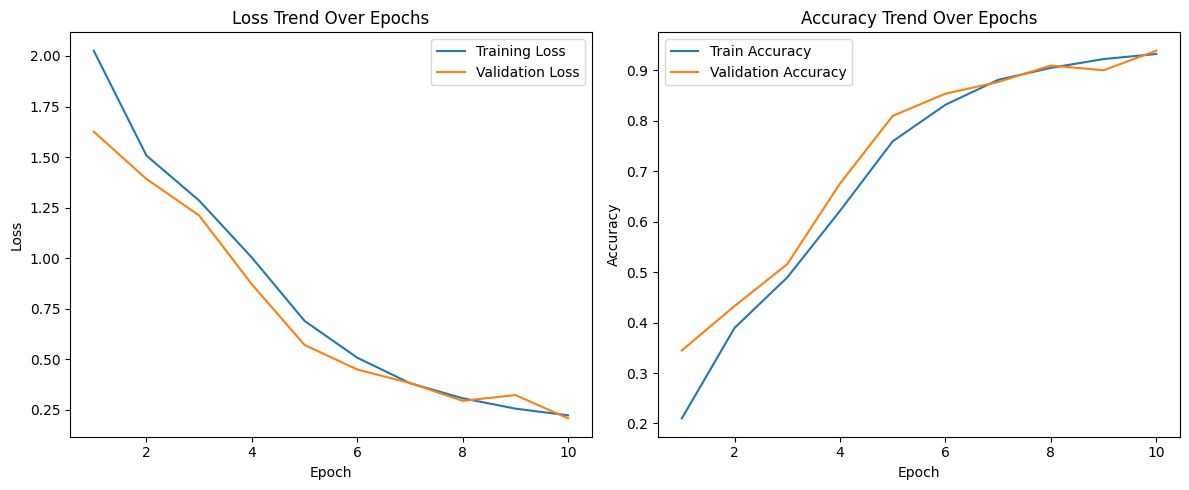

In [51]:
# plot the loss and accuracy trends
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot the loss trend
ax[0].plot(range(1, Epoch+1), loss_values, label='Training Loss')
ax[0].plot(range(1, Epoch+1), valid_loss_values, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Trend Over Epochs')
ax[0].legend()

# plot the accuracy trend
ax[1].plot(range(1, Epoch+1), train_accuracy_values, label='Train Accuracy')
ax[1].plot(range(1, Epoch+1), valid_accuracy_values, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Trend Over Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

In [53]:
import torch
import os
from torchvision import transforms
from PIL import Image
import pandas as pd

# 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 轉換函數 (與 train 相同)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 確保尺寸與訓練時相同
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 測試資料夾
test_folder = './Downloads/test/'
test_images = sorted(os.listdir(test_folder))  # 讀取檔案名稱 (確保順序一致)

# 預測標籤儲存
results = []

# 讀取模型
model.load_state_dict(torch.load("RNN.pth"))
model.to(device)
model.eval()

# 逐一讀取測試圖片並進行預測
for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)
    image = Image.open(img_path).convert("L")  # 轉成灰階
    image = transform(image).unsqueeze(0).to(device)  # 增加 batch 維度

    with torch.no_grad():
        output = model(image)
        probs = torch.nn.functional.softmax(output, dim=1)  # 轉換為機率
        top1_pred = torch.argmax(probs, dim=1).item()  # 取得 top-1 預測結果

    # 存入結果
    results.append({"image": img_name, "class": top1_pred})

# 轉成 DataFrame
df_results = pd.DataFrame(results)

# 存成 CSV 檔案
output_csv = "HW3_prob1_RNN.csv"
df_results.to_csv(output_csv, index=False)

print(f"預測結果已儲存至 {output_csv}")


預測結果已儲存至 HW3_prob1_RNN.csv


Calculate Recall, Precision, F1-score on Validation data

Precision: 0.9385
Recall: 0.9379
F1 Score: 0.9381

Classification Report:
              precision    recall  f1-score   support

           0     0.9373    0.9419    0.9396      3236
           1     0.9799    0.9751    0.9775      3251
           2     0.9142    0.9349    0.9244      2859
           3     0.9404    0.9535    0.9469      2944
           4     0.9542    0.9613    0.9577      2794
           5     0.9599    0.9094    0.9340      2606
           6     0.9501    0.9704    0.9601      2842
           7     0.9379    0.9657    0.9516      3002
           8     0.8797    0.8639    0.8717      2828
           9     0.9317    0.9027    0.9170      2857

    accuracy                         0.9389     29219
   macro avg     0.9385    0.9379    0.9381     29219
weighted avg     0.9389    0.9389    0.9387     29219



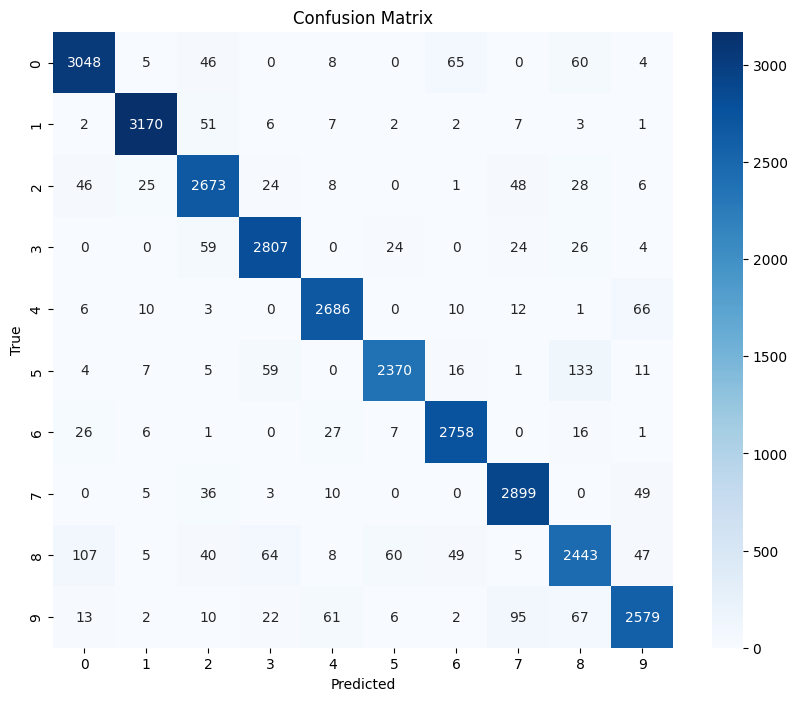

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# We need validation dataset with true labels to calculate metrics
model = simpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)
model.load_state_dict(torch.load("RNN.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Plot confusion matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()